# Imports

In [ ]:
!pip install gitpython
!pip install -q tensorflow keras

In [ ]:
!pip install wordcloud
!pip install torchtext
!pip install datasets
!pip install tqdm
!pip3 install torch torchvision torchaudio

  Using cached torch-2.1.1-cp310-none-macosx_11_0_arm64.whl.metadata (25 kB)
Using cached torch-2.1.1-cp310-none-macosx_11_0_arm64.whl (59.6 MB)
  Attempting uninstall: torch
    Found existing installation: torch 2.1.0
    Uninstalling torch-2.1.0:
      Successfully uninstalled torch-2.1.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.1.0 requires torch==2.1.0, but you have torch 2.1.1 which is incompatible.
torchvision 0.16.0 requires torch==2.1.0, but you have torch 2.1.1 which is incompatible.
  Using cached torch-2.1.0-cp310-none-macosx_11_0_arm64.whl.metadata (24 kB)
Using cached torch-2.1.0-cp310-none-macosx_11_0_arm64.whl (59.5 MB)
  Attempting uninstall: torch
    Found existing installation: torch 2.1.1
    Uninstalling torch-2.1.1:
      Successfully uninstalled torch-2.1.1
ERROR: pip's dependency resolver does not currently take into

In [ ]:
import math
import torchtext
import datasets
import re

import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, OrderedDict

from copy import deepcopy
from string import punctuation
from random import randint
import numpy as np
from PIL import Image
from git import Repo
from pathlib import Path
from nltk.stem.snowball import SnowballStemmer
from collections.abc import MutableMapping
import collections
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import LSTM, Dense, GRU, Embedding
from keras.callbacks import EarlyStopping, ModelCheckpoint

import nltk
from nltk.lm.preprocessing import pad_both_ends
from nltk.lm.preprocessing import padded_everygram_pipeline
from nltk.lm.preprocessing import flatten
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk import ngrams
from nltk.lm import MLE
from nltk.lm import Laplace
from nltk.lm import KneserNeyInterpolated
from nltk.lm import AbsoluteDiscountingInterpolated
from nltk.lm import StupidBackoff
from nltk.lm import NgramCounter
from nltk.lm import Vocabulary
from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk.util import bigrams
from nltk.util import trigrams
from nltk.util import pad_sequence

from torch.utils.data import dataset, DataLoader, Dataset
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.nn import LSTM, GRU
import torch
import torch.nn as nn
import torch.optim as optim
from torch import LongTensor

from tqdm import tqdm

import pyarrow as pa
import pyarrow.dataset as ds
from datasets import Dataset

from torchtext.vocab import vocab
from collections import Counter, OrderedDict

from scipy import stats
from scipy.stats import mannwhitneyu

collections.MutableMapping = MutableMapping

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/kylesullivan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kylesullivan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
!python3 -m venv ~/venv-metal
!source ~/venv-metal/bin/activate
!python -m pip install -U pip

In [ ]:
cities_df = pd.read_csv('/content/world-cities.csv')
names_df = pd.read_csv('/content/players.csv')
states_df = pd.read_csv('/content/states.csv')
state_names_df = pd.read_csv('/content/StateNames.csv')
nat_names_df = pd.read_csv('/content/NationalNames.csv')

In [ ]:
questions_df = pd.read_json('questions_matchinfo.json', orient='index')
commentaries_df = pd.read_json('text_commentaries.json')
transcripts_df = pd.read_json('transcripts_matchinfo.json', orient='index')

# Helper Functions / Background Computations

In [ ]:
# function to calculate perplexity statistical significance
def calc_perp(male_perplexities, female_perplexities):
    # Perform Mann-Whitney U test
    statistic, p_value = mannwhitneyu(male_perplexities, female_perplexities, alternative='two-sided')

    # Print the results
    # print("U-statistic:", statistic)

    # Check for statistical significance
    alpha = 0.05
    larger_perp = '(male perplexity is greater)' if np.mean(male_perplexities) - np.mean(female_perplexities) >= 0 else '(female perplexity is greater)'
    print("Male Perplexity:          ", round(np.mean(male_perplexities), 1))
    print("Female Perplexity:        ", round(np.mean(female_perplexities), 1))
    print("P-value:                  ", round(p_value, 3))
    print("Statistically Significant:", p_value < alpha, end=' ')
    if p_value < alpha:
        print(larger_perp)
    else:
        print()

    return p_value

In [ ]:
# get word valence, arousal, and dominance scores dataframe
def get_xanew(root=Path.home()/'data/X-ANEW',
              url = 'https://github.com/JULIELab/X-ANEW.git'):

    # if not root.is_dir():
    #     root.mkdir()
    #     print('Downloading the dataset from github...')
    #     Repo.clone_from(url, str(root))
    Repo.clone_from(url, str(root))

    csv = str(root / 'Ratings_Warriner_et_al.csv')
    df = pd.read_csv(csv, index_col=0)
    df=df[['Word','V.Mean.Sum', 'A.Mean.Sum', 'D.Mean.Sum']]
    df.columns=['word', 'valence', 'arousal', 'dominance']
    df.set_index('word',inplace=True)

    return df


# downloads the dataset if necessary and returns a pandas DataFrame
vad_word_df = get_xanew()
vad_word_df

valence  arousal  dominance
word                                    
aardvark        6.26     2.41       4.27
abalone         5.30     2.65       4.95
abandon         2.84     3.73       3.32
abandonment     2.63     4.95       2.64
abbey           5.85     2.20       5.00
...              ...      ...        ...
zone            4.75     3.78       5.23
zoning          4.65     3.77       4.47
zoo             7.00     5.63       6.33
zoom            5.86     5.68       5.90
zucchini        6.30     4.18       6.19

[13915 rows x 3 columns]

Construct list of words to remove (locations, names). We remove locations because different locations appear disproportionately with males/females.

In [ ]:
cities_df['cities'] = cities_df['name'].apply(lambda x: x.lower())
cities_df['country'] = cities_df['country'].apply(lambda x: x.lower())
cities_df['subcountry'] = cities_df['subcountry'].apply(lambda x: str(x).lower())

states_df['cities'] = states_df['Cities'].apply(lambda x: str(x).lower())
states_df['states'] = states_df['States'].apply(lambda x: str(x).lower())

state_names_df['Name'] = state_names_df['Name'].apply(lambda x: str(x).lower())
nat_names_df['Name'] = nat_names_df['Name'].apply(lambda x: str(x).lower())

names_df['first_name'] = names_df['first_name'].apply(lambda x: str(x).lower())
names_df['last_name'] = names_df['last_name'].apply(lambda x: str(x).lower())


for p in punctuation:
  cities_df['cities'] = cities_df['cities'].apply(lambda x: str(x).replace(p, ''))
  cities_df['country'] = cities_df['country'].apply(lambda x: str(x).replace(p, ''))
  cities_df['subcountry'] = cities_df['subcountry'].apply(lambda x: str(x).replace(p, ''))
  states_df['cities'] = states_df['Cities'].apply(lambda x: str(x).replace(p, ''))
  states_df['states'] = states_df['States'].apply(lambda x: str(x).replace(p, ''))
  state_names_df['Name'] = state_names_df['Name'].apply(lambda x: str(x).replace(p, ''))
  nat_names_df['Name'] = nat_names_df['Name'].apply(lambda x: str(x).replace(p, ''))
  names_df['first_name'] = names_df['first_name'].apply(lambda x: str(x).replace(p, ''))
  names_df['last_name'] = names_df['last_name'].apply(lambda x: str(x).replace(p, ''))


cities = list(set(cities_df['cities'].to_list()))
countries = list(set(cities_df['country'].to_list()))
subcountries = list(set(cities_df['subcountry'].to_list()))
us_cities = list(set(states_df['cities'].to_list()))
us_states = list(set(states_df['states'].to_list()))
state_names = list(set(state_names_df['Name'].to_list()))
nat_names = list(set(nat_names_df['Name'].to_list()))
first_names = list(set(names_df['first_name'].to_list()))
last_names = list(set(names_df['last_name'].to_list()))

names = []
names.extend(first_names)
names.extend(last_names)
names = list(set(names))
names.extend(state_names)
names = list(set(names))
names.extend(nat_names)
names = list(set(names))

locations = []
locations.extend(cities)
locations.extend(us_cities)
locations = list(set(locations))
locations.extend(us_states)
locations.extend(countries)
locations.extend(subcountries)
locations = list(set(locations))

Get all cleaned words from all of the tennis datasets

In [ ]:
contractions = ["we're", "you're", "they're", "there's", "haven't", "doesn't",
                "must've", "could've", "should've", "might've", "wouldn't",
                "couldn't", "would've", "can't", "won't", "isn't", "wasn't",
                "he's", "she's", "he'll", "she'll", "he'd", "she'd", "they've",
                "they'll", "they'd"]

symbols = "',.()!?\"\\/"

questions_words = ' '.join(questions_df.explode(column='questions')['questions']).split()
commentary_words = ' '.join(commentaries_df.explode(column='commentary')['commentary']).split()

my_ques_df = pd.DataFrame(questions_words, columns =['words'])
my_comm_df = pd.DataFrame(commentary_words, columns =['words'])

# make lowercase
my_ques_df['words'] = my_ques_df['words'].apply(lambda x: x.lower())
my_comm_df['words'] = my_comm_df['words'].apply(lambda x: x.lower())

# remove ending punctuation
my_ques_df['words'] = my_ques_df['words'].apply(lambda x: x[0:-1] if x[-1] in symbols else x)
my_comm_df['words'] = my_comm_df['words'].apply(lambda x: x[0:-1] if x[-1] in symbols else x)

# remove punctuation
for p in punctuation:
  my_ques_df['words'] = my_ques_df['words'].apply(lambda x: x.replace(p, '') if x not in contractions else x)
  my_comm_df['words'] = my_comm_df['words'].apply(lambda x: x.replace(p, '') if x not in contractions else x)

# remove duplicates
questions_words = list(set(my_ques_df['words'].to_list()))
commentary_words = list(set(my_comm_df['words'].to_list()))

answers = []
for interview in transcripts_df['QandA'].to_list():
  for qna in interview:
    answers.append(qna[1])

split_words = [words.split() for words in answers]
answers_words = []
for words in split_words:
  for word in words:
    word = word.lower()
    if word[-1] in symbols:
      word = word[0:-1]
    if word not in contractions:
      for p in punctuation:
        word = word.replace(p, '')
    answers_words.append(word)

all_words = []
all_words.extend(list(set(questions_words)))
all_words.extend(list(set(commentary_words)))
all_words.extend(list(set(answers_words)))
all_words = list(set(all_words))

Additional cleaning / removal of words

In [ ]:
# Get list of names and gender specific words to remove during EDA

# Explode Questions column
questions_df_cleaned = questions_df.explode(column='questions')

# gender specific words, country-related words, and previous players
manual_remove_words = ['he', 'him', 'his', 'she', 'her', 'hers', "he's", "she's",
                       "he'll", "she'll", "he'd", "she'd", 'man', 'men', 'mens',
                       'woman', 'women', 'womens', 'guy', 'girl', 'guys',
                       'girls', 'male', 'female', 'himself', 'herself',
                       'serenas', 'boris', 'agassi', 'sampras', 'del', 'potro',
                       'atp', 'wta', 'fed', 'agut', 'frenchman', 'swiss',
                       'serb', 'serbian', 'russian', 'french', 'american',
                       'australian', 'canadian', 'spanish', 'spaniard', 'scot',
                       'belarusian', 'brit', 'italian', 'german', 'english',
                       'murrays', 'one', 'two', 'three', 'four', 'five', 'six',
                       'seven', 'eight', 'nine', 'ten', 'japan', 'japanese',
                       'china', 'chinese', 'first', 'second', 'third', 'fourth',
                       'fifth', 'sixth', 'seventh', 'eighth', 'ninth', 'tenth',
                       'london', 'shanghai', 'montecarlo', 'wuhan', 'queens',
                       'melbourne', 'singapore', 'eastbourne', 'york', 'polish',
                       'israel', 'florida', 'pole', 'onetwo', 'andre', 'pete',
                       'dubai', 'istanbul', 'australia', 'vika', 'mcenroe',
                       'barcelona', 'sydney', 'madrid', 'brad', 'jo', 'doha',
                       'england', 'lendl', 'nigel', 'borg', 'gonzlez', 'steffi',
                       'america', 'bernie', 'billie', 'charleston', 'switzerland',
                       'stuttgart', 'aga', 'bestofthree', 'jimmy', 'connors',
                       'jean', 'spain', 'south', 'africa', 'russia', 'germany',
                       'flipkens', 'birmingham', 'twosetter', 'twoset',
                       'threesetter', 'threeset', 'foursetter', 'fourset',
                       'fivesetter', 'fiveset', 'graf', 'laver', 'navratilova',
                       'tony', 'moscow', 'stefan', 'italy', 'ashe', 'evert',
                       'genie', 'romania', 'goran', 'washington', 'cincinnati',
                       'belgium', 'bercy', 'sugarpova', 'montreal', 'toronto',
                       'halle', 'stanford', 'seles', 'hobart', 'san', 'diego',
                       'los', 'angeles', 'york', 'poland', 'achale', 'kooyong',
                       'sunday', 'monday', 'tuesday', 'wednesday', 'thursday',
                       'friday', 'saturday', 'georgia', 'argentina', 'hanburg',
                       'sven', 'california', 'casse', 'etienne', 'federernadal',
                       'gracialopez', 'caas', 'magnus', 'pattaya', 'courier',
                       'turkish', 'loydra', 'sasha', 'petko', 'chernobyl',
                       'rafa', 'llodra', 'knowles', 'fifthset', 'williamses',
                       'golubev', 'shell', 'hogstedt', 'allaster', 'annacone',
                       'dhabi', 'piatti', 'allwilliams', 'ncaas', 'ncaa',
                       'shoaxuan', 'swedes', 'supersaturday', 'ponte', 'gangnam',
                       'belgians', 'belgian', 'stanislas', 'puerto', 'twohour',
                       'roig', 'matsuoka', 'garcialopez', 'ukrainian', 'gstaad',
                       'frenchwoman', 'djoko', 'greek', 'belorussian', 'muzza',
                       'makarvoa', 'zealander', 'berydch', 'wellexecuted',
                       'highquality', 'delpo', 'lpez', 'portuguese', 'rola',
                       'croat', 'dutchman', 'dutchwoman', 'chinatown', 'antwerp',
                       'allrussian', 'duval', 'ghangzou', 'romanians', 'krakow',
                       'brazilian', 'swedish', "they've", "they're", "they's",
                       "they'll", "they'd", "there's", "you", "your", "you're",
                       "there", 'sandiego', 'argentinian', 'qubec', 'hungarian',
                       'iulian']

partial_remove_words = ['first', 'second', 'third', 'fourth', 'fifth', 'sixth',
                        'seventh', 'eighth', 'ninth', 'tenth', 'eleventh',
                        'twelfth', 'thirteenth', 'fourteenth', 'fifteenth',
                        'two', 'three', 'four', 'five', 'six', 'seven', 'eight',
                        'nine']

"""player names from the data (questions and interviews dataframes)"""

# make lowercase
questions_df_cleaned['player'] = questions_df_cleaned['player'].apply(lambda x: x.lower())
transcripts_df['player'] = transcripts_df['player'].apply(lambda x: x.lower())
transcripts_df['opponent'] = transcripts_df['opponent'].apply(lambda x: x.lower())

# remove ending punctuation
questions_df_cleaned['player'] = questions_df_cleaned['player'].apply(lambda x: str(x)[0:-1] if str(x)[-1] in symbols else str(x))
transcripts_df['player'] = transcripts_df['player'].apply(lambda x: str(x)[0:-1] if str(x)[-1] in symbols else str(x))
transcripts_df['opponent'] = transcripts_df['opponent'].apply(lambda x: str(x)[0:-1] if str(x)[-1] in symbols else str(x))

# remove punctation
for p in punctuation:
    questions_df_cleaned['player'] = questions_df_cleaned['player'].apply(lambda x: str(x).replace(p, '') if str(x) not in contractions else x)
    transcripts_df['player'] = transcripts_df['player'].apply(lambda x: str(x).replace(p, '') if str(x) not in contractions else x)
    transcripts_df['opponent'] = transcripts_df['opponent'].apply(lambda x: str(x).replace(p, '') if str(x) not in contractions else x)

# remove duplicates
q_players = list(set(questions_df_cleaned['player'].to_list()))
a_players = list(set(transcripts_df['player'].to_list()))
a_opp_players = list(set(transcripts_df['opponent'].to_list()))

# get first/last names
q_first_names = [player.split()[0] if len(player.split()) > 1 else player.split()[0] for player in q_players]
q_last_names = [player.split()[1] for player in q_players]
a_first_names = [player.split()[0] for player in a_players]
a_last_names = [player.split()[1] for player in a_players]
a_opp_first_names = [player.split()[0] for player in a_opp_players]
a_opp_last_names = [player.split()[1] if len(player.split()) > 1 else player.split()[0] for player in a_opp_players]

# remove duplicates
q_first_names = list(set(q_first_names))
q_last_names = list(set(q_last_names))
a_first_names = list(set(a_first_names))
a_last_names = list(set(a_last_names))
a_opp_first_names = list(set(a_opp_first_names))
a_opp_last_names = list(set(a_opp_last_names))

# combine names and gender specific words into one list of words to be removed
remove_words = manual_remove_words + q_first_names + q_last_names + a_first_names + a_last_names + a_opp_first_names + a_opp_last_names + names + locations
remove_words.extend([word for word in set(all_words) for p_word in partial_remove_words if p_word in word])
remove_words = list(set(remove_words))

# get intersection of remove words and all words
removed_words = list(set(all_words) & set(remove_words))
removed_words_df = pd.DataFrame(removed_words, columns =['words'])

# save the removed words to a dataframe for later use
removed_words_df.to_csv('removed_words.zip', index=False,
          compression=dict(method='zip', archive_name='removed_words.csv')  )

Function to get words occurring disproportionately with males and females

In [ ]:
def get_diff_words(male_words, female_words, n_stds, graph_name=None):

  Counter(male_words)

  # lowercase words and remove punctuation
  male_words_cleaned = []
  female_words_cleaned = []

  for pair in Counter(male_words).most_common():
    m_word = pair[0].lower()
    m_count = pair[1]
    if m_word[-1] in symbols:
      m_word = m_word[0:-1]
    if m_word in contractions:
      if (m_word not in removed_words) and (m_word[0:-1] not in removed_words):
          male_words_cleaned.extend([m_word for _ in range(m_count)])
    else:
      if not set(m_word).intersection('0123456789'):
        for p in punctuation:
          m_word = m_word.replace(p, '')
        if (m_word not in removed_words) and (m_word[0:-1] not in removed_words):
          male_words_cleaned.extend([m_word for _ in range(m_count)])

  for pair in Counter(female_words).most_common():
    f_word = pair[0].lower()
    f_count = pair[1]
    if f_word[-1] in symbols:
      f_word = f_word[0:-1]
    if f_word in contractions:
      if (f_word not in removed_words) and (f_word[0:-1] not in removed_words):
          female_words_cleaned.extend([f_word for _ in range(f_count)])
    else:
      if not set(f_word).intersection('0123456789'):
        for p in punctuation:
          f_word = f_word.replace(p, '')
        if (f_word not in removed_words) and (f_word[0:-1] not in removed_words):
          female_words_cleaned.extend([f_word for _ in range(f_count)])

  # rename cleaned list
  male_words = male_words_cleaned
  female_words = female_words_cleaned

  # get list of male and female word count tuples
  male_word_counts = list(dict(Counter(male_words)).values())
  female_word_counts = list(dict(Counter(female_words)).values())

  # get respective desired cutoffs for number of standard deviations above mean
  male_freq_cutoff = n_stds*np.std(male_word_counts) + np.mean(male_word_counts)
  female_freq_cutoff = n_stds*np.std(female_word_counts) + np.mean(female_word_counts)

  if graph_name:
    # print means and standard deviations
    print('-------------------------------------------------------------------')
    print("Male Frequency Mean:", np.mean(male_word_counts))
    print("Female Frequency Mean:", np.mean(female_word_counts))
    print("Male Frequency STD:", np.std(male_word_counts))
    print("Female Frequency STD:", np.std(female_word_counts))
    print('-------------------------------------------------------------------')

  """Remove words that appear in both the mens and womens question data and
  appear a certain number of standard deviations above the mean frequency in
  the combined data set."""

  # get male, female, and an intersection Counters
  male_counter = Counter(male_words)
  female_counter = Counter(female_words)

  # get male/female (word, count) tuple lists and list of intersection words
  male_word_count_list = male_counter.most_common()
  female_word_count_list = female_counter.most_common()

  # get list of intersection words that appear more often than the
  #    designated cutoff
  male_top_inter_list = [i[0] for i in male_word_count_list
                        if i[1] > male_freq_cutoff]

  female_top_inter_list = [i[0] for i in female_word_count_list
                          if i[1] > female_freq_cutoff]

  # take the intersection of the male/female intersection lists
  top_inter_list = list(set(male_top_inter_list) & set(female_top_inter_list))

  # create reduced male and female words lists by removing these high frequency
  #    intersection words
  male_words_red = [[pair[0] for _ in range(pair[1])] for pair in male_word_count_list if pair[0] not in top_inter_list]
  female_words_red = [[pair[0] for _ in range(pair[1])] for pair in female_word_count_list if pair[0] not in top_inter_list]
  male_words_red = [word for sublst in male_words_red for word in sublst]
  female_words_red = [word for sublst in female_words_red for word in sublst]

  # get difference in male and female word lengths
  length_diff = len(male_words_red) - len(female_words_red)

  # randomly remove words from bigger list until both are the same size
  if length_diff > 0:
    for _ in range(length_diff):
      male_words_red.pop(randint(0, len(male_words_red)-1))
  else:
    for _ in range(-length_diff):
      female_words_red.pop(randint(0, len(female_words_red)-1))

  # get counts of reduced lists
  male_reduced_counter = Counter(male_words_red)
  female_reduced_counter = Counter(female_words_red)

  if graph_name:
    # print sizes of each list to make sure they match
    print('Male Word Count:', male_reduced_counter.total())
    print('Female Word Count:', female_reduced_counter.total())
    print('-------------------------------------------------------------------')

  """Time to get the differences when subtracting each of the counts from
  the other."""

  # copy male and female counters
  male_diff_counter = deepcopy(male_reduced_counter)
  female_diff_counter = deepcopy(female_reduced_counter)

  # subtract each from the other to get the difference in counts
  male_diff_counter.subtract(female_reduced_counter)
  female_diff_counter.subtract(male_reduced_counter)

  # get male and female elements from these words more associated with each
  male_elements = sorted(male_diff_counter.elements())
  female_elements = sorted(female_diff_counter.elements())

  # get male and female diff lists of tuple (word, counts)
  male_diff_list = male_diff_counter.most_common()
  female_diff_list = female_diff_counter.most_common()

  if graph_name:

    """Create word clouds for the male/female results"""

    # male world cloud
    male_mask = np.array(Image.open("/content/male_symbol.jpg"))
    male_wordcloud = WordCloud(width=10, height=15, mask=male_mask,
                          background_color='navy').fit_words(dict(male_diff_list))

    # female world cloud
    female_mask = np.array(Image.open("/content/female_symbol.jpg"))
    female_wordcloud = WordCloud(width=10, height=15, mask=female_mask,
                          background_color='pink').fit_words(dict(female_diff_list))

    # Display the generated word cloud using matplotlib
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,10))
    ax1.imshow(male_wordcloud.recolor(color_func=male_color_func, random_state=3), interpolation='bilinear')
    ax2.imshow(female_wordcloud.recolor(color_func=female_color_func, random_state=3), interpolation='bilinear')
    ax1.axis('off')
    ax2.axis('off')
    ax1.set_title("Disproportionately Male-Occurring Words", fontsize = 12)
    ax2.set_title("Disproportionately Female-Occurring Words", fontsize = 12)
    if n_stds:
      fig.suptitle(str(graph_name) + " Word Clouds by Gender\n(removed intersection words with freq above {} stds)".format(n_stds), fontsize = 22)
    else:
      fig.suptitle(str(graph_name) + " Word Clouds by Gender\n(removed intersection words with freq above the mean)", fontsize = 22)

  return (male_elements, female_elements), (male_reduced_counter, female_reduced_counter), (male_diff_counter, female_diff_counter)

Function to get valence, arousal, dominance scores

In [ ]:
def get_avg_vad(male_words, female_words, n_stds, graph_name=None):

  diff_counters = get_diff_words(male_words, female_words, n_stds)[2]
  stemmer = SnowballStemmer("english")

  output_lst = []
  print('-------------------------------------------------------------------')
  for i, lst in enumerate(diff_counters):
    lst = lst.most_common()
    valence = []
    arousal = []
    dominance = []
    words_included = []
    words_excluded = []
    for word, count in lst:
      if word in vad_word_df.index:
        valence.extend([vad_word_df.loc[word]['valence'] for _ in range(count)])
        arousal.extend([vad_word_df.loc[word]['arousal'] for _ in range(count)])
        dominance.extend([vad_word_df.loc[word]['dominance'] for _ in range(count)])
        words_included.extend([word for word in range(count)])
      elif len(word) > 1 and word[-1] == 's' and word[0:-1] in vad_word_df.index:
        word = word[0:-1]
        valence.extend([vad_word_df.loc[word]['valence'] for _ in range(count)])
        arousal.extend([vad_word_df.loc[word]['arousal'] for _ in range(count)])
        dominance.extend([vad_word_df.loc[word]['dominance'] for _ in range(count)])
        words_included.extend([word for word in range(count)])
      elif len(word) > 1 and word[-1] == 'y' and word[0:-1] in vad_word_df.index:
        word = word[0:-1]
        valence.extend([vad_word_df.loc[word]['valence'] for _ in range(count)])
        arousal.extend([vad_word_df.loc[word]['arousal'] for _ in range(count)])
        dominance.extend([vad_word_df.loc[word]['dominance'] for _ in range(count)])
        words_included.extend([word for word in range(count)])
      elif len(word) > 2 and word[-2:] == 'ed' and word[0:-2] in vad_word_df.index:
        word = word[0:-2]
        valence.extend([vad_word_df.loc[word]['valence'] for _ in range(count)])
        arousal.extend([vad_word_df.loc[word]['arousal'] for _ in range(count)])
        dominance.extend([vad_word_df.loc[word]['dominance'] for _ in range(count)])
        words_included.extend([word for word in range(count)])
      elif len(word) > 2 and word[-2:] == 'er' and word[0:-2] in vad_word_df.index:
        word = word[0:-2]
        valence.extend([vad_word_df.loc[word]['valence'] for _ in range(count)])
        arousal.extend([vad_word_df.loc[word]['arousal'] for _ in range(count)])
        dominance.extend([vad_word_df.loc[word]['dominance'] for _ in range(count)])
        words_included.extend([word for word in range(count)])
      elif len(word) > 2 and word[-2:] == 'ly' and word[0:-2] in vad_word_df.index:
        word = word[0:-2]
        valence.extend([vad_word_df.loc[word]['valence'] for _ in range(count)])
        arousal.extend([vad_word_df.loc[word]['arousal'] for _ in range(count)])
        dominance.extend([vad_word_df.loc[word]['dominance'] for _ in range(count)])
        words_included.extend([word for word in range(count)])
      elif len(word) > 2 and word[-2:] == 'es' and word[0:-2] in vad_word_df.index:
        word = word[0:-2]
        valence.extend([vad_word_df.loc[word]['valence'] for _ in range(count)])
        arousal.extend([vad_word_df.loc[word]['arousal'] for _ in range(count)])
        dominance.extend([vad_word_df.loc[word]['dominance'] for _ in range(count)])
        words_included.extend([word for word in range(count)])
      elif len(word) > 3 and word[-3:] == 'ing' and word[0:-3] in vad_word_df.index:
        word = word[0:-3]
        valence.extend([vad_word_df.loc[word]['valence'] for _ in range(count)])
        arousal.extend([vad_word_df.loc[word]['arousal'] for _ in range(count)])
        dominance.extend([vad_word_df.loc[word]['dominance'] for _ in range(count)])
        words_included.extend([word for word in range(count)])
      elif len(word) > 3 and word[-3:] == 'ity' and word[0:-3] in vad_word_df.index:
        word = word[0:-3]
        valence.extend([vad_word_df.loc[word]['valence'] for _ in range(count)])
        arousal.extend([vad_word_df.loc[word]['arousal'] for _ in range(count)])
        dominance.extend([vad_word_df.loc[word]['dominance'] for _ in range(count)])
        words_included.extend([word for word in range(count)])
      elif len(word) > 3 and word[-3:] == 'ery' and word[0:-3] in vad_word_df.index:
        word = word[0:-3]
        valence.extend([vad_word_df.loc[word]['valence'] for _ in range(count)])
        arousal.extend([vad_word_df.loc[word]['arousal'] for _ in range(count)])
        dominance.extend([vad_word_df.loc[word]['dominance'] for _ in range(count)])
        words_included.extend([word for word in range(count)])
      elif len(word) > 3 and word[-3:] == 'ant' and word[0:-3] in vad_word_df.index:
        word = word[0:-3]
        valence.extend([vad_word_df.loc[word]['valence'] for _ in range(count)])
        arousal.extend([vad_word_df.loc[word]['arousal'] for _ in range(count)])
        dominance.extend([vad_word_df.loc[word]['dominance'] for _ in range(count)])
        words_included.extend([word for word in range(count)])
      elif len(word) > 3 and word[-3:] == 'ism' and word[0:-3] in vad_word_df.index:
        word = word[0:-3]
        valence.extend([vad_word_df.loc[word]['valence'] for _ in range(count)])
        arousal.extend([vad_word_df.loc[word]['arousal'] for _ in range(count)])
        dominance.extend([vad_word_df.loc[word]['dominance'] for _ in range(count)])
        words_included.extend([word for word in range(count)])
      elif len(word) > 4 and word[-4:] == 'ness' and word[0:-4] in vad_word_df.index:
        word = word[0:-4]
        valence.extend([vad_word_df.loc[word]['valence'] for _ in range(count)])
        arousal.extend([vad_word_df.loc[word]['arousal'] for _ in range(count)])
        dominance.extend([vad_word_df.loc[word]['dominance'] for _ in range(count)])
        words_included.extend([word for word in range(count)])
      elif len(word) > 4 and word[-4:] == 'ment' and word[0:-4] in vad_word_df.index:
        word = word[0:-4]
        valence.extend([vad_word_df.loc[word]['valence'] for _ in range(count)])
        arousal.extend([vad_word_df.loc[word]['arousal'] for _ in range(count)])
        dominance.extend([vad_word_df.loc[word]['dominance'] for _ in range(count)])
        words_included.extend([word for word in range(count)])
      elif len(word) > 4 and word[-4:] == 'ship' and word[0:-4] in vad_word_df.index:
        word = word[0:-4]
        valence.extend([vad_word_df.loc[word]['valence'] for _ in range(count)])
        arousal.extend([vad_word_df.loc[word]['arousal'] for _ in range(count)])
        dominance.extend([vad_word_df.loc[word]['dominance'] for _ in range(count)])
        words_included.extend([word for word in range(count)])
      elif stemmer.stem(word) in vad_word_df:
        word = stemmer.stem(word)
        valence.extend([vad_word_df.loc[word]['valence'] for _ in range(count)])
        arousal.extend([vad_word_df.loc[word]['arousal'] for _ in range(count)])
        dominance.extend([vad_word_df.loc[word]['dominance'] for _ in range(count)])
        words_included.extend([word for word in range(count)])
      else:
        words_excluded.extend([word for word in range(count)])
    output_lst.append((valence, arousal, dominance))

    if i:
      name = "Female"
    else:
      name = "Male"
    print(name + " Percentage of Words Included:", round(len(words_included) /
                                                    (len(words_included) +
                                                    len(words_excluded)), 2))
    print('-------------------------------------------------------------------')

    if not graph_name:
      print(name + " Average Valence:", round(np.mean(valence), 2))
      print(name + " Average Arousal:", round(np.mean(arousal), 2))
      print(name + " Average Dominance:", round(np.mean(dominance), 2))


  if graph_name:

    combined_v = output_lst[0][0] + output_lst[1][0]
    combined_a = output_lst[0][1] + output_lst[1][1]
    combined_d = output_lst[0][2] + output_lst[1][2]
    combined_vad_scores = combined_v + combined_a + combined_d
    combined_vad_labels = ['valence' for _ in range(len(combined_v))] + ['arousal' for _ in range(len(combined_a))] + ['dominance' for _ in range(len(combined_d))]
    combined_g = 3*(['M' for _ in range(len(output_lst[0][0]))] + ['F' for _ in range(len(output_lst[1][0]))])

    df = pd.DataFrame(list(zip(combined_vad_labels, combined_vad_scores, combined_g)),
                columns=['label', 'score', 'gender'])

    # create custom colors array
    colors = ["#001ba1", "#fc90ab"]
    # set custom color palette
    sns.set_palette(sns.color_palette(colors))

    ax = sns.barplot(data=df, x='label', y='score',
                    hue='gender', dodge=True, hue_order=['M', 'F'],
                    estimator="mean", errorbar=None)

    ax.bar_label(ax.containers[0], fmt='%.2f', fontsize=10);
    ax.bar_label(ax.containers[1], fmt='%.2f', fontsize=10);

    # Adding labels and title
    plt.xlabel('Word Characteristics', fontsize=12)
    plt.ylabel('Mean Characteristic Score', fontsize=12)
    if n_stds:
      plt.title(str(graph_name) + " Mean Word Characteristic Scores by Gender\n(removed intersection words with freq above {} stds)".format(n_stds), fontsize = 15)
    else:
      plt.title(str(graph_name) + " Mean Word Characteristic Scores by Gender\n(removed intersection words with freq above the mean)", fontsize = 15)

    # Adding a legend
    plt.legend()

    # Display the plot
    plt.show()

  return output_lst

Functions to get male/female colors

In [ ]:
def female_color_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    return "hsl(230, 100%%, %d%%)" % randint(20, 50)

def male_color_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    return "hsl(5, 55%%, %d%%)" % randint(70, 100)

# Exploring dataframes

Files
-----

* *questions_matchinfo.json* - a JSON file containing the press conference question snippets together with player ranking and game result.
* *transcripts_matchinfo.json* - a JSON file containing full transcripts with more complete match information.
* *text_commentaries.json* - a JSON file containing commentary data.

In [ ]:
questions_df.head()

player gender  result  \
0     Andy Murray      M       1   
1  Kevin Anderson      M       0   
2  Kevin Anderson      M       1   
3    Gilles Simon      M       1   
4    Milos Raonic      M       0   

                                           questions  ranking  
0  [That last set seemed like a faultless perform...      3.0  
1  [What was it like out there, Kevin?, That was ...     17.0  
2  [You were saying courtside you haven't done an...     17.0  
3  [Big serving has been sort of the theme for th...     13.0  
4  [How disappointing is that loss for you?, When...      8.0

In [ ]:
commentaries_df.head()

commentary  \
0  Makarova slumps back into making unforced erro...   
1  Just look in her match with Heather Watson las...   
2  Sharapova saves a break point to hold her serv...   
3  Erakovic is looking superb behind her serve, a...   
4  She can't save another one and Williams is now...   

                    scoreline gender  
0     Sharapova 6-3* Makarova      F  
1  Williams 3-6 2-1* Azarenka      F  
2     Williams *0-2 Sharapova      F  
3        Robson 1-4* Erakovic      F  
4   Williams 2-6 5-1* Lisicki      F

In [ ]:
transcripts_df.head()

QandA  ranking tournament_type  \
0  [[That last set seemed like a faultless perfor...      3.0          ATP500   
1  [[What was it like out there, Kevin?, It was t...     17.0          ATP500   
2  [[You were saying courtside you haven't done a...     17.0          ATP500   
3  [[Big serving has been sort of the theme for t...     13.0          ATP500   
4  [[How disappointing is that loss for you?, The...      8.0          ATP500   

  gender           tournament          player  result       date  \
0      M  AEGON CHAMPIONSHIPS     andy murray       1 2015-06-21   
1      M  AEGON CHAMPIONSHIPS  kevin anderson       0 2015-06-21   
2      M  AEGON CHAMPIONSHIPS  kevin anderson       1 2015-06-20   
3      M  AEGON CHAMPIONSHIPS    gilles simon       1 2015-06-19   
4      M  AEGON CHAMPIONSHIPS    milos raonic       0 2015-06-19   

           stage        opponent  
0      The Final  kevin anderson  
1      The Final     andy murray  
2     Semifinals    gilles simon  
3  Quarterfinals    milos raonic  
4  Quarterfinals    gilles simon

## Questions Data

Post-match press conferences in tennis take place shortly after each match. Players enter a press conference room to face a group of reporters from different news agencies and answer questions posed to them.

This file contains a slightly processed version of the transcript data which we use in our study. It covers a total of 6467 post-match press conferences. Duplicate questions from the same interview are removed.

It is in the form of a JSON file with five fields:
- 'gender': player gender
- 'player': name of the player being interviewed
- 'questions': list of question snippets asked in the press conference. Each entry represents one turn from one reporter.
- 'ranking': ranking of the player
- 'result': 1 indicates the player being interviewed is the match winner; 0 otherwise.

For the full transcript and more complete match information, refer to the transcript data described below.


In [ ]:
questions_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6467 entries, 0 to 6466
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   player     6467 non-null   object 
 1   gender     6467 non-null   object 
 2   result     6467 non-null   int64  
 3   questions  6467 non-null   object 
 4   ranking    6466 non-null   float64
dtypes: float64(1), int64(1), object(3)
memory usage: 303.1+ KB


### All Question Data Word Cloud

In [ ]:
commentaries_df['commentary'].iloc[0]

"Makarova slumps back into making unforced errors again as she finds the net with her first forehand of the game, while her second isn't much better as she overhits when attempting to clip the baseline. Sharapova hits an accurate serve down the 'T' to bring up three set points. Another pinpoint serves proves too difficult to return as the number two seed claims the first set."

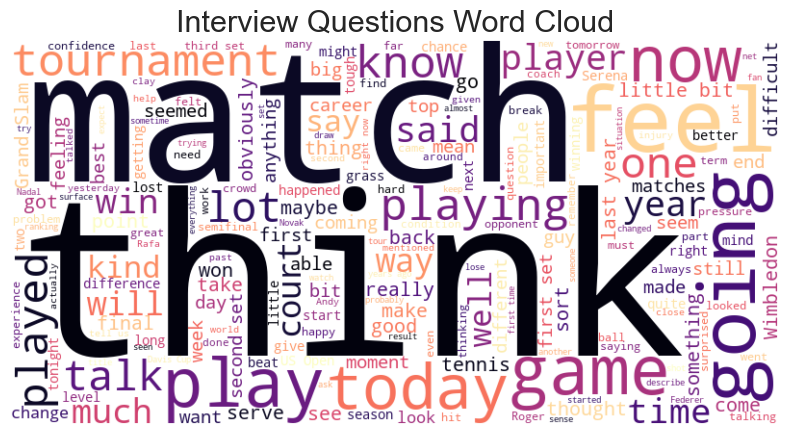

In [ ]:
# All Questions Word Cloud
all_questions_text = ' '.join(questions_df_cleaned['questions'])
all_questions = all_questions_text.split()

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400,
                      colormap=sns.color_palette("magma", as_cmap=True),
                      background_color='white').generate(all_questions_text)

# Display the generated word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Interview Questions Word Cloud', fontsize = 22)
plt.show()

### Gender Specific Question Data Word Clouds

In [ ]:
# filter into men's and women's data
questions_m_df_cleaned = questions_df_cleaned[questions_df_cleaned['gender'] == 'M']
questions_f_df_cleaned = questions_df_cleaned[questions_df_cleaned['gender'] == 'F']
male_question_text = ' '.join(questions_m_df_cleaned['questions'])
female_question_text = ' '.join(questions_f_df_cleaned['questions'])

# convert male and female words into lists
male_question_words = male_question_text.split()
female_question_words = female_question_text.split()

-------------------------------------------------------------------
Male Frequency Mean: 36.454384687402474
Female Frequency Mean: 33.96903062399263
Male Frequency STD: 274.5749864840451
Female Frequency STD: 245.2484623277925
-------------------------------------------------------------------
Male Word Count: 98110
Female Word Count: 98110
-------------------------------------------------------------------


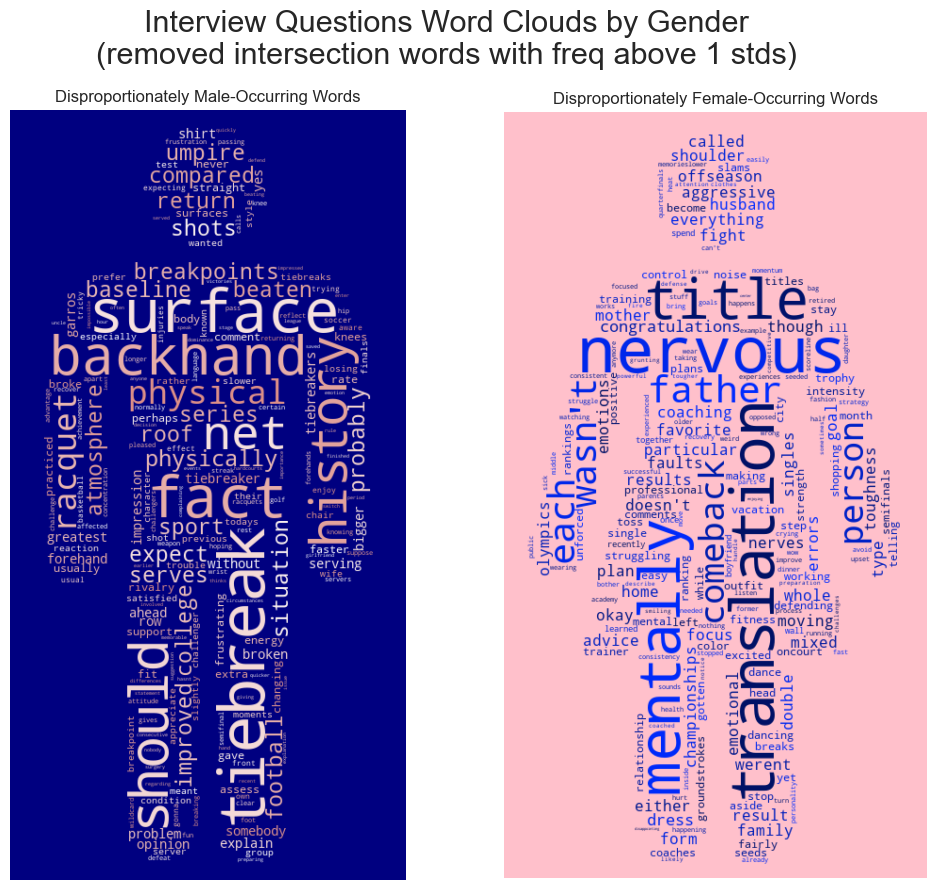

In [ ]:
question_elements_1std, question_counters_1std, question_diff_lists_1std = \
get_diff_words(male_question_words, female_question_words, 1, 'Interview Questions')

-------------------------------------------------------------------
Male Frequency Mean: 36.454384687402474
Female Frequency Mean: 33.96903062399263
Male Frequency STD: 274.5749864840451
Female Frequency STD: 245.2484623277925
-------------------------------------------------------------------
Male Word Count: 36062
Female Word Count: 36062
-------------------------------------------------------------------


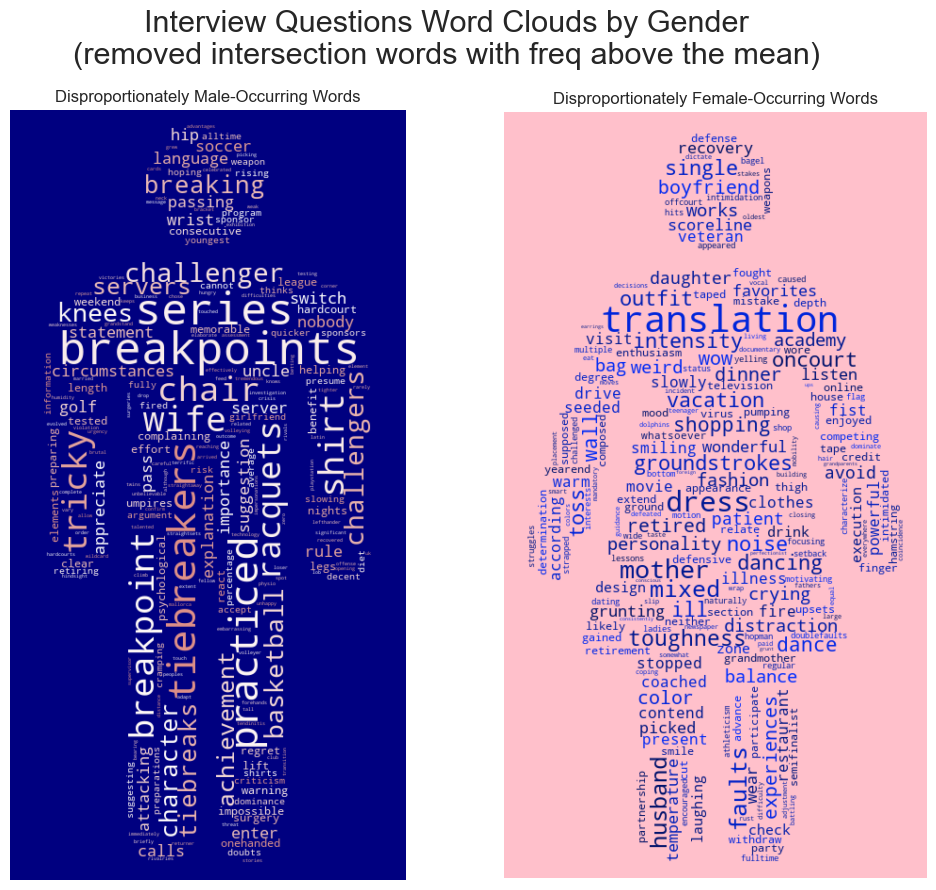

In [ ]:
question_elements_0std, question_counters_0std, question_diff_lists_0std = \
get_diff_words(male_question_words, female_question_words, 0, 'Interview Questions')

-------------------------------------------------------------------
Male Frequency Mean: 36.454384687402474
Female Frequency Mean: 33.96903062399263
Male Frequency STD: 274.5749864840451
Female Frequency STD: 245.2484623277925
-------------------------------------------------------------------
Male Word Count: 3872
Female Word Count: 3872
-------------------------------------------------------------------


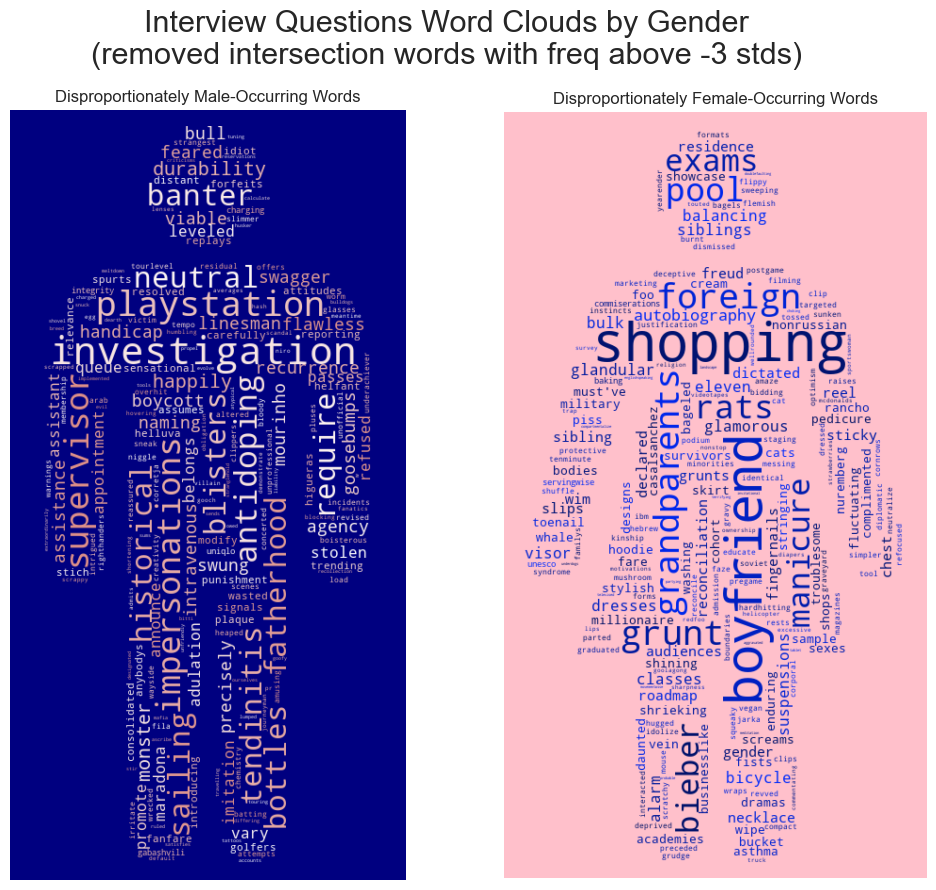

In [ ]:
question_elements_neg_3std, question_counters_neg_3std, question_diff_lists_neg_3std = \
get_diff_words(male_question_words, female_question_words, -3, 'Interview Questions')

### Mean Word Characteristic Scores by Gender

After removing the intersection of words appearing more than one standard deviation from the mean in both the men's and women's questions, we take the mean word characteristic score of the difference in counts to see how words more commonly used to describe men deviate from those more commonly used to describe women.

-------------------------------------------------------------------
Male Percentage of Words Included: 0.68
-------------------------------------------------------------------
Female Percentage of Words Included: 0.73
-------------------------------------------------------------------


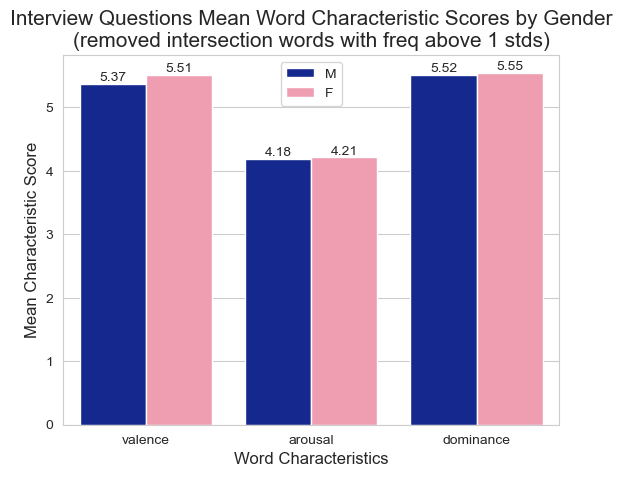

In [ ]:
male_triple, female_triple = get_avg_vad(male_question_words, female_question_words, 1, 'Interview Questions')

-------------------------------------------------------------------
Male Percentage of Words Included: 0.69
-------------------------------------------------------------------
Female Percentage of Words Included: 0.7
-------------------------------------------------------------------


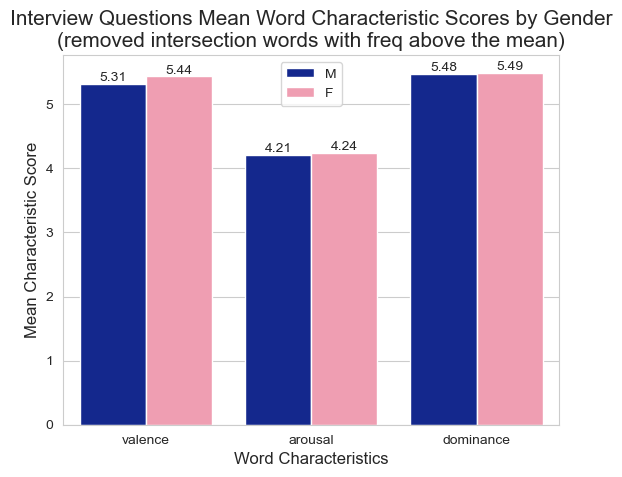

In [ ]:
male_triple, female_triple = get_avg_vad(male_question_words, female_question_words, 0, 'Interview Questions')

-------------------------------------------------------------------
Male Percentage of Words Included: 0.55
-------------------------------------------------------------------
Female Percentage of Words Included: 0.57
-------------------------------------------------------------------


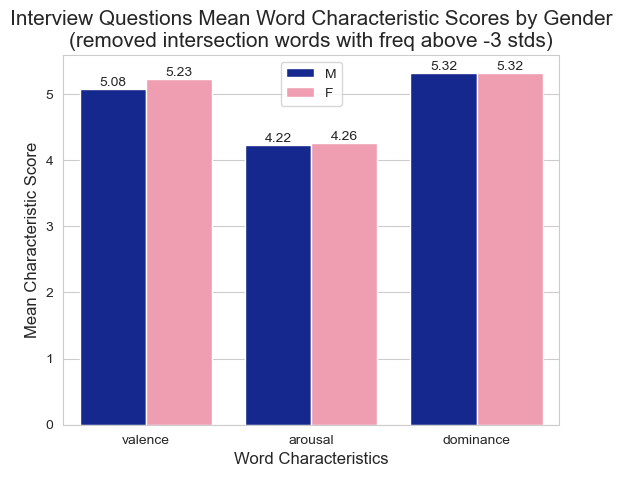

In [ ]:
male_triple, female_triple = get_avg_vad(male_question_words, female_question_words, -3, 'Interview Questions')

### Number of Questions Per Ranking For Male and Female Players

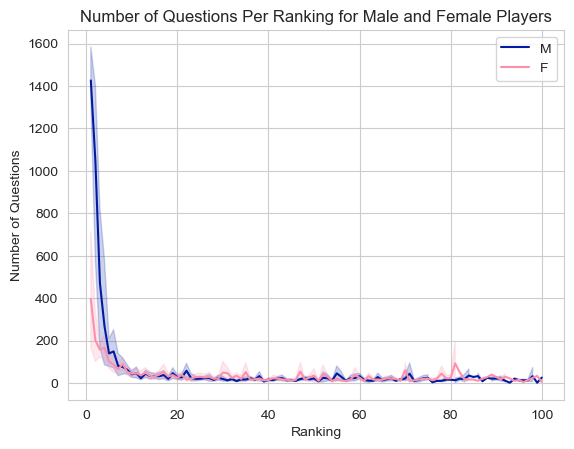

In [ ]:
# Questions per rank and gender (top 100 players)
question_counts = questions_df_cleaned.groupby(by=["player", "ranking", "gender"])[['questions']].count().reset_index()
top_100 = question_counts[question_counts['ranking']<=100]
sns.lineplot(data=top_100, x='ranking', y='questions', hue='gender')

# Adding labels and title
plt.xlabel('Ranking')
plt.ylabel('Number of Questions')
plt.title('Number of Questions Per Ranking for Male and Female Players')

# Adding a legend
plt.legend()

# Display the plot
plt.show()

### Number of Questions for Male and Female Players in the Top 5

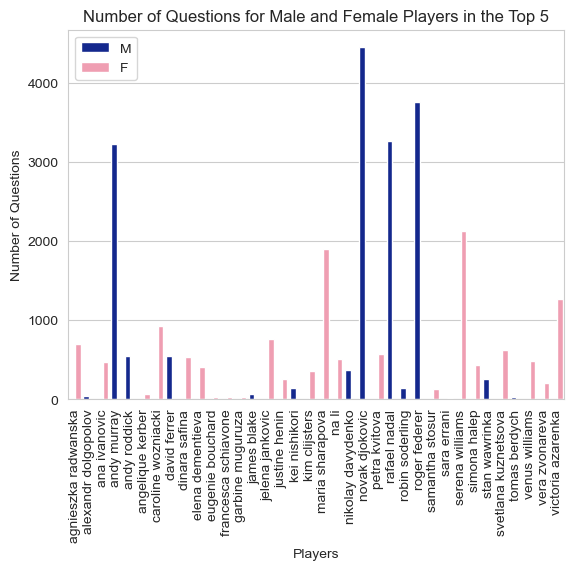

In [ ]:
# Questions per rank and gender (top 100 players)
question_counts = questions_df_cleaned.groupby(by=["player", "ranking", "gender"])[['questions']].count().reset_index()
top_5 = question_counts[question_counts['ranking']<=5]
top_5 = top_5.groupby(['player', 'gender'])[['questions']].sum().reset_index()
sns.barplot(data=top_5, x='player', y='questions', hue='gender', hue_order=['M', 'F'])

# create custom colors array
colors = ["#001ba1", "#fc90ab"]
# set custom color palette
sns.set_palette(sns.color_palette(colors))

# Adding labels and title
plt.xlabel('Players')
plt.xticks(rotation=90)
plt.ylabel('Number of Questions')
plt.title('Number of Questions for Male and Female Players in the Top 5')

# Adding a legend
plt.legend()

# Display the plot
plt.show()

## Commentaries Data

The commentary data contains 3962 pieces of live-text play-by-play commentaries, split evenly between men and women singles matches. It is a JSON file with three fields:

	- 'commentary': the actual text from the live updates. It describes the process of the game.
	- 'gender': 'F' indicates the update is from a women's match; 'M' means it is from men's game.
	- 'scoreline': the score when the text update is posted. * indicates the player who is serving at the moment.

While we used Sports Mole's commentaries for our study, ByTheMinute could be another source to gather similar data.



In [ ]:
commentaries_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3962 entries, 0 to 3961
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   commentary  3962 non-null   object
 1   scoreline   3962 non-null   object
 2   gender      3962 non-null   object
dtypes: object(3)
memory usage: 93.0+ KB


In [ ]:
commentaries_df['commentary']

0       Makarova slumps back into making unforced erro...
1       Just look in her match with Heather Watson las...
2       Sharapova saves a break point to hold her serv...
3       Erakovic is looking superb behind her serve, a...
4       She can't save another one and Williams is now...
                              ...                        
3957    That's more promising from the Russian, who se...
3958    A sharp backhand volley hands Azarenka the ope...
3959    Azarenka is serving to stay in the set, and th...
3960    The power on show in some of these rallies wou...
3961    That could be the game that breaks the resolve...
Name: commentary, Length: 3962, dtype: object

In [ ]:
commentaries_df['commentary'].explode()[0]

"Makarova slumps back into making unforced errors again as she finds the net with her first forehand of the game, while her second isn't much better as she overhits when attempting to clip the baseline. Sharapova hits an accurate serve down the 'T' to bring up three set points. Another pinpoint serves proves too difficult to return as the number two seed claims the first set."

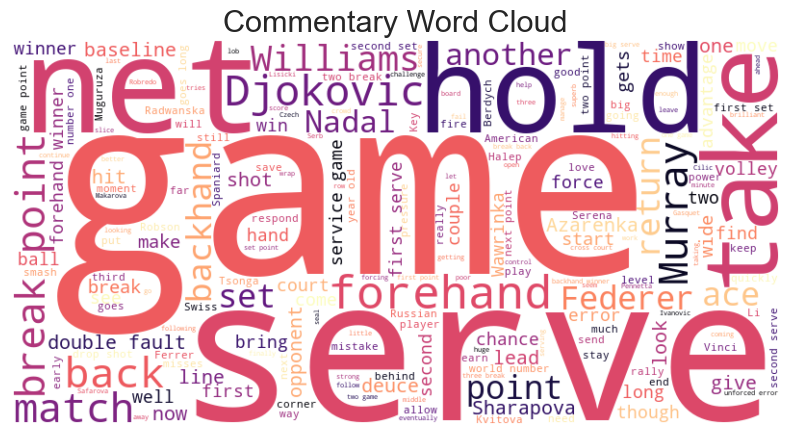

In [ ]:
# All Commentary Word Cloud
all_commentary_text = ' '.join(commentaries_df['commentary'])
all_commentary = all_commentary_text.split()

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400,
                      colormap=sns.color_palette("magma", as_cmap=True),
                      background_color='white').generate(all_commentary_text)

# Display the generated word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Commentary Word Cloud', fontsize = 22)
plt.show()

### Gender Specific Commentary Data Word Clouds

In [ ]:
# Remove gender specific words, player names, case, and punctuation

# filter into men's and women's data
commentary_m_df = commentaries_df[commentaries_df['gender'] == 'M']
commentary_f_df = commentaries_df[commentaries_df['gender'] == 'F']
male_commentary_text = ' '.join(commentary_m_df['commentary'])
female_commentary_text = ' '.join(commentary_f_df['commentary'])

# convert male and female words into lists
male_commentary_words = male_commentary_text.split()
female_commentary_words = female_commentary_text.split()

-------------------------------------------------------------------
Male Frequency Mean: 12.92087542087542
Female Frequency Mean: 13.947201689545935
Male Frequency STD: 61.39063640016673
Female Frequency STD: 66.50006836055333
-------------------------------------------------------------------
Male Word Count: 17306
Female Word Count: 17306
-------------------------------------------------------------------


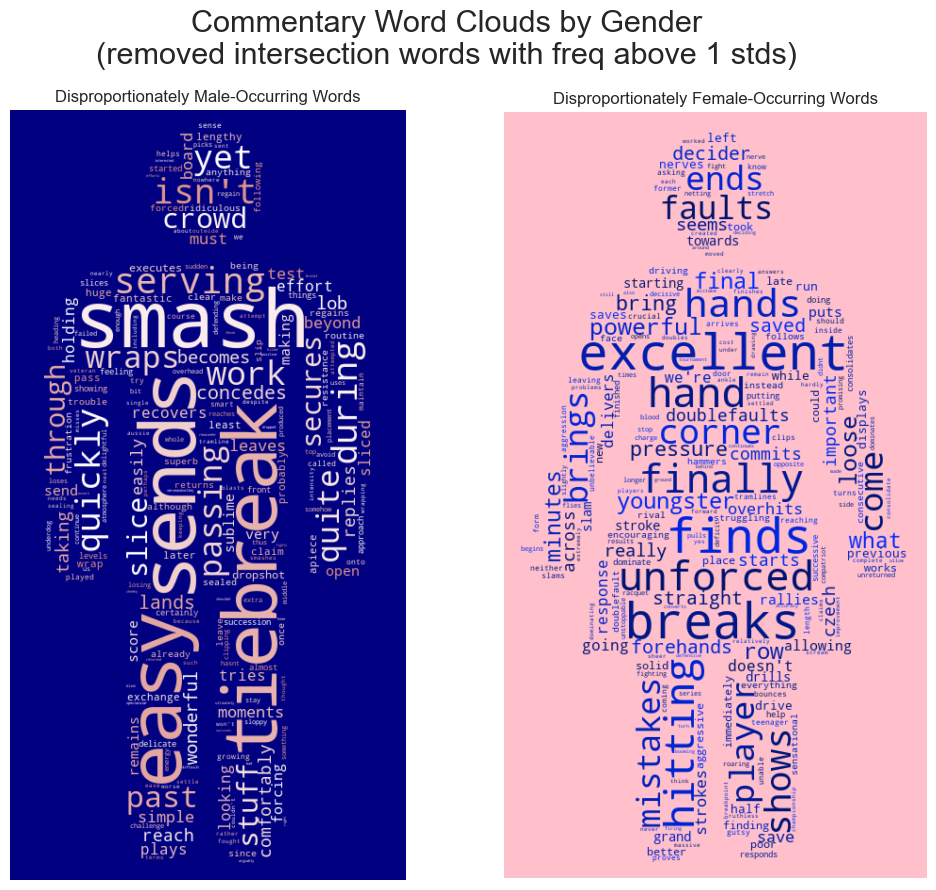

In [ ]:
comm_elements_1std, comm_counters_1std, comm_diff_lists_1std = \
get_diff_words(male_commentary_words, female_commentary_words, 1, 'Commentary')

-------------------------------------------------------------------
Male Frequency Mean: 12.92087542087542
Female Frequency Mean: 13.947201689545935
Male Frequency STD: 61.39063640016673
Female Frequency STD: 66.50006836055333
-------------------------------------------------------------------
Male Word Count: 7605
Female Word Count: 7605
-------------------------------------------------------------------


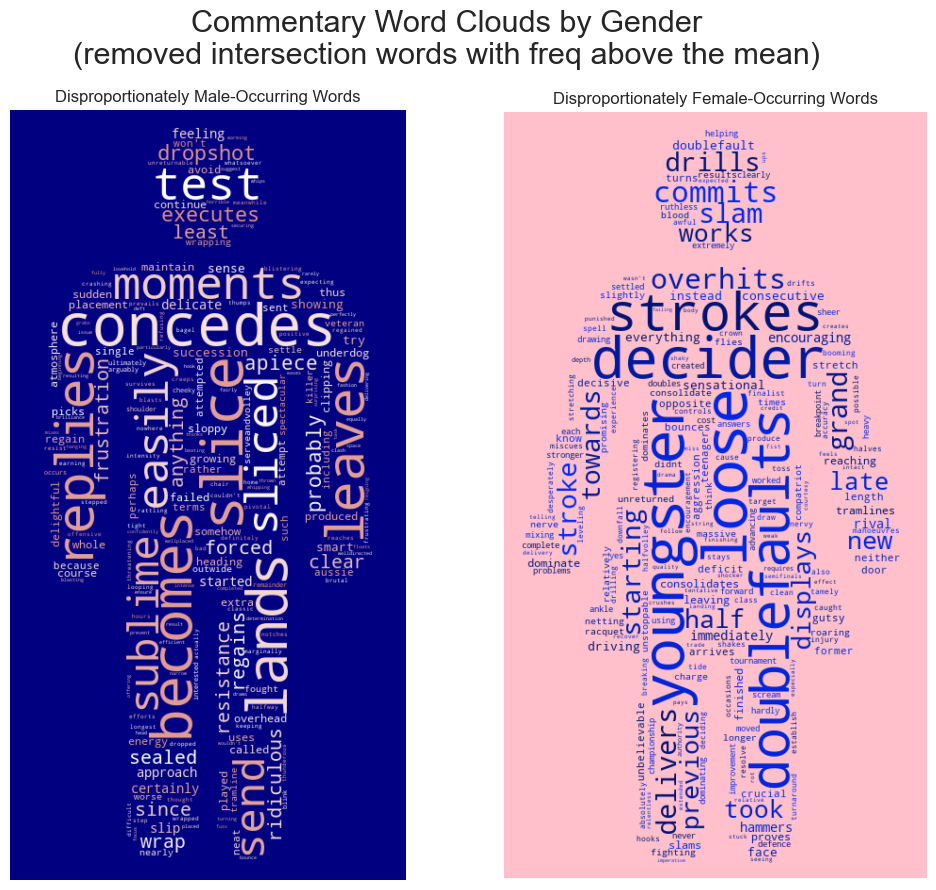

In [ ]:
comm_elements_0std, comm_counters_0std, comm_diff_lists_0std = \
get_diff_words(male_commentary_words, female_commentary_words, 0, 'Commentary')

-------------------------------------------------------------------
Male Frequency Mean: 12.92087542087542
Female Frequency Mean: 13.947201689545935
Male Frequency STD: 61.39063640016673
Female Frequency STD: 66.50006836055333
-------------------------------------------------------------------
Male Word Count: 1248
Female Word Count: 1248
-------------------------------------------------------------------


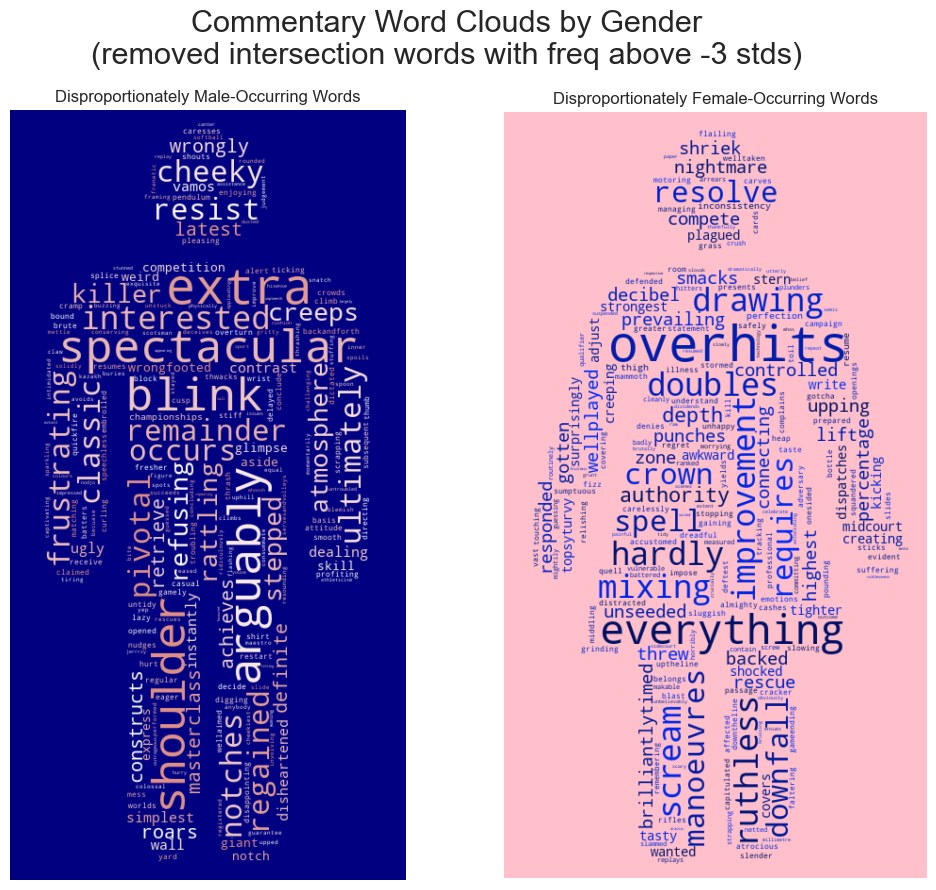

In [ ]:
comm_elements_neg_3std, comm_counters_neg_3std, comm_diff_lists_neg_3std = \
get_diff_words(male_commentary_words, female_commentary_words, -3, 'Commentary')

### Mean Word Characteristic Scores by Gender

After removing the intersection of words appearing more than one standard deviation from the mean in both the men's and women's commentary, we take the mean word characteristic score of the difference in counts to see how words more commonly used to describe men deviate from those more commonly used to describe women.

-------------------------------------------------------------------
Male Percentage of Words Included: 0.67
-------------------------------------------------------------------
Female Percentage of Words Included: 0.73
-------------------------------------------------------------------


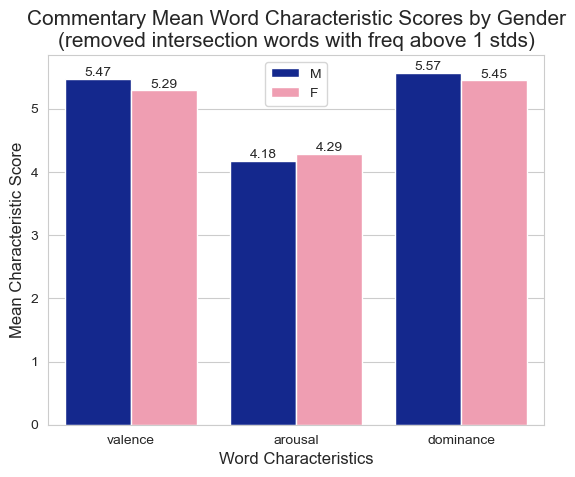

In [ ]:
male_triple, female_triple = get_avg_vad(male_commentary_words, female_commentary_words, 1, 'Commentary')

-------------------------------------------------------------------
Male Percentage of Words Included: 0.68
-------------------------------------------------------------------
Female Percentage of Words Included: 0.71
-------------------------------------------------------------------


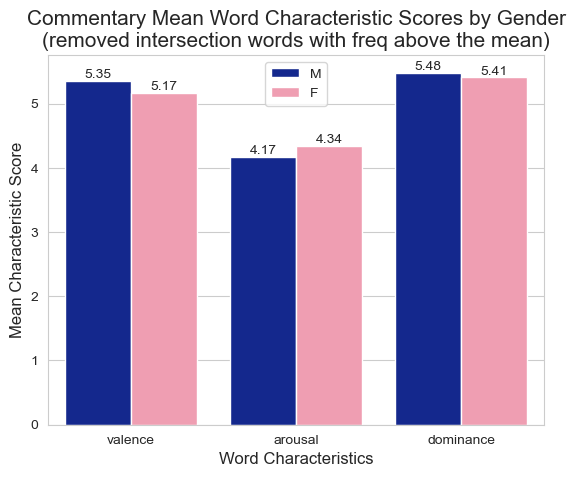

In [ ]:
male_triple, female_triple = get_avg_vad(male_commentary_words, female_commentary_words, 0, 'Commentary')

-------------------------------------------------------------------
Male Percentage of Words Included: 0.66
-------------------------------------------------------------------
Female Percentage of Words Included: 0.67
-------------------------------------------------------------------


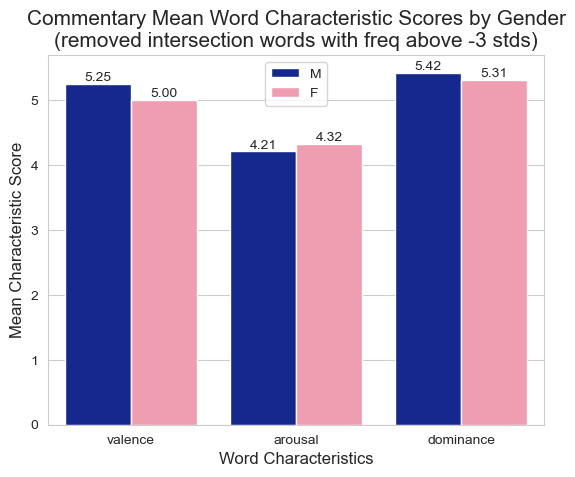

In [ ]:
male_triple, female_triple = get_avg_vad(male_commentary_words, female_commentary_words, -3, 'Commentary')

### Number of Commentaries for Male and Female Players

Combine players into a single column to explore how interviews are divided up

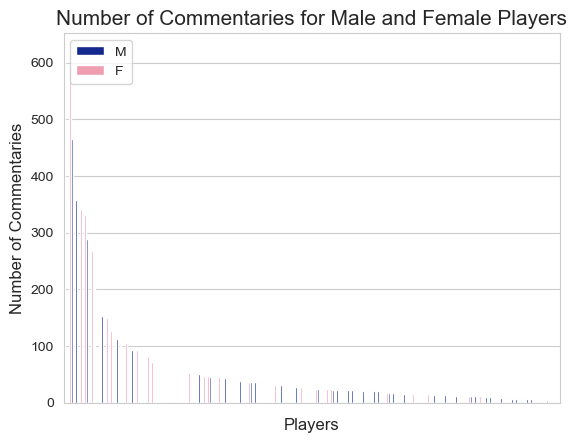

In [ ]:
# get two players columns
commentaries_df['player1'] = commentaries_df['scoreline'].apply(lambda x: x.split()[0].replace('*', ''))
commentaries_df['player2'] = commentaries_df['scoreline'].apply(lambda x: x.split()[len(x.split())-1].replace('*', ''))

# concat the dataframe with itself with one combined player column
df1 = commentaries_df
df1 = df1.drop(columns='player2')
df1 = df1.rename(columns={'player1':'player'})
df2 = commentaries_df
df2 = df2.drop(columns='player1')
df2 = df2.rename(columns={'player2':'player'})
frames = [df1, df2]
combined_commentaries_df = pd.concat(frames)
player_comm_feq_df = combined_commentaries_df.groupby(by=["player", "gender"])[['commentary']].count().reset_index()
player_comm_feq_df = player_comm_feq_df.sort_values(by='commentary', ascending=False)

# Commentaries per player by gender

# create custom colors array
colors = ["#001ba1", "#fc90ab"]
# set custom color palette
sns.set_palette(sns.color_palette(colors))

g1 = sns.barplot(data=player_comm_feq_df, x='player', y='commentary',
                 hue='gender', hue_order=['M', 'F'])
g1.tick_params(bottom=False)
g1.set(xticklabels=[])

# Adding labels and title
plt.xlabel('Players', fontsize=12)
plt.ylabel('Number of Commentaries', fontsize=12)
plt.title('Number of Commentaries for Male and Female Players', fontsize = 15)

# Adding a legend
plt.legend()

# Display the plot
plt.show()

### Players with the Most Commentaries

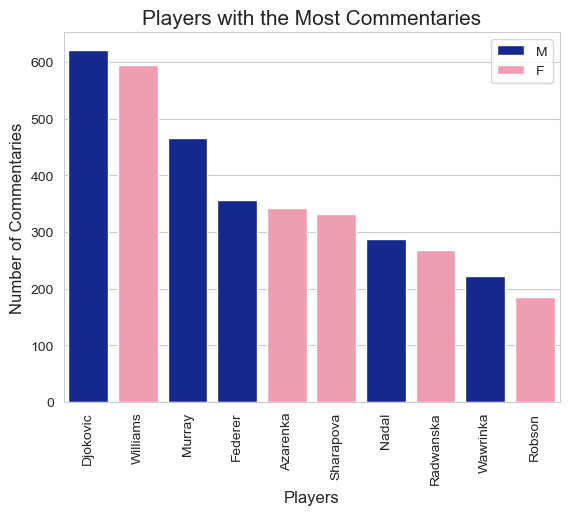

In [ ]:
# The players with the most commentaries (10 most)
top_player_comm_freq_df = player_comm_feq_df[0:10]

# create custom colors array
colors = ["#001ba1", "#fc90ab"]
# set custom color palette
sns.set_palette(sns.color_palette(colors))

g1 = sns.barplot(data=top_player_comm_freq_df, x='player', y='commentary', hue='gender',
                 dodge=False, hue_order=['M', 'F'])

# Adding labels and title
plt.xlabel('Players', fontsize=12)
plt.xticks(rotation=90)
plt.ylabel('Number of Commentaries', fontsize=12)
plt.title('Players with the Most Commentaries', fontsize=15)

# Adding a legend
plt.legend()

# Display the plot
plt.show()

### Commentary Word Count Distribution by Gender

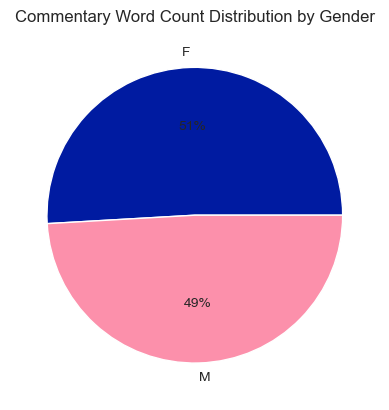

In [ ]:
# explore how the number of words are divded up among male/female commentaries
commentaries_df[['commentary', 'gender']]
commentaries_df['word_length'] = commentaries_df['commentary'].apply(lambda x: len(x))
gender_comm_word_counts_df = commentaries_df.groupby(by=['gender'])[['word_length']].sum().reset_index()

# plotting data on chart

# create custom colors array
colors = ["#001ba1", "#fc90ab"]
# set custom color palette
sns.set_palette(sns.color_palette(colors))

plt.pie(data=gender_comm_word_counts_df, x= 'word_length', labels='gender',
        autopct='%.0f%%')

plt.title('Commentary Word Count Distribution by Gender')

# displaying chart
plt.show()

## Transcripts Data

The dataset provide the full transcript (i.e. both questions and player responses), in the format of a JSON file:

	>>> import json
	>>> with open("transcripts_matchinfo.json", "r") as f:
	...		interviews = json.load(f)

	The following is an example for one transcript, with each field explained:

	>>> interview = interviews['0']
	0: {
		'QandA': ...  
			# Interview transcripts in the format of a list of question answer pairs.   
		'date': '2015-06-21',  # date the match is played
		'gender': 'M', # 'F' indicates women's singles match, 'M' indicates men's.
		'opponent': 'Kevin Anderson', # opponent in the match
			(available only if the opponent has at least one interview recorded in our dataset.)
  		'player': 'Andy Murray', # player being interviewed
  		'ranking': 3, # ranking of the player
  		'result': 1,  # 1 indicates the player being interviewed has won the match; 0 otherwise.
    		'stage': 'The Final', # stage of the tournament
  		'tournament': 'AEGON CHAMPIONSHIPS' # tournament name
		'tournament_type': 'ATP500', # type of the tournament, indicating tournament prestige.
	}

Note that:

- These questions and answers are transcribed exactly the way the journalists and the players put it; they are not further edited for grammatical correctness. There are, although relatively rarely, questions that are marked as (Off microphone.), (Indiscernible) or even (Translated from X) where X is a language other than English.
- Information about which journalist asked which question is not available.
- This transcript data does not contain all singles press conference transcripts available at ASAP sports as we only included transcripts that we could find corresponding match information for. In addition, since transcripts data and match results are matched by date and player last name, and we did not manually check for every match, it is possible to have a few matching errors.



In [ ]:
transcripts_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6467 entries, 0 to 6466
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   QandA            6467 non-null   object        
 1   ranking          6466 non-null   float64       
 2   tournament_type  6467 non-null   object        
 3   gender           6467 non-null   object        
 4   tournament       6467 non-null   object        
 5   player           6467 non-null   object        
 6   result           6467 non-null   int64         
 7   date             6467 non-null   datetime64[ns]
 8   stage            6467 non-null   object        
 9   opponent         6467 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(7)
memory usage: 555.8+ KB


### Interview Data by Tournament

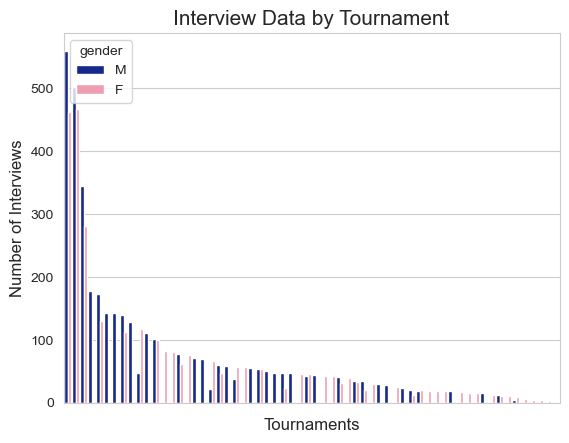

In [ ]:
tournaments_df = transcripts_df.groupby(by=['tournament', 'gender'])[['QandA']].count().reset_index()
tournaments_df = tournaments_df.sort_values(by='QandA', ascending=False)

# Tournament Frequencies
g1 = sns.barplot(data=tournaments_df, x='tournament', y='QandA', hue='gender',
                 hue_order=['M', 'F'])
g1.tick_params(bottom=False)
g1.set(xticklabels=[])

# Adding labels and title
plt.xlabel('Tournaments', fontsize=12)
plt.ylabel('Number of Interviews', fontsize=12)
plt.title('Interview Data by Tournament', fontsize = 15)

# Display the plot
plt.show()

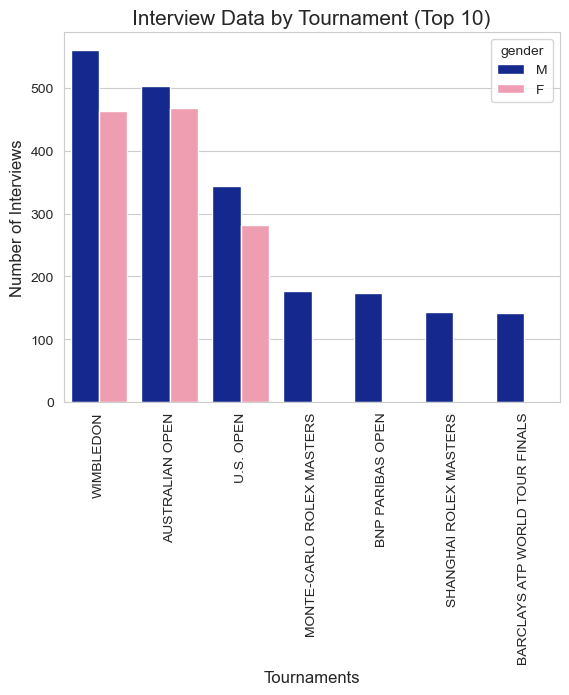

In [ ]:
# The players with the most commentaries (10 most)
tournaments_df = tournaments_df[0:10]

# create custom colors array
colors = ["#001ba1", "#fc90ab"]
# set custom color palette
sns.set_palette(sns.color_palette(colors))

g1 = sns.barplot(data=tournaments_df, x='tournament', y='QandA',
                 hue='gender', hue_order=['M', 'F'])

# Adding labels and title
plt.xlabel('Tournaments', fontsize=12)
plt.xticks(rotation=90)
plt.ylabel('Number of Interviews', fontsize=12)
plt.title('Interview Data by Tournament (Top 10)', fontsize = 15)

# Display the plot
plt.show()

### Get answers in terms of gender as two lists of words

In [ ]:
male_transcripts_df = transcripts_df[transcripts_df['gender'] == 'M']
female_transcripts_df = transcripts_df[transcripts_df['gender'] == 'F']

male_answers = []
for interview in male_transcripts_df['QandA'].to_list():
  for qna in interview:
    male_answers.append(qna[1])

female_answers = []
for interview in female_transcripts_df['QandA'].to_list():
  for qna in interview:
    female_answers.append(qna[1])

split_words = [words.split() for words in male_answers]
male_answers_words = [word for words in split_words for word in words]

split_words = [words.split() for words in female_answers]
female_answers_words = [word for words in split_words for word in words]

male_answers_text = ' '.join(male_answers_words)
female_answers_text = ' '.join(female_answers_words)
all_answers_text = male_answers_text + ' ' + female_answers_text

### Interview Answers Word Clouds by Gender

-------------------------------------------------------------------
Male Frequency Mean: 113.47878275570584
Female Frequency Mean: 93.21824855794442
Male Frequency STD: 1036.199686862758
Female Frequency STD: 825.5904596156403
-------------------------------------------------------------------
Male Word Count: 241449
Female Word Count: 241449
-------------------------------------------------------------------


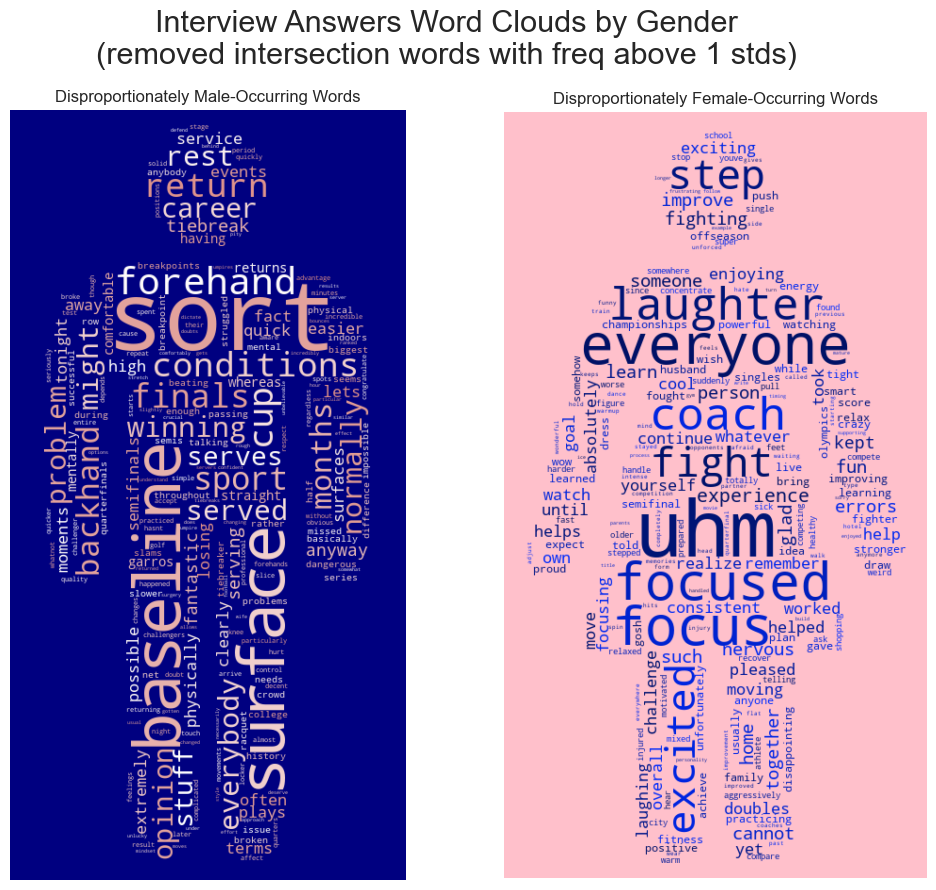

In [ ]:
ans_elements_1std, ans_counters_1std, ans_diff_lists_1std = \
get_diff_words(male_answers_words, female_answers_words, 1, 'Interview Answers')

-------------------------------------------------------------------
Male Frequency Mean: 113.47878275570584
Female Frequency Mean: 93.21824855794442
Male Frequency STD: 1036.199686862758
Female Frequency STD: 825.5904596156403
-------------------------------------------------------------------
Male Word Count: 70174
Female Word Count: 70174
-------------------------------------------------------------------


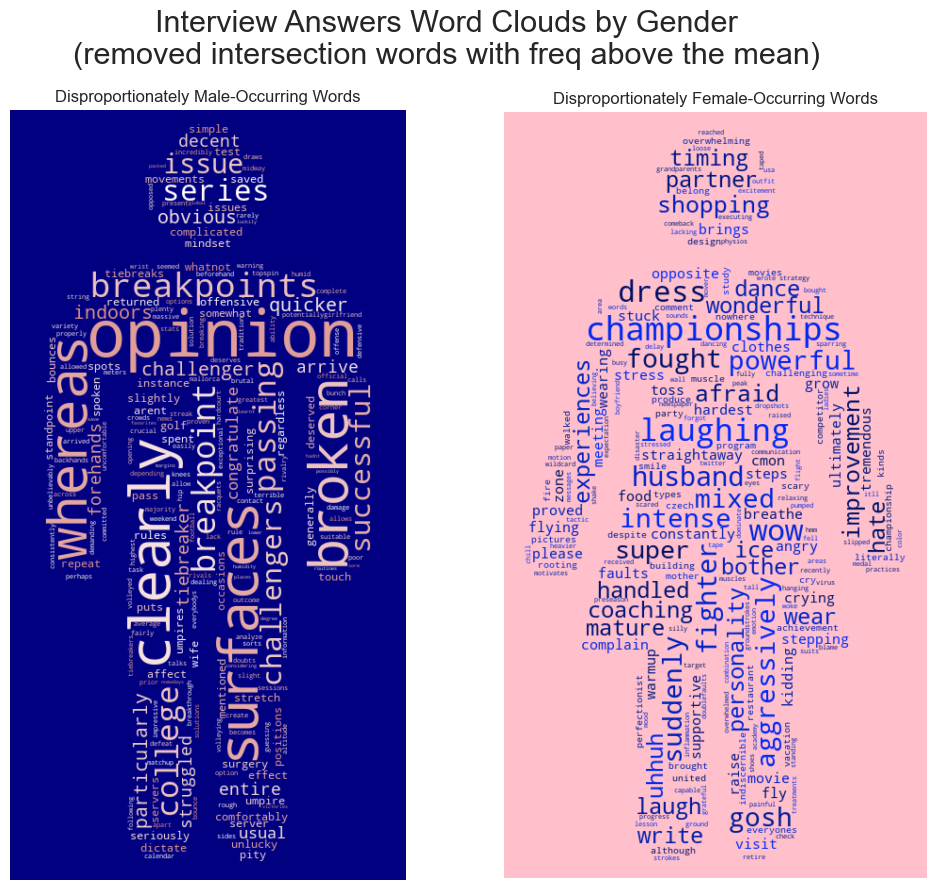

In [ ]:
ans_elements_0std, ans_counters_0std, ans_diff_lists_0std = \
get_diff_words(male_answers_words, female_answers_words, 0, 'Interview Answers')

-------------------------------------------------------------------
Male Frequency Mean: 113.47878275570584
Female Frequency Mean: 93.21824855794442
Male Frequency STD: 1036.199686862758
Female Frequency STD: 825.5904596156403
-------------------------------------------------------------------
Male Word Count: 4007
Female Word Count: 4007
-------------------------------------------------------------------


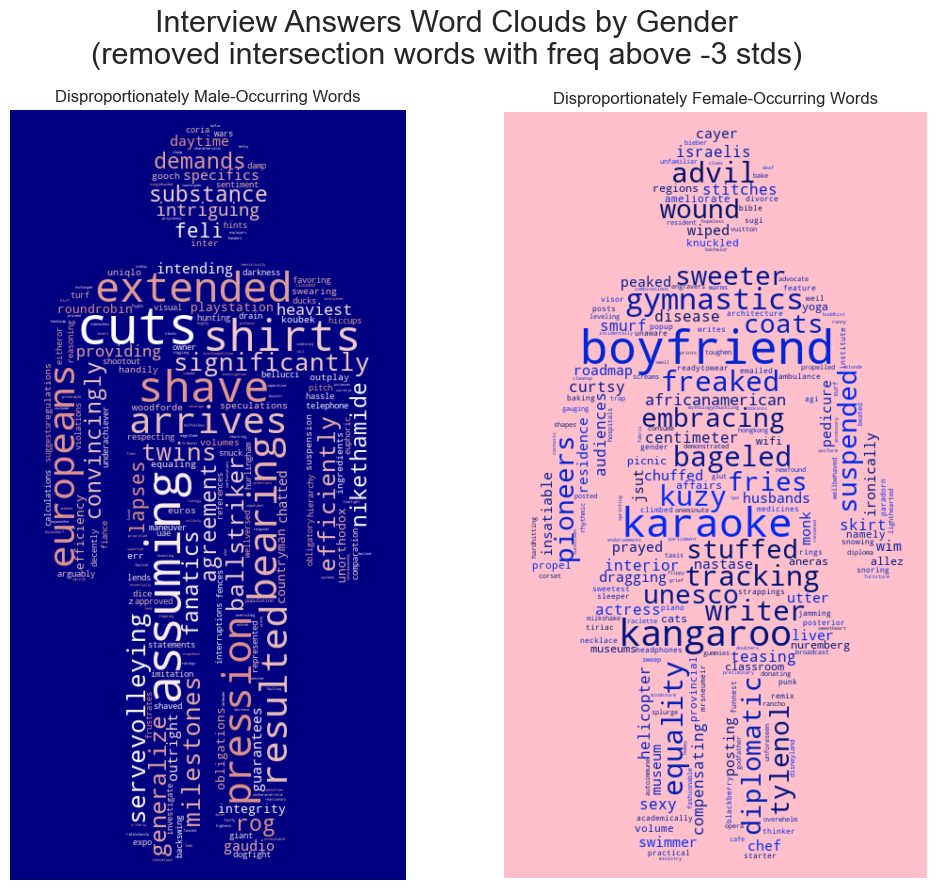

In [ ]:
ans_elements_neg_3std, ans_counters_neg_3std, ans_diff_lists_neg_3std = \
get_diff_words(male_answers_words, female_answers_words, -3, 'Interview Answers')

### Interview Answers Word Characteristic Scores by Gender

After removing the intersection of words appearing more than one standard deviation from the mean in both the men's and women's commentary, we take the mean word characteristic score of the difference in counts to see how words more commonly used to describe men deviate from those more commonly used to describe women.

-------------------------------------------------------------------
Male Percentage of Words Included: 0.69
-------------------------------------------------------------------
Female Percentage of Words Included: 0.72
-------------------------------------------------------------------


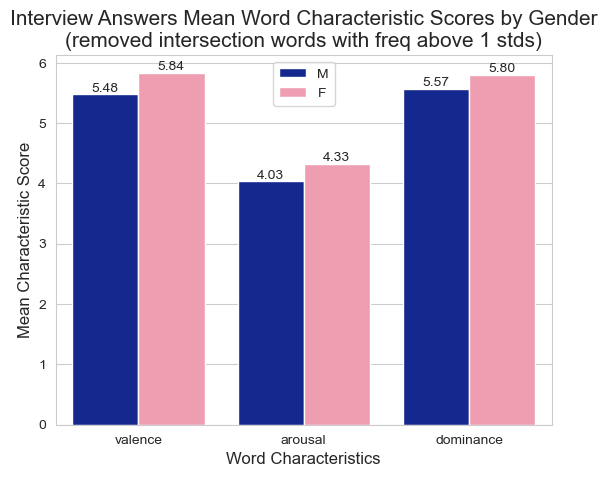

In [ ]:
male_triple, female_triple = get_avg_vad(male_answers_words, female_answers_words, 1, 'Interview Answers')

-------------------------------------------------------------------
Male Percentage of Words Included: 0.71
-------------------------------------------------------------------
Female Percentage of Words Included: 0.72
-------------------------------------------------------------------


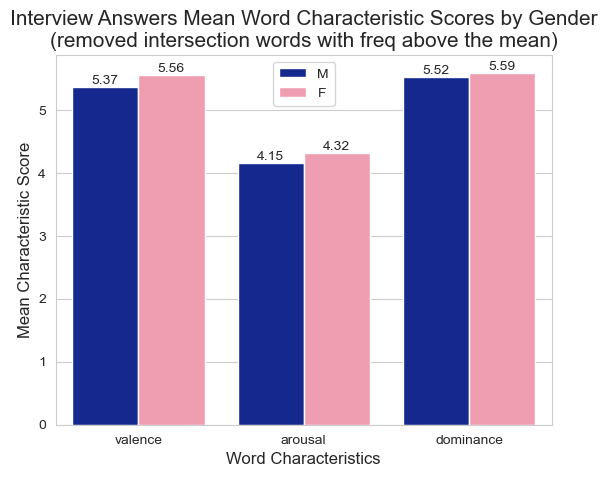

In [ ]:
male_triple, female_triple = get_avg_vad(male_answers_words, female_answers_words, 0, 'Interview Answers')

-------------------------------------------------------------------
Male Percentage of Words Included: 0.54
-------------------------------------------------------------------
Female Percentage of Words Included: 0.53
-------------------------------------------------------------------


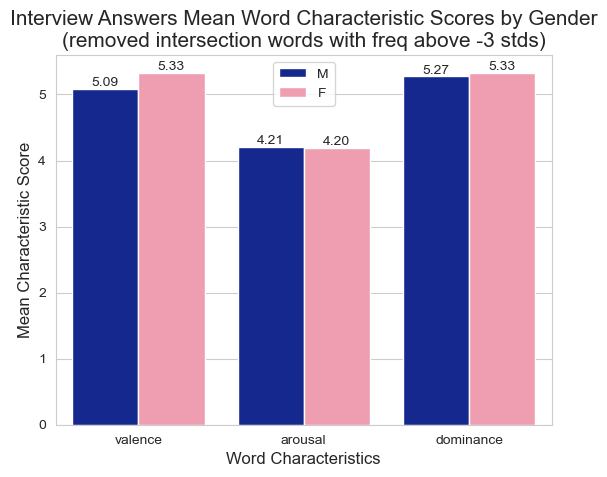

In [ ]:
male_triple, female_triple = get_avg_vad(male_answers_words, female_answers_words, -3, 'Interview Answers')

# Establishing Baselines

## Simple Baseline: Similar top words for male & female tennis players.

Our simple baseline will be a similarity score between the top words for male & female tennis players. To calculate this, we will extract the 30 most common words for both groups and then compare the number of those top 30 words that are related to tennis. This is a similar simple baseline to the one established early in the paper we aim to recreate.

In [ ]:
import re
from collections import Counter
from nltk import ngrams
from nltk.corpus import stopwords
import nltk

# Download the stopwords resource
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kylesullivan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
def get_top_30_sorted_tuples(diff_list):
    # Sort the list of tuples in descending order based on the second element (count)
    sorted_list = sorted(diff_list, key=lambda x: x[1], reverse=True)

    # Return the first 30 elements
    top_30 = sorted_list[:30]

    return top_30

Use chatGPT to first develop a list of tennis-related words. Then, manually add to this list through research from a dictionary etc. The Paper 0 methodology involved actually using the commentary data to determine tennis-related words. In this simple baseline, we will use this list as our determinant of tennis-related words.

ChatGPT prompt:

```
# You are a tennis commentator for the world's most elite athletes.
# We are building a language model to understand tennis commentary better.
# Give me a list of all the words related to tennis that we should consider
# when building a model to detect tennis-related words in commentary and tennis player post-match, pre-match interviews.
```



In [ ]:
tennis_related_words = [
    # Player-Specific Terms
    "player", "singles", "doubles", "opponent", "contender", "challenger", "world", "no", "1", "secures", "hands", "mistakes", "fault", "faults"

    # Match and Game Terms
    "match", "game", "set", "point", "tiebreak", "break", "serve", "volley", "rally", "net", "baseline", "advantage", "deuce", "game", "set", "match", "breaks", "hitting"

    # Tournament and Event Terms
    "grand", "slam", "atp", "wta", "major", "championship", "slam", "masters", "davis", "cup", "fed", "finals", "qualifier", "wildcard",

    # Court and Surface Terms
    "court", "surface", "clay", "grass", "hardcourt", "indoor", "outdoor", "plexicushion", "decoturf", "lands", "sends"

    # Skill and Technique Terms
    "forehand", "forehands", "backhand", "serve", "serving", "volley", "slice", "topspin", "drop", "lob", "smash", "approach", "passing", "spin", "power", "lands", "smash"

    # Equipment and Gear Terms
    "racket", "strings", "grip", "tennis", "ball", "racquet", "bag", "court", "shoes", "apparel", "gear", "kit",

    # Officials and Rules Terms
    "umpire", "chair", "umpire", "line", "judge", "hawk-eye", "challenge", "code", "violation", "let", "net", "cord", "foot", "fault", "double", "fault",

    # Ranking and Seeding Terms
    "ranking", "seed", "world", "number", "one", "top", "seed", "wildcard", "challenger", "qualifier", "round-robin", "concedes"

    # Performance and Strategy Terms
    "ace", "double", "fault", "strategy", "tactics", "mental", "toughness", "fitness", "endurance", "stamina", "speed", "precision", "decider",

    # Achievements and Records Terms
    "grand", "slam", "title", "career", "slam", "golden", "slam", "record", "milestone", "hall", "fame", "winning", "streak", "crowd",

    # Interview and Commentary Terms
    "interview", "commentator", "recap", "prediction", "post-match", "pre-match"
]

# Test print to verify the list
print(tennis_related_words)


['player', 'singles', 'doubles', 'opponent', 'contender', 'challenger', 'world', 'no', '1', 'secures', 'hands', 'mistakes', 'fault', 'faultsmatch', 'game', 'set', 'point', 'tiebreak', 'break', 'serve', 'volley', 'rally', 'net', 'baseline', 'advantage', 'deuce', 'game', 'set', 'match', 'breaks', 'hittinggrand', 'slam', 'atp', 'wta', 'major', 'championship', 'slam', 'masters', 'davis', 'cup', 'fed', 'finals', 'qualifier', 'wildcard', 'court', 'surface', 'clay', 'grass', 'hardcourt', 'indoor', 'outdoor', 'plexicushion', 'decoturf', 'lands', 'sendsforehand', 'forehands', 'backhand', 'serve', 'serving', 'volley', 'slice', 'topspin', 'drop', 'lob', 'smash', 'approach', 'passing', 'spin', 'power', 'lands', 'smashracket', 'strings', 'grip', 'tennis', 'ball', 'racquet', 'bag', 'court', 'shoes', 'apparel', 'gear', 'kit', 'umpire', 'chair', 'umpire', 'line', 'judge', 'hawk-eye', 'challenge', 'code', 'violation', 'let', 'net', 'cord', 'foot', 'fault', 'double', 'fault', 'ranking', 'seed', 'world',

In [ ]:
top_30_female = get_top_30_sorted_tuples(comm_diff_lists_1std[1].most_common())

In [ ]:
top_30_male = get_top_30_sorted_tuples(comm_diff_lists_1std[0].most_common())

In [ ]:
def calculate_tennis_simple_percentage(diff_list, tennis_related_words):
    # Convert tennis_related_words to a set for faster membership testing
    tennis_related_set = set(tennis_related_words)

    # Calculate the total number of words in diff_list
    total_words = sum(count for _, count in diff_list)

    # Calculate the number of tennis-related words in diff_list
    tennis_related_count = sum(count for word, count in diff_list if word.lower() in tennis_related_set)

    # Calculate the percentage of tennis-related words
    percentage_tennis_related = (tennis_related_count / total_words) * 100 if total_words > 0 else 0

    return percentage_tennis_related

In [ ]:
male_question_perc_tennis_top30 = calculate_tennis_simple_percentage(top_30_male, tennis_related_words)
male_question_perc_tennis_top30

32.58426966292135

In [ ]:
female_question_perc_tennis_top_30 = calculate_tennis_simple_percentage(top_30_female, tennis_related_words)
female_question_perc_tennis_top_30

21.164021164021165

This serves as a simple baseline. We see that men have more words than women that are directly tennis related when looking at the top 30 tokens for questions asked to both women and men.

## Complex Baseline: N-Gram Perplexities

This baseline is the baseline ultimately used by Paper 0; it is a calculation of perplexity where low perplexity for a question indicates a lower bias. The paper used bigrams. We go a step further, using trigrams, followed by an LSTM model.

## Language Models

N-Gram Results Dataframe

In [ ]:
questions_df_cleaned = pd.read_csv('/content/question_perplexities.csv')
questions_df_cleaned

Unnamed: 0             player gender  result  \
0               0        andy murray      M       1   
1               1        andy murray      M       1   
2               2        andy murray      M       1   
3               3        andy murray      M       1   
4               4        andy murray      M       1   
...           ...                ...    ...     ...   
81928       81928  victoria azarenka      F       1   
81929       81929  victoria azarenka      F       1   
81930       81930  victoria azarenka      F       1   
81931       81931  victoria azarenka      F       1   
81932       81932  victoria azarenka      F       1   

                                               questions  ranking  \
0      That last set seemed like a faultless performa...      3.0   
1      Did playing the semifinal, finishing that off ...      3.0   
2      Is that difficult mentally as much as physical...      3.0   
3      You said on TV I think you said you felt bette...      3.0   
4      The last time that you won this tournament you...      3.0   
...                                                  ...      ...   
81928  Tennis is sometimes described as a profession,...      8.0   
81929  Last year's champion is really into art. Who a...      8.0   
81930  You touched on your support of Argentina. How ...      8.0   
81931     Do you think Wimbledon does that to an extent?      8.0   
81932  What goes through your mind when you watch Messi?      8.0   

                                        bigram_questions  \
0      [('<s>', 'that'), ('that', 'last'), ('last', '...   
1      [('<s>', 'did'), ('did', 'playing'), ('playing...   
2      [('<s>', 'is'), ('is', 'that'), ('that', 'diff...   
3      [('<s>', 'you'), ('you', 'said'), ('said', 'on...   
4      [('<s>', 'the'), ('the', 'last'), ('last', 'ti...   
...                                                  ...   
81928  [('<s>', 'tennis'), ('tennis', 'is'), ('is', '...   
81929  [('<s>', 'last'), ('last', 'year'), ('year', "...   
81930  [('<s>', 'you'), ('you', 'touched'), ('touched...   
81931  [('<s>', 'do'), ('do', 'you'), ('you', 'think'...   
81932  [('<s>', 'what'), ('what', 'goes'), ('goes', '...   

       adi_bigram_perplexity  lap_bigram_perplexity  sb_bigram_perplexity  \
0                 834.621616             982.597397            657.978210   
1                 339.545920             697.892007            214.664696   
2                 348.509815             607.945086            283.513724   
3                 622.622800            1265.064041            515.982747   
4                 313.505197             709.686402            256.044067   
...                      ...                    ...                   ...   
81928             214.605174             605.931048            159.598033   
81929             147.161370             669.610697            102.707659   
81930             199.928943             454.441263            164.995255   
81931            1510.605773            1983.842022           1089.078060   
81932            1887.707216            1333.391479           1532.818714   

       ...  sb_trigram_perplexity  kni_trigram_perplexity  \
0      ...             466.777035             1246.481854   
1      ...             407.549804             1507.138443   
2      ...             217.397702              434.769204   
3      ...             976.788094             2375.957457   
4      ...             189.922261              304.966523   
...    ...                    ...                     ...   
81928  ...             187.566341              457.877750   
81929  ...              82.089927              199.003488   
81930  ...             175.976660              412.267966   
81931  ...            1272.192910             3224.944131   
81932  ...            1764.786365             3746.894403   

       adi_m_trigram_perplexity  lap_m_trigram_perplexity  \
0                    394.459984               1342.143033   
1               

### Tokenize Commentary Data

In [ ]:
# all commentary tokens
tok_all_commentary = [word_tokenize(sent) for sent in sent_tokenize(all_commentary_text.lower())]

# get all male commentary tokens
tok_male_commentary = [word_tokenize(sent) for sent in sent_tokenize(male_commentary_text.lower())]

# get all female commentary tokens
tok_female_commentary = [word_tokenize(sent) for sent in sent_tokenize(female_commentary_text.lower())]

### Bigrams

##### Construct Bigrams

Get bigrams for questions, where each question is a list index

In [ ]:
q_lst = questions_df_cleaned['questions'].values.tolist()
bigram_q_lst = [[lst for sublst in [list(bigrams(pad_both_ends(word_tokenize(sent), n=2))) for sent in sent_tokenize(question.lower())] for lst in sublst] for question in q_lst]

bigram_q_lst_cleaned = []
grams = bigram_q_lst
for gram in grams:
    temp = []
    length = len(gram) - 1
    for index, tup in enumerate(gram):
        if gram[index][1] == '</s>':
            pass
        elif index < length and gram[index+1][1] == '</s>':
            temp.append(tuple([gram[index][0], '</s>']))
        else:
            temp.append(tuple([gram[index][0], gram[index][1]]))
    bigram_q_lst_cleaned.append(temp)

questions_df_cleaned['bigram_questions'] = bigram_q_lst_cleaned

Remove the end of sentence punctuation, since the probability of "/s" following ".", "?", and "!" are all nearly 100%. This skews short sentence perplexities towards 0.

In [ ]:
tok_all_commentary_cleaned = [sent[0:-1] for sent in tok_all_commentary]
tok_male_commentary_cleaned = [sent[0:-1] for sent in tok_male_commentary]
tok_female_commentary_cleaned = [sent[0:-1] for sent in tok_female_commentary]

#### Bi-gram Model Trained on All Commentary Data

##### Construct Models

We are commenting out this code along with a few other blocks from this section which were used to run the bigram models. They take a long time to complete. Instead, we loaded in the results directly.

In [ ]:
# vocab = Vocabulary(padded_everygram_pipeline(2, tok_all_commentary_cleaned)[1], unk_cutoff=2)
# adi_model2 = AbsoluteDiscountingInterpolated(2, vocabulary=vocab)
# adi_model2.fit(padded_everygram_pipeline(2, tok_all_commentary_cleaned)[0], vocab)
# print(len(adi_model2.vocab))
#
# vocab = Vocabulary(padded_everygram_pipeline(2, tok_all_commentary_cleaned)[1], unk_cutoff=2)
# lap_model2 = Laplace(2, vocabulary=vocab)
# lap_model2.fit(padded_everygram_pipeline(2, tok_all_commentary_cleaned)[0], vocab)
# print(len(lap_model2.vocab))
#
# vocab = Vocabulary(padded_everygram_pipeline(2, tok_all_commentary_cleaned)[1], unk_cutoff=2)
# kni_model2 = KneserNeyInterpolated(2, vocabulary=vocab)
# kni_model2.fit(padded_everygram_pipeline(2, tok_all_commentary_cleaned)[0], vocab)
# print(len(kni_model2.vocab))
#
# vocab = Vocabulary(padded_everygram_pipeline(2, tok_all_commentary_cleaned)[1], unk_cutoff=2)
# sb_model2 = StupidBackoff(order=2, vocabulary=vocab)
# sb_model2.fit(padded_everygram_pipeline(2, tok_all_commentary_cleaned)[0], vocab)
# print(len(sb_model2.vocab))

Get Question Perplexities

In [ ]:
# questions_df_cleaned['adi_m_bigram_perplexity'] = [adi_m_model2.perplexity(q) for q in bigram_q_lst_cleaned]
# questions_df_cleaned['lap_m_bigram_perplexity'] = [lap_m_model2.perplexity(q) for q in bigram_q_lst_cleaned]
# questions_df_cleaned['sb_m_bigram_perplexity'] = [sb_m_model2.perplexity(q) for q in bigram_q_lst_cleaned]
# questions_df_cleaned['kni_m_bigram_perplexity'] = [kni_m_model2.perplexity(q) for q in bigram_q_lst_cleaned]
#
# questions_df_cleaned.to_csv('q_df.csv')

##### Bigram Mann-Whitney U Rank Test

###### All Players

In [ ]:
print('LAP:')
lap_bigram_q_lst_p_val = calc_perp(questions_df_cleaned[(questions_df_cleaned['gender'] == 'M')]['lap_bigram_perplexity'], questions_df_cleaned[(questions_df_cleaned['gender'] == 'F')]['lap_bigram_perplexity'])
print('----------------------------------------------------------------------')
print('ADI:')
adi_bigram_q_lst_p_val = calc_perp(questions_df_cleaned[(questions_df_cleaned['gender'] == 'M')]['adi_bigram_perplexity'], questions_df_cleaned[(questions_df_cleaned['gender'] == 'F')]['adi_bigram_perplexity'])
print('----------------------------------------------------------------------')
print('SB:')
sb_bigram_q_lst_p_val = calc_perp(questions_df_cleaned[(questions_df_cleaned['gender'] == 'M')]['sb_bigram_perplexity'], questions_df_cleaned[(questions_df_cleaned['gender'] == 'F')]['sb_bigram_perplexity'])
print('----------------------------------------------------------------------')
print('KNI:')
kni_bigram_q_lst_p_val = calc_perp(questions_df_cleaned[(questions_df_cleaned['gender'] == 'M')]['kni_bigram_perplexity'], questions_df_cleaned[(questions_df_cleaned['gender'] == 'F')]['kni_bigram_perplexity'])
print('----------------------------------------------------------------------')

LAP:
Male Perplexity:           915.8
Female Perplexity:         916.9
P-value:                   0.116
Statistically Significant: False 
----------------------------------------------------------------------
ADI:
Male Perplexity:           483.7
Female Perplexity:         486.0
P-value:                   0.72
Statistically Significant: False 
----------------------------------------------------------------------
SB:
Male Perplexity:           364.8
Female Perplexity:         365.5
P-value:                   0.921
Statistically Significant: False 
----------------------------------------------------------------------
KNI:
Male Perplexity:           925.5
Female Perplexity:         928.4
P-value:                   0.981
Statistically Significant: False 
----------------------------------------------------------------------


###### Top 10

In [ ]:
print('LAP:')
lap_bigram_t10_q_lst_p_val = calc_perp(questions_df_cleaned[(questions_df_cleaned['gender'] == 'M') & (questions_df_cleaned['ranking'] <= 10)]['lap_bigram_perplexity'], questions_df_cleaned[(questions_df_cleaned['gender'] == 'F') & (questions_df_cleaned['ranking'] <= 10)]['lap_bigram_perplexity'])
print('----------------------------------------------------------------------')
print('ADI:')
adi_bigram_t10_q_lst_p_val = calc_perp(questions_df_cleaned[(questions_df_cleaned['gender'] == 'M') & (questions_df_cleaned['ranking'] <= 10)]['adi_bigram_perplexity'], questions_df_cleaned[(questions_df_cleaned['gender'] == 'F') & (questions_df_cleaned['ranking'] <= 10)]['adi_bigram_perplexity'])
print('----------------------------------------------------------------------')
print('SB:')
sb_bigram_t10_q_lst_p_val = calc_perp(questions_df_cleaned[(questions_df_cleaned['gender'] == 'M') & (questions_df_cleaned['ranking'] <= 10)]['sb_bigram_perplexity'], questions_df_cleaned[(questions_df_cleaned['gender'] == 'F') & (questions_df_cleaned['ranking'] <= 10)]['sb_bigram_perplexity'])
print('----------------------------------------------------------------------')
print('KNI:')
kni_bigram_t10_q_lst_p_val = calc_perp(questions_df_cleaned[(questions_df_cleaned['gender'] == 'M') & (questions_df_cleaned['ranking'] <= 10)]['kni_bigram_perplexity'], questions_df_cleaned[(questions_df_cleaned['gender'] == 'F') & (questions_df_cleaned['ranking'] <= 10)]['kni_bigram_perplexity'])
print('----------------------------------------------------------------------')

LAP:
Male Perplexity:           907.0
Female Perplexity:         905.1
P-value:                   0.442
Statistically Significant: False 
----------------------------------------------------------------------
ADI:
Male Perplexity:           474.5
Female Perplexity:         474.8
P-value:                   0.965
Statistically Significant: False 
----------------------------------------------------------------------
SB:
Male Perplexity:           357.0
Female Perplexity:         358.0
P-value:                   0.749
Statistically Significant: False 
----------------------------------------------------------------------
KNI:
Male Perplexity:           897.5
Female Perplexity:         896.2
P-value:                   0.981
Statistically Significant: False 
----------------------------------------------------------------------


###### Not Top 10

In [ ]:
print('LAP:')
lap_bigram_low_rank_q_lst_p_val = calc_perp(questions_df_cleaned[(questions_df_cleaned['gender'] == 'M') & (questions_df_cleaned['ranking'] > 10)]['lap_bigram_perplexity'], questions_df_cleaned[(questions_df_cleaned['gender'] == 'F') & (questions_df_cleaned['ranking'] > 10)]['lap_bigram_perplexity'])
print('----------------------------------------------------------------------')
print('ADI:')
adi_bigram_low_rank_q_lst_p_val = calc_perp(questions_df_cleaned[(questions_df_cleaned['gender'] == 'M') & (questions_df_cleaned['ranking'] > 10)]['adi_bigram_perplexity'], questions_df_cleaned[(questions_df_cleaned['gender'] == 'F') & (questions_df_cleaned['ranking'] > 10)]['adi_bigram_perplexity'])
print('----------------------------------------------------------------------')
print('SB:')
sb_bigram_low_rank_q_lst_p_val = calc_perp(questions_df_cleaned[(questions_df_cleaned['gender'] == 'M') & (questions_df_cleaned['ranking'] > 10)]['sb_bigram_perplexity'], questions_df_cleaned[(questions_df_cleaned['gender'] == 'F') & (questions_df_cleaned['ranking'] > 10)]['sb_bigram_perplexity'])
print('----------------------------------------------------------------------')
print('KNI:')
kni_bigram_low_rank_q_lst_p_val = calc_perp(questions_df_cleaned[(questions_df_cleaned['gender'] == 'M') & (questions_df_cleaned['ranking'] > 10)]['kni_bigram_perplexity'], questions_df_cleaned[(questions_df_cleaned['gender'] == 'F') & (questions_df_cleaned['ranking'] > 10)]['kni_bigram_perplexity'])
print('----------------------------------------------------------------------')

LAP:
Male Perplexity:           925.7
Female Perplexity:         929.1
P-value:                   0.191
Statistically Significant: False 
----------------------------------------------------------------------
ADI:
Male Perplexity:           494.1
Female Perplexity:         497.4
P-value:                   0.697
Statistically Significant: False 
----------------------------------------------------------------------
SB:
Male Perplexity:           373.7
Female Perplexity:         373.1
P-value:                   0.982
Statistically Significant: False 
----------------------------------------------------------------------
KNI:
Male Perplexity:           957.2
Female Perplexity:         961.5
P-value:                   0.922
Statistically Significant: False 
----------------------------------------------------------------------


#### Bi-gram Model Trained on Male Commentary Data

##### Construct Models

In [ ]:
vocab = Vocabulary(padded_everygram_pipeline(2, tok_male_commentary_cleaned)[1], unk_cutoff=2)
adi_m_model2 = AbsoluteDiscountingInterpolated(2, vocabulary = vocab)
adi_m_model2.fit(padded_everygram_pipeline(2, tok_male_commentary_cleaned)[0], vocab)
print(len(adi_m_model2.vocab))

vocab = Vocabulary(padded_everygram_pipeline(2, tok_male_commentary_cleaned)[1], unk_cutoff=2)
lap_m_model2 = Laplace(2, vocabulary = vocab)
lap_m_model2.fit(padded_everygram_pipeline(2, tok_male_commentary_cleaned)[0], vocab)
print(len(lap_m_model2.vocab))

vocab = Vocabulary(padded_everygram_pipeline(2, tok_male_commentary_cleaned)[1], unk_cutoff=2)
kni_m_model2 = KneserNeyInterpolated(2, vocabulary = vocab)
kni_m_model2.fit(padded_everygram_pipeline(2, tok_male_commentary_cleaned)[0], vocab)
print(len(kni_m_model2.vocab))

vocab = Vocabulary(padded_everygram_pipeline(2, tok_male_commentary_cleaned)[1], unk_cutoff=2)
sb_m_model2 = StupidBackoff(order=2, vocabulary = vocab)
sb_m_model2.fit(padded_everygram_pipeline(2, tok_male_commentary_cleaned)[0], vocab)
print(len(sb_m_model2.vocab))

2364
2364
2364
2364


##### Question Perplexities

In [ ]:
# questions_df_cleaned['adi_m_bigram_perplexity'] = [adi_m_model2.perplexity(q) for q in bigram_q_lst_cleaned]
# questions_df_cleaned['lap_m_bigram_perplexity'] = [lap_m_model2.perplexity(q) for q in bigram_q_lst_cleaned]
# questions_df_cleaned['sb_m_bigram_perplexity'] = [sb_m_model2.perplexity(q) for q in bigram_q_lst_cleaned]
# questions_df_cleaned['kni_m_bigram_perplexity'] = [kni_m_model2.perplexity(q) for q in bigram_q_lst_cleaned]
#
# questions_df_cleaned.to_csv('q_df.csv')

##### Bigram Mann-Whitney U Rank Test

###### All Players

In [ ]:
print('LAP:')
lap_m_bigram_q_lst_p_val = calc_perp(questions_df_cleaned[(questions_df_cleaned['gender'] == 'M')]['lap_m_bigram_perplexity'], questions_df_cleaned[(questions_df_cleaned['gender'] == 'F')]['lap_m_bigram_perplexity'])
print('----------------------------------------------------------------------')
print('ADI:')
adi_m_bigram_q_lst_p_val = calc_perp(questions_df_cleaned[(questions_df_cleaned['gender'] == 'M')]['adi_m_bigram_perplexity'], questions_df_cleaned[(questions_df_cleaned['gender'] == 'F')]['adi_m_bigram_perplexity'])
print('----------------------------------------------------------------------')
print('SB:')
sb_m_bigram_q_lst_p_val = calc_perp(questions_df_cleaned[(questions_df_cleaned['gender'] == 'M')]['sb_m_bigram_perplexity'], questions_df_cleaned[(questions_df_cleaned['gender'] == 'F')]['sb_m_bigram_perplexity'])
print('----------------------------------------------------------------------')
print('KNI:')
kni_m_bigram_q_lst_p_val = calc_perp(questions_df_cleaned[(questions_df_cleaned['gender'] == 'M')]['kni_m_bigram_perplexity'], questions_df_cleaned[(questions_df_cleaned['gender'] == 'F')]['kni_m_bigram_perplexity'])
print('----------------------------------------------------------------------')

LAP:
Male Perplexity:           741.3
Female Perplexity:         738.3
P-value:                   0.931
Statistically Significant: False 
----------------------------------------------------------------------
ADI:
Male Perplexity:           391.7
Female Perplexity:         389.6
P-value:                   0.608
Statistically Significant: False 
----------------------------------------------------------------------
SB:
Male Perplexity:           307.3
Female Perplexity:         306.3
P-value:                   0.486
Statistically Significant: False 
----------------------------------------------------------------------
KNI:
Male Perplexity:           782.9
Female Perplexity:         770.8
P-value:                   0.268
Statistically Significant: False 
----------------------------------------------------------------------


###### Top 10

In [ ]:
print('LAP:')
lap_m_bigram_t10_q_lst_p_val = calc_perp(questions_df_cleaned[(questions_df_cleaned['gender'] == 'M') & (questions_df_cleaned['ranking'] <= 10)]['lap_m_bigram_perplexity'], questions_df_cleaned[(questions_df_cleaned['gender'] == 'F') & (questions_df_cleaned['ranking'] <= 10)]['lap_m_bigram_perplexity'])
print('----------------------------------------------------------------------')
print('ADI:')
adi_m_bigram_t10_q_lst_p_val = calc_perp(questions_df_cleaned[(questions_df_cleaned['gender'] == 'M') & (questions_df_cleaned['ranking'] <= 10)]['adi_m_bigram_perplexity'], questions_df_cleaned[(questions_df_cleaned['gender'] == 'F') & (questions_df_cleaned['ranking'] <= 10)]['adi_m_bigram_perplexity'])
print('----------------------------------------------------------------------')
print('SB:')
sb_m_bigram_t10_q_lst_p_val = calc_perp(questions_df_cleaned[(questions_df_cleaned['gender'] == 'M') & (questions_df_cleaned['ranking'] <= 10)]['sb_m_bigram_perplexity'], questions_df_cleaned[(questions_df_cleaned['gender'] == 'F') & (questions_df_cleaned['ranking'] <= 10)]['sb_m_bigram_perplexity'])
print('----------------------------------------------------------------------')
print('KNI:')
kni_m_bigram_t10_q_lst_p_val = calc_perp(questions_df_cleaned[(questions_df_cleaned['gender'] == 'M') & (questions_df_cleaned['ranking'] <= 10)]['kni_m_bigram_perplexity'], questions_df_cleaned[(questions_df_cleaned['gender'] == 'F') & (questions_df_cleaned['ranking'] <= 10)]['kni_m_bigram_perplexity'])
print('----------------------------------------------------------------------')

LAP:
Male Perplexity:           735.6
Female Perplexity:         732.4
P-value:                   0.98
Statistically Significant: False 
----------------------------------------------------------------------
ADI:
Male Perplexity:           387.5
Female Perplexity:         383.8
P-value:                   0.386
Statistically Significant: False 
----------------------------------------------------------------------
SB:
Male Perplexity:           303.0
Female Perplexity:         301.7
P-value:                   0.382
Statistically Significant: False 
----------------------------------------------------------------------
KNI:
Male Perplexity:           771.4
Female Perplexity:         750.5
P-value:                   0.319
Statistically Significant: False 
----------------------------------------------------------------------


###### Not Top 10

In [ ]:
print('LAP:')
lap_m_bigram_low_rank_q_lst_p_val = calc_perp(questions_df_cleaned[(questions_df_cleaned['gender'] == 'M') & (questions_df_cleaned['ranking'] > 10)]['lap_m_bigram_perplexity'], questions_df_cleaned[(questions_df_cleaned['gender'] == 'F') & (questions_df_cleaned['ranking'] > 10)]['lap_m_bigram_perplexity'])
print('----------------------------------------------------------------------')
print('ADI:')
adi_m_bigram_low_rank_q_lst_p_val = calc_perp(questions_df_cleaned[(questions_df_cleaned['gender'] == 'M') & (questions_df_cleaned['ranking'] > 10)]['adi_m_bigram_perplexity'], questions_df_cleaned[(questions_df_cleaned['gender'] == 'F') & (questions_df_cleaned['ranking'] > 10)]['adi_m_bigram_perplexity'])
print('----------------------------------------------------------------------')
print('SB:')
sb_m_bigram_low_rank_q_lst_p_val = calc_perp(questions_df_cleaned[(questions_df_cleaned['gender'] == 'M') & (questions_df_cleaned['ranking'] > 10)]['sb_m_bigram_perplexity'], questions_df_cleaned[(questions_df_cleaned['gender'] == 'F') & (questions_df_cleaned['ranking'] > 10)]['sb_m_bigram_perplexity'])
print('----------------------------------------------------------------------')
print('KNI:')
kni_m_bigram_low_rank_q_lst_p_val = calc_perp(questions_df_cleaned[(questions_df_cleaned['gender'] == 'M') & (questions_df_cleaned['ranking'] > 10)]['kni_m_bigram_perplexity'], questions_df_cleaned[(questions_df_cleaned['gender'] == 'F') & (questions_df_cleaned['ranking'] > 10)]['kni_m_bigram_perplexity'])
print('----------------------------------------------------------------------')

LAP:
Male Perplexity:           747.6
Female Perplexity:         744.4
P-value:                   0.962
Statistically Significant: False 
----------------------------------------------------------------------
ADI:
Male Perplexity:           396.5
Female Perplexity:         395.5
P-value:                   0.915
Statistically Significant: False 
----------------------------------------------------------------------
SB:
Male Perplexity:           312.3
Female Perplexity:         311.1
P-value:                   0.887
Statistically Significant: False 
----------------------------------------------------------------------
KNI:
Male Perplexity:           795.8
Female Perplexity:         791.6
P-value:                   0.543
Statistically Significant: False 
----------------------------------------------------------------------


#### Bi-gram Model Trained on Female Commentary Data

##### Construct Models

In [ ]:
# vocab = Vocabulary(padded_everygram_pipeline(2, tok_female_commentary_cleaned)[1], unk_cutoff=2)
# adi_f_model2 = AbsoluteDiscountingInterpolated(2, vocabulary = vocab)
# adi_f_model2.fit(padded_everygram_pipeline(2, tok_female_commentary_cleaned)[0], vocab)
# print(len(adi_f_model2.vocab))
#
# vocab = Vocabulary(padded_everygram_pipeline(2, tok_female_commentary_cleaned)[1], unk_cutoff=2)
# lap_f_model2 = Laplace(2, vocabulary = vocab)
# lap_f_model2.fit(padded_everygram_pipeline(2, tok_female_commentary_cleaned)[0], vocab)
# print(len(lap_f_model2.vocab))
#
# vocab = Vocabulary(padded_everygram_pipeline(2, tok_female_commentary_cleaned)[1], unk_cutoff=2)
# kni_f_model2 = KneserNeyInterpolated(2, vocabulary = vocab)
# kni_f_model2.fit(padded_everygram_pipeline(2, tok_female_commentary_cleaned)[0], vocab)
# print(len(kni_f_model2.vocab))
#
# vocab = Vocabulary(padded_everygram_pipeline(2, tok_female_commentary_cleaned)[1], unk_cutoff=2)
# sb_f_model2 = StupidBackoff(order=2, vocabulary = vocab)
# sb_f_model2.fit(padded_everygram_pipeline(2, tok_female_commentary_cleaned)[0], vocab)
# print(len(sb_f_model2.vocab))

##### Question Perplexities

In [ ]:
# questions_df_cleaned['adi_f_bigram_perplexity'] = [adi_f_model2.perplexity(q) for q in bigram_q_lst_cleaned]
# questions_df_cleaned['lap_f_bigram_perplexity'] = [lap_f_model2.perplexity(q) for q in bigram_q_lst_cleaned]
# questions_df_cleaned['sb_f_bigram_perplexity'] = [sb_f_model2.perplexity(q) for q in bigram_q_lst_cleaned]
# questions_df_cleaned['kni_f_bigram_perplexity'] = [kni_f_model2.perplexity(q) for q in bigram_q_lst_cleaned]
#
# questions_df_cleaned.to_csv('q_df.csv')

##### Bigram Mann-Whitney U Rank Test

###### All Players

In [ ]:
print('LAP:')
lap_f_bigram_q_lst_p_val = calc_perp(questions_df_cleaned[(questions_df_cleaned['gender'] == 'M')]['lap_f_bigram_perplexity'], questions_df_cleaned[(questions_df_cleaned['gender'] == 'F')]['lap_f_bigram_perplexity'])
print('----------------------------------------------------------------------')
print('ADI:')
adi_f_bigram_q_lst_p_val = calc_perp(questions_df_cleaned[(questions_df_cleaned['gender'] == 'M')]['adi_f_bigram_perplexity'], questions_df_cleaned[(questions_df_cleaned['gender'] == 'F')]['adi_f_bigram_perplexity'])
print('----------------------------------------------------------------------')
print('SB:')
sb_f_bigram_q_lst_p_val = calc_perp(questions_df_cleaned[(questions_df_cleaned['gender'] == 'M')]['sb_f_bigram_perplexity'], questions_df_cleaned[(questions_df_cleaned['gender'] == 'F')]['sb_f_bigram_perplexity'])
print('----------------------------------------------------------------------')
print('KNI:')
kni_f_bigram_q_lst_p_val = calc_perp(questions_df_cleaned[(questions_df_cleaned['gender'] == 'M')]['kni_f_bigram_perplexity'], questions_df_cleaned[(questions_df_cleaned['gender'] == 'F')]['kni_f_bigram_perplexity'])
print('----------------------------------------------------------------------')

LAP:
Male Perplexity:           755.5
Female Perplexity:         764.7
P-value:                   0.0
Statistically Significant: True (female perplexity is greater)
----------------------------------------------------------------------
ADI:
Male Perplexity:           458.0
Female Perplexity:         463.1
P-value:                   0.079
Statistically Significant: False 
----------------------------------------------------------------------
SB:
Male Perplexity:           353.6
Female Perplexity:         356.6
P-value:                   0.45
Statistically Significant: False 
----------------------------------------------------------------------
KNI:
Male Perplexity:           950.1
Female Perplexity:         957.6
P-value:                   0.158
Statistically Significant: False 
----------------------------------------------------------------------


###### Top 10

In [ ]:
print('LAP:')
lap_f_bigram_t10_q_lst_p_val = calc_perp(questions_df_cleaned[(questions_df_cleaned['gender'] == 'M') & (questions_df_cleaned['ranking'] <= 10)]['lap_f_bigram_perplexity'], questions_df_cleaned[(questions_df_cleaned['gender'] == 'F') & (questions_df_cleaned['ranking'] <= 10)]['lap_f_bigram_perplexity'])
print('----------------------------------------------------------------------')
print('ADI:')
adi_f_bigram_t10_q_lst_p_val = calc_perp(questions_df_cleaned[(questions_df_cleaned['gender'] == 'M') & (questions_df_cleaned['ranking'] <= 10)]['adi_f_bigram_perplexity'], questions_df_cleaned[(questions_df_cleaned['gender'] == 'F') & (questions_df_cleaned['ranking'] <= 10)]['adi_f_bigram_perplexity'])
print('----------------------------------------------------------------------')
print('SB:')
sb_f_bigram_t10_q_lst_p_val = calc_perp(questions_df_cleaned[(questions_df_cleaned['gender'] == 'M') & (questions_df_cleaned['ranking'] <= 10)]['sb_f_bigram_perplexity'], questions_df_cleaned[(questions_df_cleaned['gender'] == 'F') & (questions_df_cleaned['ranking'] <= 10)]['sb_f_bigram_perplexity'])
print('----------------------------------------------------------------------')
print('KNI:')
kni_f_bigram_t10_q_lst_p_val = calc_perp(questions_df_cleaned[(questions_df_cleaned['gender'] == 'M') & (questions_df_cleaned['ranking'] <= 10)]['kni_f_bigram_perplexity'], questions_df_cleaned[(questions_df_cleaned['gender'] == 'F') & (questions_df_cleaned['ranking'] <= 10)]['kni_f_bigram_perplexity'])
print('----------------------------------------------------------------------')

LAP:
Male Perplexity:           747.1
Female Perplexity:         754.0
P-value:                   0.001
Statistically Significant: True (female perplexity is greater)
----------------------------------------------------------------------
ADI:
Male Perplexity:           447.4
Female Perplexity:         449.6
P-value:                   0.631
Statistically Significant: False 
----------------------------------------------------------------------
SB:
Male Perplexity:           345.1
Female Perplexity:         347.4
P-value:                   0.776
Statistically Significant: False 
----------------------------------------------------------------------
KNI:
Male Perplexity:           914.0
Female Perplexity:         915.6
P-value:                   0.694
Statistically Significant: False 
----------------------------------------------------------------------


###### Not Top 10

In [ ]:
print('LAP:')
lap_f_bigram_low_rank_q_lst_p_val = calc_perp(questions_df_cleaned[(questions_df_cleaned['gender'] == 'M') & (questions_df_cleaned['ranking'] > 10)]['lap_f_bigram_perplexity'], questions_df_cleaned[(questions_df_cleaned['gender'] == 'F') & (questions_df_cleaned['ranking'] > 10)]['lap_f_bigram_perplexity'])
print('----------------------------------------------------------------------')
print('ADI:')
adi_f_bigram_low_rank_q_lst_p_val = calc_perp(questions_df_cleaned[(questions_df_cleaned['gender'] == 'M') & (questions_df_cleaned['ranking'] > 10)]['adi_f_bigram_perplexity'], questions_df_cleaned[(questions_df_cleaned['gender'] == 'F') & (questions_df_cleaned['ranking'] > 10)]['adi_f_bigram_perplexity'])
print('----------------------------------------------------------------------')
print('SB:')
sb_f_bigram_low_rank_q_lst_p_val = calc_perp(questions_df_cleaned[(questions_df_cleaned['gender'] == 'M') & (questions_df_cleaned['ranking'] > 10)]['sb_f_bigram_perplexity'], questions_df_cleaned[(questions_df_cleaned['gender'] == 'F') & (questions_df_cleaned['ranking'] > 10)]['sb_f_bigram_perplexity'])
print('----------------------------------------------------------------------')
print('KNI:')
kni_f_bigram_low_rank_q_lst_p_val = calc_perp(questions_df_cleaned[(questions_df_cleaned['gender'] == 'M') & (questions_df_cleaned['ranking'] > 10)]['kni_f_bigram_perplexity'], questions_df_cleaned[(questions_df_cleaned['gender'] == 'F') & (questions_df_cleaned['ranking'] > 10)]['kni_f_bigram_perplexity'])
print('----------------------------------------------------------------------')

LAP:
Male Perplexity:           765.0
Female Perplexity:         775.9
P-value:                   0.0
Statistically Significant: True (female perplexity is greater)
----------------------------------------------------------------------
ADI:
Male Perplexity:           469.8
Female Perplexity:         477.1
P-value:                   0.073
Statistically Significant: False 
----------------------------------------------------------------------
SB:
Male Perplexity:           363.3
Female Perplexity:         366.2
P-value:                   0.265
Statistically Significant: False 
----------------------------------------------------------------------
KNI:
Male Perplexity:           990.9
Female Perplexity:         1000.9
P-value:                   0.18
Statistically Significant: False 
----------------------------------------------------------------------


### Trigrams

##### Construct Trigrams

Get trigrams for questions, where each question is a list index

In [ ]:
q_lst = questions_df_cleaned['questions'].values.tolist()
trigram_q_lst = [[lst for sublst in [list(trigrams(pad_both_ends(word_tokenize(sent), n=3))) for sent in sent_tokenize(question.lower())] for lst in sublst] for question in q_lst]

trigram_q_lst_cleaned = []
grams = trigram_q_lst
for gram in grams:
    temp = []
    length = len(gram) - 1
    for index, tup in enumerate(gram):
        if gram[index][1] == '</s>':
            pass
        elif index < length and gram[index+1][1] == '</s>':
            temp.append(tuple([gram[index][0], '</s>', '</s>']))
        elif index < length and gram[index+1][2] == '</s>':
            temp.append(tuple([gram[index][0], gram[index][1], '</s>']))
        else:
            temp.append(tuple([gram[index][0], gram[index][1], gram[index][2]]))
    trigram_q_lst_cleaned.append(temp)

questions_df_cleaned['trigram_questions'] = trigram_q_lst_cleaned

#### Tri-gram Model Trained on All Commentary Data

##### Construct Models

We are commenting out this code along with a few other blocks from this section which were used to run the trigram models. They take a long time to complete. Instead, we loaded in the results directly.

In [ ]:
# vocab = Vocabulary(padded_everygram_pipeline(3, tok_all_commentary_cleaned)[1], unk_cutoff=2)
# adi_model3 = AbsoluteDiscountingInterpolated(3, vocabulary = vocab)
# adi_model3.fit(padded_everygram_pipeline(3, tok_all_commentary_cleaned)[0], vocab)
# print(len(adi_model3.vocab))
#
# vocab = Vocabulary(padded_everygram_pipeline(3, tok_all_commentary_cleaned)[1], unk_cutoff=2)
# lap_model3 = Laplace(3, vocabulary = vocab)
# lap_model3.fit(padded_everygram_pipeline(3, tok_all_commentary_cleaned)[0], vocab)
# print(len(lap_model3.vocab))
#
# vocab = Vocabulary(padded_everygram_pipeline(3, tok_all_commentary_cleaned)[1], unk_cutoff=2)
# kni_model3 = KneserNeyInterpolated(3, vocabulary = vocab)
# kni_model3.fit(padded_everygram_pipeline(3, tok_all_commentary_cleaned)[0], vocab)
# print(len(kni_model3.vocab))
#
# vocab = Vocabulary(padded_everygram_pipeline(3, tok_all_commentary_cleaned)[1], unk_cutoff=2)
# sb_model3 = StupidBackoff(order=3, vocabulary = vocab)
# sb_model3.fit(padded_everygram_pipeline(3, tok_all_commentary_cleaned)[0], vocab)
# print(len(sb_model3.vocab))

##### Question Perplexities

In [ ]:
# questions_df_cleaned['adi_trigram_perplexity'] = [adi_model3.perplexity(q) for q in trigram_q_lst_cleaned]
# questions_df_cleaned['lap_trigram_perplexity'] = [lap_model3.perplexity(q) for q in trigram_q_lst_cleaned]
# questions_df_cleaned['sb_trigram_perplexity'] = [sb_model3.perplexity(q) for q in trigram_q_lst_cleaned]
# questions_df_cleaned['kni_trigram_perplexity'] = [kni_model3.perplexity(q) for q in trigram_q_lst_cleaned]
#
# questions_df_cleaned.to_csv('q_df.csv')

##### Trigram Mann-Whitney U Rank Test

###### All Players

In [ ]:
print('LAP:')
lap_trigram_q_lst_p_val = calc_perp(questions_df_cleaned[(questions_df_cleaned['gender'] == 'M')]['lap_trigram_perplexity'], questions_df_cleaned[(questions_df_cleaned['gender'] == 'F')]['lap_trigram_perplexity'])
print('----------------------------------------------------------------------')
print('ADI:')
adi_trigram_q_lst_p_val = calc_perp(questions_df_cleaned[(questions_df_cleaned['gender'] == 'M')]['adi_trigram_perplexity'], questions_df_cleaned[(questions_df_cleaned['gender'] == 'F')]['adi_trigram_perplexity'])
print('----------------------------------------------------------------------')
print('SB:')
sb_trigram_q_lst_p_val = calc_perp(questions_df_cleaned[(questions_df_cleaned['gender'] == 'M')]['sb_trigram_perplexity'], questions_df_cleaned[(questions_df_cleaned['gender'] == 'F')]['sb_trigram_perplexity'])
print('----------------------------------------------------------------------')
print('KNI:')
kni_trigram_q_lst_p_val = calc_perp(questions_df_cleaned[(questions_df_cleaned['gender'] == 'M')]['kni_trigram_perplexity'], questions_df_cleaned[(questions_df_cleaned['gender'] == 'F')]['kni_trigram_perplexity'])
print('----------------------------------------------------------------------')

LAP:
Male Perplexity:           1859.0
Female Perplexity:         1852.3
P-value:                   0.633
Statistically Significant: False 
----------------------------------------------------------------------
ADI:
Male Perplexity:           349.6
Female Perplexity:         350.3
P-value:                   0.809
Statistically Significant: False 
----------------------------------------------------------------------
SB:
Male Perplexity:           395.4
Female Perplexity:         394.4
P-value:                   0.681
Statistically Significant: False 
----------------------------------------------------------------------
KNI:
Male Perplexity:           935.8
Female Perplexity:         936.6
P-value:                   0.902
Statistically Significant: False 
----------------------------------------------------------------------


###### Top 10

In [ ]:
print('LAP:')
lap_trigram_q_lst_p_val = calc_perp(questions_df_cleaned[(questions_df_cleaned['gender'] == 'M') & (questions_df_cleaned['ranking'] <= 10)]['lap_trigram_perplexity'], questions_df_cleaned[(questions_df_cleaned['gender'] == 'F') & (questions_df_cleaned['ranking'] <= 10)]['lap_trigram_perplexity'])
print('----------------------------------------------------------------------')
print('ADI:')
adi_trigram_q_lst_p_val = calc_perp(questions_df_cleaned[(questions_df_cleaned['gender'] == 'M') & (questions_df_cleaned['ranking'] <= 10)]['adi_trigram_perplexity'], questions_df_cleaned[(questions_df_cleaned['gender'] == 'F') & (questions_df_cleaned['ranking'] <= 10)]['adi_trigram_perplexity'])
print('----------------------------------------------------------------------')
print('SB:')
sb_trigram_q_lst_p_val = calc_perp(questions_df_cleaned[(questions_df_cleaned['gender'] == 'M') & (questions_df_cleaned['ranking'] <= 10)]['sb_trigram_perplexity'], questions_df_cleaned[(questions_df_cleaned['gender'] == 'F') & (questions_df_cleaned['ranking'] <= 10)]['sb_trigram_perplexity'])
print('----------------------------------------------------------------------')
print('KNI:')
kni_trigram_q_lst_p_val = calc_perp(questions_df_cleaned[(questions_df_cleaned['gender'] == 'M') & (questions_df_cleaned['ranking'] <= 10)]['kni_trigram_perplexity'], questions_df_cleaned[(questions_df_cleaned['gender'] == 'F') & (questions_df_cleaned['ranking'] <= 10)]['kni_trigram_perplexity'])
print('----------------------------------------------------------------------')

LAP:
Male Perplexity:           1867.4
Female Perplexity:         1856.7
P-value:                   0.366
Statistically Significant: False 
----------------------------------------------------------------------
ADI:
Male Perplexity:           347.7
Female Perplexity:         347.9
P-value:                   0.784
Statistically Significant: False 
----------------------------------------------------------------------
SB:
Male Perplexity:           393.4
Female Perplexity:         392.4
P-value:                   0.516
Statistically Significant: False 
----------------------------------------------------------------------
KNI:
Male Perplexity:           930.3
Female Perplexity:         934.6
P-value:                   0.873
Statistically Significant: False 
----------------------------------------------------------------------


###### Not Top 10

In [ ]:
print('LAP:')
lap_trigram_q_lst_p_val = calc_perp(questions_df_cleaned[(questions_df_cleaned['gender'] == 'M') & (questions_df_cleaned['ranking'] > 10)]['lap_trigram_perplexity'], questions_df_cleaned[(questions_df_cleaned['gender'] == 'F') & (questions_df_cleaned['ranking'] > 10)]['lap_trigram_perplexity'])
print('----------------------------------------------------------------------')
print('ADI:')
adi_trigram_q_lst_p_val = calc_perp(questions_df_cleaned[(questions_df_cleaned['gender'] == 'M') & (questions_df_cleaned['ranking'] > 10)]['adi_trigram_perplexity'], questions_df_cleaned[(questions_df_cleaned['gender'] == 'F') & (questions_df_cleaned['ranking'] > 10)]['adi_trigram_perplexity'])
print('----------------------------------------------------------------------')
print('SB:')
sb_trigram_q_lst_p_val = calc_perp(questions_df_cleaned[(questions_df_cleaned['gender'] == 'M') & (questions_df_cleaned['ranking'] > 10)]['sb_trigram_perplexity'], questions_df_cleaned[(questions_df_cleaned['gender'] == 'F') & (questions_df_cleaned['ranking'] > 10)]['sb_trigram_perplexity'])
print('----------------------------------------------------------------------')
print('KNI:')
kni_trigram_q_lst_p_val = calc_perp(questions_df_cleaned[(questions_df_cleaned['gender'] == 'M') & (questions_df_cleaned['ranking'] > 10)]['kni_trigram_perplexity'], questions_df_cleaned[(questions_df_cleaned['gender'] == 'F') & (questions_df_cleaned['ranking'] > 10)]['kni_trigram_perplexity'])
print('----------------------------------------------------------------------')

LAP:
Male Perplexity:           1849.6
Female Perplexity:         1847.8
P-value:                   0.718
Statistically Significant: False 
----------------------------------------------------------------------
ADI:
Male Perplexity:           351.6
Female Perplexity:         352.8
P-value:                   0.521
Statistically Significant: False 
----------------------------------------------------------------------
SB:
Male Perplexity:           397.7
Female Perplexity:         396.5
P-value:                   0.892
Statistically Significant: False 
----------------------------------------------------------------------
KNI:
Male Perplexity:           942.0
Female Perplexity:         938.4
P-value:                   0.968
Statistically Significant: False 
----------------------------------------------------------------------


#### Tri-gram Model Trained on Male Commentary Data

##### Construct Models

In [ ]:
# vocab = Vocabulary(padded_everygram_pipeline(3, tok_male_commentary_cleaned)[1], unk_cutoff=2)
# adi_m_model3 = AbsoluteDiscountingInterpolated(3, vocabulary = vocab)
# adi_m_model3.fit(padded_everygram_pipeline(3, tok_male_commentary_cleaned)[0], vocab)
# print(len(adi_m_model3.vocab))
#
# vocab = Vocabulary(padded_everygram_pipeline(3, tok_male_commentary_cleaned)[1], unk_cutoff=2)
# lap_m_model3 = Laplace(3, vocabulary = vocab)
# lap_m_model3.fit(padded_everygram_pipeline(3, tok_male_commentary_cleaned)[0], vocab)
# print(len(lap_m_model3.vocab))
#
# vocab = Vocabulary(padded_everygram_pipeline(3, tok_male_commentary_cleaned)[1], unk_cutoff=2)
# kni_m_model3 = KneserNeyInterpolated(3, vocabulary = vocab)
# kni_m_model3.fit(padded_everygram_pipeline(3, tok_male_commentary_cleaned)[0], vocab)
# print(len(kni_m_model3.vocab))
#
# vocab = Vocabulary(padded_everygram_pipeline(3, tok_male_commentary_cleaned)[1], unk_cutoff=2)
# sb_m_model3 = StupidBackoff(order=3, vocabulary = vocab)
# sb_m_model3.fit(padded_everygram_pipeline(3, tok_male_commentary_cleaned)[0], vocab)
# print(len(sb_m_model3.vocab))

##### Question Perplexities

In [ ]:
# questions_df_cleaned['adi_m_trigram_perplexity'] = [adi_m_model3.perplexity(q) for q in trigram_q_lst_cleaned]
# questions_df_cleaned['lap_m_trigram_perplexity'] = [lap_m_model3.perplexity(q) for q in trigram_q_lst_cleaned]
# questions_df_cleaned['sb_m_trigram_perplexity'] = [sb_m_model3.perplexity(q) for q in trigram_q_lst_cleaned]
# questions_df_cleaned['kni_m_trigram_perplexity'] = [kni_m_model3.perplexity(q) for q in trigram_q_lst_cleaned]
#
# questions_df_cleaned.to_csv('q_df.csv')

##### Bigram Mann-Whitney U Rank Test

###### All Players

In [ ]:
print('LAP:')
lap_m_trigram_q_lst_p_val = calc_perp(questions_df_cleaned[(questions_df_cleaned['gender'] == 'M')]['lap_m_trigram_perplexity'], questions_df_cleaned[(questions_df_cleaned['gender'] == 'F')]['lap_m_trigram_perplexity'])
print('----------------------------------------------------------------------')
print('ADI:')
adi_m_trigram_q_lst_p_val = calc_perp(questions_df_cleaned[(questions_df_cleaned['gender'] == 'M')]['adi_m_trigram_perplexity'], questions_df_cleaned[(questions_df_cleaned['gender'] == 'F')]['adi_m_trigram_perplexity'])
print('----------------------------------------------------------------------')
print('SB:')
sb_m_trigram_q_lst_p_val = calc_perp(questions_df_cleaned[(questions_df_cleaned['gender'] == 'M')]['sb_m_trigram_perplexity'], questions_df_cleaned[(questions_df_cleaned['gender'] == 'F')]['sb_m_trigram_perplexity'])
print('----------------------------------------------------------------------')
print('KNI:')
kni_m_trigram_q_lst_p_val = calc_perp(questions_df_cleaned[(questions_df_cleaned['gender'] == 'M')]['kni_m_trigram_perplexity'], questions_df_cleaned[(questions_df_cleaned['gender'] == 'F')]['kni_m_trigram_perplexity'])
print('----------------------------------------------------------------------')

LAP:
Male Perplexity:           1427.7
Female Perplexity:         1419.4
P-value:                   0.036
Statistically Significant: True (male perplexity is greater)
----------------------------------------------------------------------
ADI:
Male Perplexity:           285.6
Female Perplexity:         285.1
P-value:                   0.619
Statistically Significant: False 
----------------------------------------------------------------------
SB:
Male Perplexity:           349.6
Female Perplexity:         348.9
P-value:                   0.593
Statistically Significant: False 
----------------------------------------------------------------------
KNI:
Male Perplexity:           806.8
Female Perplexity:         805.4
P-value:                   0.772
Statistically Significant: False 
----------------------------------------------------------------------


###### Top 10

In [ ]:
print('LAP:')
lap_m_trigram_t10_q_lst_p_val = calc_perp(questions_df_cleaned[(questions_df_cleaned['gender'] == 'M') & (questions_df_cleaned['ranking'] <= 10)]['lap_m_trigram_perplexity'], questions_df_cleaned[(questions_df_cleaned['gender'] == 'F') & (questions_df_cleaned['ranking'] <= 10)]['lap_m_trigram_perplexity'])
print('----------------------------------------------------------------------')
print('ADI:')
adi_m_trigram_t10_q_lst_p_val = calc_perp(questions_df_cleaned[(questions_df_cleaned['gender'] == 'M') & (questions_df_cleaned['ranking'] <= 10)]['adi_m_trigram_perplexity'], questions_df_cleaned[(questions_df_cleaned['gender'] == 'F') & (questions_df_cleaned['ranking'] <= 10)]['adi_m_trigram_perplexity'])
print('----------------------------------------------------------------------')
print('SB:')
sb_m_trigram_t10_q_lst_p_val = calc_perp(questions_df_cleaned[(questions_df_cleaned['gender'] == 'M') & (questions_df_cleaned['ranking'] <= 10)]['sb_m_trigram_perplexity'], questions_df_cleaned[(questions_df_cleaned['gender'] == 'F') & (questions_df_cleaned['ranking'] <= 10)]['sb_m_trigram_perplexity'])
print('----------------------------------------------------------------------')
print('KNI:')
kni_m_trigram_t10_q_lst_p_val = calc_perp(questions_df_cleaned[(questions_df_cleaned['gender'] == 'M') & (questions_df_cleaned['ranking'] <= 10)]['kni_m_trigram_perplexity'], questions_df_cleaned[(questions_df_cleaned['gender'] == 'F') & (questions_df_cleaned['ranking'] <= 10)]['kni_m_trigram_perplexity'])
print('----------------------------------------------------------------------')

LAP:
Male Perplexity:           1435.4
Female Perplexity:         1426.5
P-value:                   0.101
Statistically Significant: False 
----------------------------------------------------------------------
ADI:
Male Perplexity:           286.5
Female Perplexity:         284.8
P-value:                   0.261
Statistically Significant: False 
----------------------------------------------------------------------
SB:
Male Perplexity:           350.2
Female Perplexity:         348.6
P-value:                   0.361
Statistically Significant: False 
----------------------------------------------------------------------
KNI:
Male Perplexity:           810.1
Female Perplexity:         806.8
P-value:                   0.607
Statistically Significant: False 
----------------------------------------------------------------------


###### Not Top 10

In [ ]:
print('LAP:')
lap_m_trigram_low_rank_q_lst_p_val = calc_perp(questions_df_cleaned[(questions_df_cleaned['gender'] == 'M') & (questions_df_cleaned['ranking'] > 10)]['lap_m_trigram_perplexity'], questions_df_cleaned[(questions_df_cleaned['gender'] == 'F') & (questions_df_cleaned['ranking'] > 10)]['lap_m_trigram_perplexity'])
print('----------------------------------------------------------------------')
print('ADI:')
adi_m_trigram_low_rank_q_lst_p_val = calc_perp(questions_df_cleaned[(questions_df_cleaned['gender'] == 'M') & (questions_df_cleaned['ranking'] > 10)]['adi_m_trigram_perplexity'], questions_df_cleaned[(questions_df_cleaned['gender'] == 'F') & (questions_df_cleaned['ranking'] > 10)]['adi_m_trigram_perplexity'])
print('----------------------------------------------------------------------')
print('SB:')
sb_m_trigram_low_rank_q_lst_p_val = calc_perp(questions_df_cleaned[(questions_df_cleaned['gender'] == 'M') & (questions_df_cleaned['ranking'] > 10)]['sb_m_trigram_perplexity'], questions_df_cleaned[(questions_df_cleaned['gender'] == 'F') & (questions_df_cleaned['ranking'] > 10)]['sb_m_trigram_perplexity'])
print('----------------------------------------------------------------------')
print('KNI:')
kni_m_trigram_low_rank_q_lst_p_val = calc_perp(questions_df_cleaned[(questions_df_cleaned['gender'] == 'M') & (questions_df_cleaned['ranking'] > 10)]['kni_m_trigram_perplexity'], questions_df_cleaned[(questions_df_cleaned['gender'] == 'F') & (questions_df_cleaned['ranking'] > 10)]['kni_m_trigram_perplexity'])
print('----------------------------------------------------------------------')

LAP:
Male Perplexity:           1419.1
Female Perplexity:         1412.1
P-value:                   0.257
Statistically Significant: False 
----------------------------------------------------------------------
ADI:
Male Perplexity:           284.6
Female Perplexity:         285.5
P-value:                   0.565
Statistically Significant: False 
----------------------------------------------------------------------
SB:
Male Perplexity:           349.0
Female Perplexity:         349.2
P-value:                   0.75
Statistically Significant: False 
----------------------------------------------------------------------
KNI:
Male Perplexity:           803.0
Female Perplexity:         804.0
P-value:                   0.792
Statistically Significant: False 
----------------------------------------------------------------------


#### Tri-gram Model Trained on Female Commentary Data

##### Construct Models

In [ ]:
# vocab = Vocabulary(padded_everygram_pipeline(3, tok_female_commentary_cleaned)[1], unk_cutoff=2)
# adi_f_model3 = AbsoluteDiscountingInterpolated(3, vocabulary = vocab)
# adi_f_model3.fit(padded_everygram_pipeline(3, tok_female_commentary_cleaned)[0], vocab)
# print(len(adi_f_model3.vocab))
#
# vocab = Vocabulary(padded_everygram_pipeline(3, tok_female_commentary_cleaned)[1], unk_cutoff=2)
# lap_f_model3 = Laplace(3, vocabulary = vocab)
# lap_f_model3.fit(padded_everygram_pipeline(3, tok_female_commentary_cleaned)[0], vocab)
# print(len(lap_f_model3.vocab))
#
# vocab = Vocabulary(padded_everygram_pipeline(3, tok_female_commentary_cleaned)[1], unk_cutoff=2)
# kni_f_model3 = KneserNeyInterpolated(3, vocabulary = vocab)
# kni_f_model3.fit(padded_everygram_pipeline(3, tok_female_commentary_cleaned)[0], vocab)
# print(len(kni_f_model3.vocab))
#
# vocab = Vocabulary(padded_everygram_pipeline(3, tok_female_commentary_cleaned)[1], unk_cutoff=2)
# sb_f_model3 = StupidBackoff(order=3, vocabulary = vocab)
# sb_f_model3.fit(padded_everygram_pipeline(3, tok_female_commentary_cleaned)[0], vocab)
# print(len(sb_f_model3.vocab))

##### Question Perplexities

In [ ]:
# questions_df_cleaned['adi_f_trigram_perplexity'] = [adi_f_model3.perplexity(q) for q in trigram_q_lst_cleaned]
# questions_df_cleaned['lap_f_trigram_perplexity'] = [lap_f_model3.perplexity(q) for q in trigram_q_lst_cleaned]
# questions_df_cleaned['sb_f_trigram_perplexity'] = [sb_f_model3.perplexity(q) for q in trigram_q_lst_cleaned]
# questions_df_cleaned['kni_f_trigram_perplexity'] = [kni_f_model3.perplexity(q) for q in trigram_q_lst_cleaned]
#
# questions_df_cleaned.to_csv('q_df.csv')

##### Bigram Mann-Whitney U Rank Test

###### All Players

In [ ]:
print('LAP:')
lap_f_trigram_q_lst_p_val = calc_perp(questions_df_cleaned[(questions_df_cleaned['gender'] == 'M')]['lap_f_trigram_perplexity'], questions_df_cleaned[(questions_df_cleaned['gender'] == 'F')]['lap_f_trigram_perplexity'])
print('----------------------------------------------------------------------')
print('ADI:')
adi_f_trigram_q_lst_p_val = calc_perp(questions_df_cleaned[(questions_df_cleaned['gender'] == 'M')]['adi_f_trigram_perplexity'], questions_df_cleaned[(questions_df_cleaned['gender'] == 'F')]['adi_f_trigram_perplexity'])
print('----------------------------------------------------------------------')
print('SB:')
sb_f_trigram_q_lst_p_val = calc_perp(questions_df_cleaned[(questions_df_cleaned['gender'] == 'M')]['sb_f_trigram_perplexity'], questions_df_cleaned[(questions_df_cleaned['gender'] == 'F')]['sb_f_trigram_perplexity'])
print('----------------------------------------------------------------------')
print('KNI:')
kni_f_trigram_q_lst_p_val = calc_perp(questions_df_cleaned[(questions_df_cleaned['gender'] == 'M')]['kni_f_trigram_perplexity'], questions_df_cleaned[(questions_df_cleaned['gender'] == 'F')]['kni_f_trigram_perplexity'])
print('----------------------------------------------------------------------')

LAP:
Male Perplexity:           1405.2
Female Perplexity:         1411.9
P-value:                   0.0
Statistically Significant: True (female perplexity is greater)
----------------------------------------------------------------------
ADI:
Male Perplexity:           331.5
Female Perplexity:         334.0
P-value:                   0.163
Statistically Significant: False 
----------------------------------------------------------------------
SB:
Male Perplexity:           399.2
Female Perplexity:         400.9
P-value:                   0.566
Statistically Significant: False 
----------------------------------------------------------------------
KNI:
Male Perplexity:           913.1
Female Perplexity:         919.3
P-value:                   0.243
Statistically Significant: False 
----------------------------------------------------------------------


###### Top 10

In [ ]:
print('LAP:')
lap_f_trigram_t10_q_lst_p_val = calc_perp(questions_df_cleaned[(questions_df_cleaned['gender'] == 'M') & (questions_df_cleaned['ranking'] <= 10)]['lap_f_trigram_perplexity'], questions_df_cleaned[(questions_df_cleaned['gender'] == 'F') & (questions_df_cleaned['ranking'] <= 10)]['lap_f_trigram_perplexity'])
print('----------------------------------------------------------------------')
print('ADI:')
adi_f_trigram_t10_q_lst_p_val = calc_perp(questions_df_cleaned[(questions_df_cleaned['gender'] == 'M') & (questions_df_cleaned['ranking'] <= 10)]['adi_f_trigram_perplexity'], questions_df_cleaned[(questions_df_cleaned['gender'] == 'F') & (questions_df_cleaned['ranking'] <= 10)]['adi_f_trigram_perplexity'])
print('----------------------------------------------------------------------')
print('SB:')
sb_f_trigram_t10_q_lst_p_val = calc_perp(questions_df_cleaned[(questions_df_cleaned['gender'] == 'M') & (questions_df_cleaned['ranking'] <= 10)]['sb_f_trigram_perplexity'], questions_df_cleaned[(questions_df_cleaned['gender'] == 'F') & (questions_df_cleaned['ranking'] <= 10)]['sb_f_trigram_perplexity'])
print('----------------------------------------------------------------------')
print('KNI:')
adi_f_trigram_t10_q_lst_p_val = calc_perp(questions_df_cleaned[(questions_df_cleaned['gender'] == 'M') & (questions_df_cleaned['ranking'] <= 10)]['kni_f_trigram_perplexity'], questions_df_cleaned[(questions_df_cleaned['gender'] == 'F') & (questions_df_cleaned['ranking'] <= 10)]['kni_f_trigram_perplexity'])
print('----------------------------------------------------------------------')

LAP:
Male Perplexity:           1408.9
Female Perplexity:         1412.7
P-value:                   0.018
Statistically Significant: True (female perplexity is greater)
----------------------------------------------------------------------
ADI:
Male Perplexity:           328.3
Female Perplexity:         328.8
P-value:                   0.979
Statistically Significant: False 
----------------------------------------------------------------------
SB:
Male Perplexity:           395.3
Female Perplexity:         395.5
P-value:                   0.668
Statistically Significant: False 
----------------------------------------------------------------------
KNI:
Male Perplexity:           902.5
Female Perplexity:         909.4
P-value:                   0.778
Statistically Significant: False 
----------------------------------------------------------------------


###### Not Top 10

In [ ]:
print('LAP:')
lap_f_trigram_low_rank_q_lst_p_val = calc_perp(questions_df_cleaned[(questions_df_cleaned['gender'] == 'M') & (questions_df_cleaned['ranking'] > 10)]['lap_f_trigram_perplexity'], questions_df_cleaned[(questions_df_cleaned['gender'] == 'F') & (questions_df_cleaned['ranking'] > 10)]['lap_f_trigram_perplexity'])
print('----------------------------------------------------------------------')
print('ADI:')
adi_f_trigram_low_rank_q_lst_p_val = calc_perp(questions_df_cleaned[(questions_df_cleaned['gender'] == 'M') & (questions_df_cleaned['ranking'] > 10)]['adi_f_trigram_perplexity'], questions_df_cleaned[(questions_df_cleaned['gender'] == 'F') & (questions_df_cleaned['ranking'] > 10)]['adi_f_trigram_perplexity'])
print('----------------------------------------------------------------------')
print('SB:')
sb_f_trigram_low_rank_q_lst_p_val = calc_perp(questions_df_cleaned[(questions_df_cleaned['gender'] == 'M') & (questions_df_cleaned['ranking'] > 10)]['sb_f_trigram_perplexity'], questions_df_cleaned[(questions_df_cleaned['gender'] == 'F') & (questions_df_cleaned['ranking'] > 10)]['sb_f_trigram_perplexity'])
print('----------------------------------------------------------------------')
print('KNI:')
kni_f_trigram_low_rank_q_lst_p_val = calc_perp(questions_df_cleaned[(questions_df_cleaned['gender'] == 'M') & (questions_df_cleaned['ranking'] > 10)]['kni_f_trigram_perplexity'], questions_df_cleaned[(questions_df_cleaned['gender'] == 'F') & (questions_df_cleaned['ranking'] > 10)]['kni_f_trigram_perplexity'])
print('----------------------------------------------------------------------')

LAP:
Male Perplexity:           1401.0
Female Perplexity:         1411.0
P-value:                   0.002
Statistically Significant: True (female perplexity is greater)
----------------------------------------------------------------------
ADI:
Male Perplexity:           335.1
Female Perplexity:         339.3
P-value:                   0.048
Statistically Significant: True (female perplexity is greater)
----------------------------------------------------------------------
SB:
Male Perplexity:           403.7
Female Perplexity:         406.6
P-value:                   0.223
Statistically Significant: False 
----------------------------------------------------------------------
KNI:
Male Perplexity:           925.0
Female Perplexity:         929.4
P-value:                   0.18
Statistically Significant: False 
----------------------------------------------------------------------


Sort perplexities by stupid backoff to see high perplexity questions.

In [ ]:
questions_df_cleaned.sort_values(['sb_trigram_perplexity', 'sb_bigram_perplexity'], ascending=False).head(50)[['player', 'gender', 'result', 'questions', 'adi_bigram_perplexity', 'adi_trigram_perplexity']]

player gender  result  \
23623          chris eaton      M       0   
24809       marion bartoli      F       0   
29367         rafael nadal      M       1   
21524    nikolay davydenko      M       0   
60250         david goffin      M       1   
5936        vasek pospisil      M       1   
28218       lleyton hewitt      M       0   
32750        roger federer      M       1   
4742          ana ivanovic      F       1   
58476     angelique kerber      F       1   
17126    lindsay davenport      F       0   
69054       novak djokovic      M       1   
13826    nikolay davydenko      M       1   
11296  agnieszka radwanska      F       1   
81275        petra kvitova      F       1   
46734         gilles simon      M       0   
36186          andy murray      M       1   
15768      maria sharapova      F       1   
7764         roger federer      M       1   
71512        petra kvitova      F       1   
27152     david nalbandian      M       1   
25317         jelena dokic      F       1   
37817        ryan harrison      M       0   
70112      samantha stosur      F       1   
17908    nikolay davydenko      M       1   
52873      serena williams      F       1   
53433        bernard tomic      M       1   
52126        petra kvitova      F       1   
39208        tomas berdych      M       1   
50338         rafael nadal      M       1   
55323    varvara lepchenko      F       1   
63004        roger federer      M       1   
60053         ivo karlovic      M       1   
35672         rafael nadal      M       1   
80017       sabine lisicki      F       0   
43651        tommy robredo      M       1   
22544         rafael nadal      M       1   
74419      serena williams      F       1   
27546         rafael nadal      M       1   
5374      garbine muguruza      F       0   
24476      serena williams      F       1   
53258          andy murray      M       1   
48312           mardy fish      M       1   
56973        kim clijsters      F       1   
58336        johanna konta      F       1   
22554         rafael nadal      M       1   
16409         rafael nadal      M       1   
12665         agnes szavay      F       1   
16326       novak djokovic      M       1   
77883     garbine muguruza      F       1   

                                               questions  \
23623  Did you hear any particular calls that slightl...   
24809  Were you shocked how well things had gone two ...   
29367  Was your worst rain experience two years ago i...   
21524  How have these allegations affected your attit...   
60250  Did your life change since you played Roger Fe...   
5936          May I ask what the half hour "things" are?   
28218  Is it frustrating to know guys you beat four o...   
32750  Did you feel any nerves today different than o...   
4742   How are you different today than you were as t...   
58476   Physically you were okay or you were struggling?   
17126  Does your day job put into context tonight's d...   
69054                     (Question about staying calm.)   
13826  Is it possible that other people knew how badl...   
11296                    Did you catch them or buy them?   
81275  Did you watch Venus winning Wimbledon growing up?   
46734                        How did you hurt your neck?   
36186  Can you talk us through your possible future o...   
15768  Is it nerves about flying or nerves about watc...   
7764   Did you ever get impatient or concerned about ...   
71512  Did you tell him later, How come you were so s...   
27152  Does it bother you day or night, or same playi...   
25317  How did you actually get together with your co...   
37817  Did he show you anything different that you ha...   
70112    Do things feel any different to previous years?   
17908  You think you're maybe tired mentally or physi...   
52873             Have you seen your mixed doubles draw?   
53433  Did you watch Lleyton when you were growing up...   
52126  Did you change your racquet when you 

### LSTM Model Trained on All Commentary Data

Set up device GPU.

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device(type='mps')

#### Clean Commentary and Male / Female Question Data for LSTM

In [ ]:
male_q_lst = questions_df_cleaned[questions_df_cleaned['gender'] == 'M']['questions'].values.tolist()
female_q_lst = questions_df_cleaned[questions_df_cleaned['gender'] == 'F']['questions'].values.tolist()

male_ranked_q_lst = questions_df_cleaned[(questions_df_cleaned['gender'] == 'M') & (questions_df_cleaned['ranking'] <= 10)]['questions'].values.tolist()
female_ranked_q_lst = questions_df_cleaned[(questions_df_cleaned['gender'] == 'F') & (questions_df_cleaned['ranking'] <= 10)]['questions'].values.tolist()

male_unranked_q_lst = questions_df_cleaned[(questions_df_cleaned['gender'] == 'M') & (questions_df_cleaned['ranking'] > 10)]['questions'].values.tolist()
female_unranked_q_lst = questions_df_cleaned[(questions_df_cleaned['gender'] == 'F') & (questions_df_cleaned['ranking'] > 10)]['questions'].values.tolist()

Get questions and commentary sentences without end of sentence punctuation (but still using "s" & "/s").

In [ ]:
c_lstm_tokens = [['<s>']+sentence[0:-1]+['</s>'] for sentence in [word_tokenize(sent) for sent in sent_tokenize(all_commentary_text.lower())]]

m_lstm_tokens = [[word for word_lst in [['<s>']+word_tokenize(sent)[0:-1]+['</s>'] for sent in sent_tokenize(question.lower())] for word in word_lst] for question in male_q_lst]

f_lstm_tokens = [[word for word_lst in [['<s>']+word_tokenize(sent)[0:-1]+['</s>'] for sent in sent_tokenize(question.lower())] for word in word_lst] for question in female_q_lst]

m_ranked_lstm_tokens = [[word for word_lst in [['<s>']+word_tokenize(sent)[0:-1]+['</s>'] for sent in sent_tokenize(question.lower())] for word in word_lst] for question in male_ranked_q_lst]

f_ranked_lstm_tokens = [[word for word_lst in [['<s>']+word_tokenize(sent)[0:-1]+['</s>'] for sent in sent_tokenize(question.lower())] for word in word_lst] for question in female_ranked_q_lst]

m_unranked_lstm_tokens = [[word for word_lst in [['<s>']+word_tokenize(sent)[0:-1]+['</s>'] for sent in sent_tokenize(question.lower())] for word in word_lst] for question in male_unranked_q_lst]

f_unranked_lstm_tokens = [[word for word_lst in [['<s>']+word_tokenize(sent)[0:-1]+['</s>'] for sent in sent_tokenize(question.lower())] for word in word_lst] for question in female_unranked_q_lst]

#### Dataset

In [ ]:
train_df = pd.DataFrame({'tokens': c_lstm_tokens})

male_test_df = pd.DataFrame({'tokens': m_lstm_tokens})
female_test_df = pd.DataFrame({'tokens': f_lstm_tokens})

male_ranked_test_df = pd.DataFrame({'tokens': m_ranked_lstm_tokens})
female_ranked_test_df = pd.DataFrame({'tokens': f_ranked_lstm_tokens})

male_unranked_test_df = pd.DataFrame({'tokens': m_unranked_lstm_tokens})
female_unranked_test_df = pd.DataFrame({'tokens': f_unranked_lstm_tokens})

# dataset = ds.dataset(pa.Table.from_pandas(df).to_batches())
tokenized_dataset = Dataset.from_pandas(train_df).train_test_split(test_size=0.2, seed=42)
tokenized_dataset['validation'] = tokenized_dataset['test']
tokenized_dataset.pop('test')

male_q_dataset = Dataset(pa.Table.from_pandas(male_test_df))
tokenized_dataset['male_test'] = male_q_dataset

female_q_dataset = Dataset(pa.Table.from_pandas(female_test_df))
tokenized_dataset['female_test'] = female_q_dataset


male_ranked_q_dataset = Dataset(pa.Table.from_pandas(male_ranked_test_df))
tokenized_dataset['male_ranked_test'] = male_ranked_q_dataset

female_ranked_q_dataset = Dataset(pa.Table.from_pandas(female_ranked_test_df))
tokenized_dataset['female_ranked_test'] = female_ranked_q_dataset


male_unranked_q_dataset = Dataset(pa.Table.from_pandas(male_unranked_test_df))
tokenized_dataset['male_unranked_test'] = male_unranked_q_dataset

female_unranked_q_dataset = Dataset(pa.Table.from_pandas(female_unranked_test_df))
tokenized_dataset['female_unranked_test'] = female_unranked_q_dataset

tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['tokens'],
        num_rows: 7817
    })
    validation: Dataset({
        features: ['tokens'],
        num_rows: 1955
    })
    male_test: Dataset({
        features: ['tokens'],
        num_rows: 43973
    })
    female_test: Dataset({
        features: ['tokens'],
        num_rows: 37960
    })
    male_ranked_test: Dataset({
        features: ['tokens'],
        num_rows: 23326
    })
    female_ranked_test: Dataset({
        features: ['tokens'],
        num_rows: 19273
    })
    male_unranked_test: Dataset({
        features: ['tokens'],
        num_rows: 20647
    })
    female_unranked_test: Dataset({
        features: ['tokens'],
        num_rows: 18662
    })
})

In [ ]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['tokens'],
        num_rows: 7817
    })
    validation: Dataset({
        features: ['tokens'],
        num_rows: 1955
    })
    male_test: Dataset({
        features: ['tokens'],
        num_rows: 43973
    })
    female_test: Dataset({
        features: ['tokens'],
        num_rows: 37960
    })
    male_ranked_test: Dataset({
        features: ['tokens'],
        num_rows: 23326
    })
    female_ranked_test: Dataset({
        features: ['tokens'],
        num_rows: 19273
    })
    male_unranked_test: Dataset({
        features: ['tokens'],
        num_rows: 20647
    })
    female_unranked_test: Dataset({
        features: ['tokens'],
        num_rows: 18662
    })
})

Save LSTM Tokenized Dataset

In [ ]:
tokenized_dataset.save_to_disk("/Users/kylesullivan/Documents/Educational/School/Graduate/UPenn/Courses/CIS 530/Project/Data/dir")

Saving the dataset (0/1 shards):   0%|          | 0/7817 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1955 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/43973 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/37960 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/23326 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/19273 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/20647 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/18662 [00:00<?, ? examples/s]

#### Vocabulary

In [ ]:
# set frequency cutoff at 3 (tokens not appearing at least 3 times in training data will be converted to <unk> tokens)
vocab = torchtext.vocab.build_vocab_from_iterator(tokenized_dataset['train']['tokens'], min_freq=3)
vocab.insert_token('<unk>', 0)

# unseen tokens will map to <unk>
vocab.set_default_index(vocab['<unk>'])

print("Vocab Size:", len(vocab))
print("Ten most Frequent Tokens:", vocab.get_itos()[:10])

Vocab Size: 2300
Ten most Frequent Tokens: ['<unk>', 'the', '</s>', '<s>', 'a', ',', 'to', 'and', 'with', 'of']


#### Get data

In [ ]:
def get_data(dataset, vocab, batch_size):
    data = []
    # Merge all tokens into one document
    for example in dataset:
        # if not empty
        if example['tokens']:
            # tokens –> indices so we can later go from indices –> embeddings
            tokens = [vocab[token] for token in example['tokens']]
            # append tokens to list of all data
            data.extend(tokens)

    # convert data to long tensor
    data = torch.LongTensor(data)
    num_batches = data.shape[0] // batch_size

    # take only the first num_batches * batch_size elements
    data = data[:num_batches * batch_size]

    # view data as matrix of (batch_size x num_batches)
    data = data.view(batch_size, num_batches)

    return data

In [ ]:
batch_size = 128

# get train, validation, test, male test, femal
train_data = get_data(tokenized_dataset['train'], vocab, batch_size)
valid_data = get_data(tokenized_dataset['validation'], vocab, batch_size)

male_test_data = get_data(tokenized_dataset['male_test'], vocab, batch_size)
female_test_data = get_data(tokenized_dataset['female_test'], vocab, batch_size)

male_ranked_test_data = get_data(tokenized_dataset['male_ranked_test'], vocab, batch_size)
female_ranked_test_data = get_data(tokenized_dataset['female_ranked_test'], vocab, batch_size)

male_unranked_test_data = get_data(tokenized_dataset['male_unranked_test'], vocab, batch_size)
female_unranked_test_data = get_data(tokenized_dataset['female_unranked_test'], vocab, batch_size)

In [ ]:
# this helper function will be called during train, validation, test_validation to
#    get the data in batches of a fixed sequence length

def get_batch(data, seq_len, idx):
    src = data[:, idx:idx+seq_len]

    # The target is the src shifted by one batch
    target = data[:, idx+1:idx+seq_len+1]
    return src, target

#### LSTM Class

In [ ]:
class LSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, dropout_rate, tie_weights):
        super().__init__()

        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        self.embedding_dim = embedding_dim
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, dropout=dropout_rate, batch_first=True)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_dim, vocab_size)

        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        if tie_weights:
            assert embedding_dim == hidden_dim, 'If tying weights then embedding_dim must equal hidden_dim'
            self.embedding.weight = self.fc.weight
        self.init_weights()

    def forward(self, src, hidden): # forward pass

        # src (batch size x sequence length) array of token ints
        # get embeddings corresponding to these ints
        embedding = self.dropout(self.embedding(src))

        # output (batch size x sequence length x hidden dim)
        # hidden final hidden states and final cell states each with (number of layers x batch size x hidden_dim)
        output, hidden = self.lstm(embedding, hidden)
        output = self.dropout(output)

        # get next word predictions
        prediction = self.fc(output)
        return prediction, hidden

    def init_weights(self):
        init_range_emb = 0.1
        init_range_other = 1/math.sqrt(self.hidden_dim)
        self.embedding.weight.data.uniform_(-init_range_emb, init_range_emb)
        self.fc.weight.data.uniform_(-init_range_other, init_range_other)
        self.fc.bias.data.zero_()
        for i in range(self.num_layers):
            self.lstm.all_weights[i][0] = torch.FloatTensor(self.embedding_dim,
                    self.hidden_dim).uniform_(-init_range_other, init_range_other)
            self.lstm.all_weights[i][1] = torch.FloatTensor(self.hidden_dim,
                    self.hidden_dim).uniform_(-init_range_other, init_range_other)

    def init_hidden(self, batch_size, device):
        hidden = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(device)
        cell = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(device)
        return hidden, cell

    # detach hidden states from the computation graph (don't learn them)
    def detach_hidden(self, hidden):
        hidden, cell = hidden
        hidden = hidden.detach()
        cell = cell.detach()
        return hidden, cell

#### Train Class

In [ ]:
def train(model, data, optimizer, criterion, batch_size, seq_len, clip, device):

    epoch_loss = 0
    model.train()

    # drop all batches that are not a multiple of seq_len
    num_batches = data.shape[-1]
    data = data[:, :num_batches - (num_batches -1) % seq_len]
    num_batches = data.shape[-1]

    hidden = model.init_hidden(batch_size, device)

    for idx in tqdm(range(0, num_batches - 1, seq_len), desc='Training: ',leave=False):

        optimizer.zero_grad()

        hidden = model.detach_hidden(hidden)

        src, target = get_batch(data, seq_len, idx)
        src, target = src.to(device), target.to(device)

        batch_size = src.shape[0]
        prediction, hidden = model(src, hidden)
        prediction = prediction.reshape(batch_size * seq_len, -1)
        target = target.reshape(-1)
        loss = criterion(prediction, target)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        epoch_loss += loss.item() * seq_len

    return epoch_loss / num_batches

#### Evaluation Class

In [ ]:
def evaluate(model, data, criterion, batch_size, seq_len, device):

    epoch_loss = 0
    model.eval()
    num_batches = data.shape[-1]
    data = data[:, :num_batches - (num_batches -1) % seq_len]
    num_batches = data.shape[-1]

    hidden = model.init_hidden(batch_size, device)

    with torch.no_grad():

        for idx in range(0, num_batches - 1, seq_len):

            hidden = model.detach_hidden(hidden)

            src, target = get_batch(data, seq_len, idx)
            src, target = src.to(device), target.to(device)

            batch_size = src.shape[0]

            prediction, hidden = model(src, hidden)
            prediction = prediction.reshape(batch_size * seq_len, -1)
            target = target.reshape(-1)
            loss = criterion(prediction, target)
            epoch_loss += loss.item() * seq_len

    return epoch_loss / num_batches

#### Test Evaluation Class

In [ ]:
def test_evaluate(model, data, criterion, batch_size, seq_len, device):

    perplexities = []
    model.eval()

    num_batches = data.shape[-1]
    data = data[:, :num_batches - (num_batches -1) % seq_len]
    num_batches = data.shape[-1]

    hidden = model.init_hidden(batch_size, device)

    with torch.no_grad():

        for idx in range(0, num_batches - 1, seq_len):

            hidden = model.detach_hidden(hidden)

            src, target = get_batch(data, seq_len, idx)
            src, target = src.to(device), target.to(device)

            batch_size= src.shape[0]

            prediction, hidden = model(src, hidden)
            prediction = prediction.reshape(batch_size * seq_len, -1)
            target = target.reshape(-1)
            loss = criterion(prediction, target)

            # get perplexity scores for each sequence
            perplexities.extend([math.exp(loss[i*(seq_len): (i+1)*(seq_len)].mean()) for i in range(len(loss)//seq_len)])

    return perplexities

#### Hyperparameters

In [ ]:
vocab_size = len(vocab)
embedding_dim = 1024
hidden_dim = 1024
num_layers = 2
dropout_rate = 0.5
tie_weights = True
lr = 1e-3

#### Instantiations

In [ ]:
model = LSTM(vocab_size, embedding_dim, hidden_dim, num_layers, dropout_rate, tie_weights).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
test_criterion = nn.CrossEntropyLoss(reduction='none')
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'The model has {num_params:,} trainable parameters')

The model has 19,151,100 trainable parameters


#### Run

In [ ]:
n_epochs = 50
seq_len = 50
clip = 0.25
saved = False
torch.manual_seed(0)

lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=0)

if saved:
    model.load_state_dict(torch.load('og_best-val-lstm_lm.pt',  map_location=device))

    male_test_eval = test_evaluate(model, male_test_data, test_criterion, batch_size, seq_len, device)
    female_test_eval = test_evaluate(model, female_test_data, test_criterion, batch_size, seq_len, device)

    male_ranked_test_eval = test_evaluate(model, male_ranked_test_data, test_criterion, batch_size, seq_len, device)
    female_ranked_test_eval = test_evaluate(model, female_ranked_test_data, test_criterion, batch_size, seq_len, device)

    male_unranked_test_eval = test_evaluate(model, male_unranked_test_data, test_criterion, batch_size, seq_len, device)
    female_unranked_test_eval = test_evaluate(model, female_unranked_test_data, test_criterion, batch_size, seq_len, device)

else:
    best_valid_loss = float('inf')

    for epoch in range(n_epochs):
        train_loss = train(model, train_data, optimizer, criterion, batch_size, seq_len, clip, device)
        valid_loss = evaluate(model, valid_data, criterion, batch_size, seq_len, device)

        lr_scheduler.step(valid_loss)

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), 'og_best-val-lstm_lm.pt')

        print('Epoch:', epoch)
        print(f'\tTrain Perplexity: {math.exp(train_loss):.3f}')
        print(f'\tValid Perplexity: {math.exp(valid_loss):.3f}')
        print('----------------------------------------')

        model.load_state_dict(torch.load('og_best-val-lstm_lm.pt',  map_location=device))

    male_test_eval = test_evaluate(model, male_test_data, test_criterion, batch_size, seq_len, device)
    female_test_eval = test_evaluate(model, female_test_data, test_criterion, batch_size, seq_len, device)

    male_ranked_test_eval = test_evaluate(model, male_ranked_test_data, test_criterion, batch_size, seq_len, device)
    female_ranked_test_eval = test_evaluate(model, female_ranked_test_data, test_criterion, batch_size, seq_len, device)

    male_unranked_test_eval = test_evaluate(model, male_unranked_test_data, test_criterion, batch_size, seq_len, device)
    female_unranked_test_eval = test_evaluate(model, female_unranked_test_data, test_criterion, batch_size, seq_len, device)

Epoch: 0
	Train Perplexity: 372.798
	Valid Perplexity: 248.911
----------------------------------------


Epoch: 1
	Train Perplexity: 260.756
	Valid Perplexity: 222.035
----------------------------------------


Epoch: 2
	Train Perplexity: 188.886
	Valid Perplexity: 148.544
----------------------------------------


Epoch: 3
	Train Perplexity: 131.282
	Valid Perplexity: 109.207
----------------------------------------


Epoch: 4
	Train Perplexity: 101.443
	Valid Perplexity: 89.839
----------------------------------------


Epoch: 5
	Train Perplexity: 84.372
	Valid Perplexity: 80.081
----------------------------------------


Epoch: 6
	Train Perplexity: 73.365
	Valid Perplexity: 65.605
----------------------------------------


Epoch: 7
	Train Perplexity: 65.424
	Valid Perplexity: 59.514
----------------------------------------


Epoch: 8
	Train Perplexity: 59.113
	Valid Perplexity: 54.272
----------------------------------------


Epoch: 9
	Train Perplexity: 53.588
	Valid Perplexity: 49.926
----------------------------------------


Epoch: 10
	Train Perplexity: 49.242
	Valid Perplexity: 46.584
----------------------------------------


Epoch: 11
	Train Perplexity: 45.763
	Valid Perplexity: 43.864
----------------------------------------


Epoch: 12
	Train Perplexity: 42.809
	Valid Perplexity: 41.650
----------------------------------------


Epoch: 13
	Train Perplexity: 40.406
	Valid Perplexity: 40.025
----------------------------------------


Epoch: 14
	Train Perplexity: 38.272
	Valid Perplexity: 38.357
----------------------------------------


Epoch: 15
	Train Perplexity: 36.308
	Valid Perplexity: 36.846
----------------------------------------


Epoch: 16
	Train Perplexity: 34.850
	Valid Perplexity: 36.013
----------------------------------------


Epoch: 17
	Train Perplexity: 33.420
	Valid Perplexity: 34.914
----------------------------------------


Epoch: 18
	Train Perplexity: 31.980
	Valid Perplexity: 33.983
----------------------------------------


Epoch: 19
	Train Perplexity: 30.831
	Valid Perplexity: 33.385
----------------------------------------


Epoch: 20
	Train Perplexity: 29.849
	Valid Perplexity: 33.341
----------------------------------------


Epoch: 21
	Train Perplexity: 28.992
	Valid Perplexity: 32.277
----------------------------------------


Epoch: 22
	Train Perplexity: 27.932
	Valid Perplexity: 31.758
----------------------------------------


Epoch: 23
	Train Perplexity: 27.077
	Valid Perplexity: 31.241
----------------------------------------


Epoch: 24
	Train Perplexity: 26.365
	Valid Perplexity: 30.951
----------------------------------------


Epoch: 25
	Train Perplexity: 25.591
	Valid Perplexity: 30.674
----------------------------------------


Epoch: 26
	Train Perplexity: 24.956
	Valid Perplexity: 30.397
----------------------------------------


Epoch: 27
	Train Perplexity: 24.353
	Valid Perplexity: 30.270
----------------------------------------


Epoch: 28
	Train Perplexity: 23.777
	Valid Perplexity: 29.933
----------------------------------------


Epoch: 29
	Train Perplexity: 23.117
	Valid Perplexity: 29.584
----------------------------------------


Epoch: 30
	Train Perplexity: 22.699
	Valid Perplexity: 29.636
----------------------------------------


Epoch: 31
	Train Perplexity: 22.344
	Valid Perplexity: 29.424
----------------------------------------


Epoch: 32
	Train Perplexity: 21.966
	Valid Perplexity: 29.209
----------------------------------------


Epoch: 33
	Train Perplexity: 21.701
	Valid Perplexity: 29.146
----------------------------------------


Epoch: 34
	Train Perplexity: 21.379
	Valid Perplexity: 29.046
----------------------------------------


Epoch: 35
	Train Perplexity: 21.054
	Valid Perplexity: 29.003
----------------------------------------


Epoch: 36
	Train Perplexity: 20.812
	Valid Perplexity: 28.973
----------------------------------------


Epoch: 37
	Train Perplexity: 20.534
	Valid Perplexity: 28.889
----------------------------------------


Epoch: 38
	Train Perplexity: 20.284
	Valid Perplexity: 28.809
----------------------------------------


Epoch: 39
	Train Perplexity: 19.995
	Valid Perplexity: 28.750
----------------------------------------


Epoch: 40
	Train Perplexity: 19.738
	Valid Perplexity: 28.716
----------------------------------------


Epoch: 41
	Train Perplexity: 19.524
	Valid Perplexity: 28.701
----------------------------------------


Epoch: 42
	Train Perplexity: 19.229
	Valid Perplexity: 28.727
----------------------------------------


Epoch: 43
	Train Perplexity: 19.143
	Valid Perplexity: 28.632
----------------------------------------


Epoch: 44
	Train Perplexity: 18.954
	Valid Perplexity: 28.575
----------------------------------------


Epoch: 45
	Train Perplexity: 18.799
	Valid Perplexity: 28.433
----------------------------------------


Epoch: 46
	Train Perplexity: 18.696
	Valid Perplexity: 28.397
----------------------------------------


Epoch: 47
	Train Perplexity: 18.583
	Valid Perplexity: 28.355
----------------------------------------


Epoch: 48
	Train Perplexity: 18.392
	Valid Perplexity: 28.344
----------------------------------------


Epoch: 49
	Train Perplexity: 18.274
	Valid Perplexity: 28.358
----------------------------------------


#### LSTM Mann-Whitney U Rank Test

###### All Players

In [ ]:
lstm_q_lst_p_val = calc_perp(male_test_eval, female_test_eval)
print('----------------------------------------------------------------------')

Male Perplexity:           126.3
Female Perplexity:         126.6
P-value:                   0.622
Statistically Significant: False 
----------------------------------------------------------------------


###### Top 10

In [ ]:
lstm_q_lst_p_val = calc_perp(male_ranked_test_eval, female_ranked_test_eval)
print('----------------------------------------------------------------------')

Male Perplexity:           128.1
Female Perplexity:         127.4
P-value:                   0.311
Statistically Significant: False 
----------------------------------------------------------------------


###### Not Top 10

In [ ]:
lstm_q_lst_p_val = calc_perp(male_unranked_test_eval, female_unranked_test_eval)
print('----------------------------------------------------------------------')

Male Perplexity:           123.5
Female Perplexity:         126.2
P-value:                   0.004
Statistically Significant: True (female perplexity is greater)
----------------------------------------------------------------------


# Embeddings

In [ ]:
!pip install -q tensorflow keras

In [ ]:
from collections.abc import MutableMapping
import collections
collections.MutableMapping = MutableMapping

In [ ]:
# Install Magnitude on Google Colab
! echo "Installing Magnitude.... (please wait, can take a while, ~12 mins to install dependencies)"
!pip install -r https://raw.githubusercontent.com/plasticityai/magnitude/master/requirements.txt
!(curl https://raw.githubusercontent.com/plasticityai/magnitude/master/install-colab.sh | /bin/bash 1>/dev/null 2>/dev/null)
!pip install spacy==3.1.2 1>/dev/null 2>/dev/null

try:
  from pymagnitude import *
except Exception:
  pass
from pymagnitude import *
! echo "Done installing Magnitude."

# Download GloVe vectors
# !curl -s http://magnitude.plasticity.ai/glove/medium/glove.6B.50d.magnitude --output vectors.magnitude
# Uncomment to use word2vec instead: !curl -s http://magnitude.plasticity.ai/word2vec+subword/GoogleNews-vectors-negative300.magnitude --output vectors.magnitude
# Uncomment to use fastText instead: !curl -s http://magnitude.plasticity.ai/fasttext+subword/wiki-news-300d-1M.magnitude --output vectors.magnitude

Installing Magnitude.... (please wait, can take a while, ~12 mins to install dependencies)
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   137  100   137    0     0    464      0 --:--:-- --:--:-- --:--:--   469
Done installing Magnitude.


In [ ]:
!wget http://magnitude.plasticity.ai/glove/heavy/glove.6B.300d.magnitude
# !wget http://magnitude.plasticity.ai/word2vec/heavy/GoogleNews-vectors-negative300.magnitude

--2023-12-22 13:29:37--  http://magnitude.plasticity.ai/glove/heavy/glove.6B.300d.magnitude
Resolving magnitude.plasticity.ai (magnitude.plasticity.ai)... 52.217.192.93, 52.216.53.29, 52.217.113.21, ...
Connecting to magnitude.plasticity.ai (magnitude.plasticity.ai)|52.217.192.93|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1384890368 (1.3G) [binary/octet-stream]
Saving to: ‘glove.6B.300d.magnitude.2’

glove.6B.300d.magni 100%[===================>]   1.29G  33.8MB/s    in 40s     

2023-12-22 13:30:17 (33.2 MB/s) - ‘glove.6B.300d.magnitude.2’ saved [1384890368/1384890368]



In [ ]:
from pymagnitude import *

vectors = Magnitude("glove.6B.300d.magnitude")
# vectors = Magnitude("GoogleNews-vectors-negative300.magnitude")

print("The number of words with vector representations in this file is %s." % len(vectors))

The number of words with vector representations in this file is 400000.


## Baseline

This functions gets the number of matches men's and women's words have in the commentary data

In [ ]:
def get_counts_perc_in_list(mens, womens, check_words, type):
    male_included = 0
    male_excluded = 0
    for word, count in mens.items():
        if count >= 0:
            if word.lower() in check_words:
                male_included += count
            else:
                male_excluded += count

    female_included = 0
    female_excluded = 0
    for word, count in womens.items():
        if count >= 0:
            if word.lower() in check_words:
                female_included += count
            else:
                female_excluded += count

    male_total = male_included + male_excluded
    female_total = female_included + female_excluded

    male_p = male_included / male_total
    female_p = female_included / female_total

    p_star = (male_included + female_included) / (male_total + female_total)
    z_stat = (male_p - female_p) / math.sqrt( p_star * (1 - p_star) * ( (1/male_total) + (1/female_total) ) )

    print("Z-stat:", z_stat)
    p_value = stats.norm.sf(abs(z_stat))
    print("p-value:", p_value)

    print("Male Included Percentage:", male_p)
    print("Female Included Percentage:", female_p)

    return np.array([[round(male_p, 4), 'M', type, round(p_value, 4)], [round(female_p, 4), 'F', type, round(p_value, 4)]])

Get percentage of male and female diff words appearing in commentary (baseline)

In [ ]:
commentary_words = set(all_commentary_text.lower().split())

print("After Removing Words with Frequency > 1 std:")
bl_tc_1std_array = get_counts_perc_in_list(male_question_counts_1std, female_question_counts_1std, commentary_words,
                                           'Appearing in Tennis Commentary\n(word freq < 1 STDs, 0.0622 p-val)')
print()
print('--------------------------------------------------')
print()
print("After Removing Words with Frequency > the Mean:")
bl_tc_0std_array = get_counts_perc_in_list(male_question_counts_0std, female_question_counts_0std, commentary_words,
                                           'Appearing in Tennis Commentary\n(word freq < 0 STDs, 0.3015 p-val)')
print()
print('--------------------------------------------------')
print()
print("After Removing Words with Frequency > -3 std:")
bl_tc_neg_3std_array = get_counts_perc_in_list(male_question_counts_neg_3std, female_question_counts_neg_3std, commentary_words,
                                               'Appearing in Tennis Commentary\n(word freq < -3 STDs, 0.0221 p-val)')

After Removing Words with Frequency > 1 std:
Z-stat: 1.536458507059208
p-value: 0.06221298341459477
Male Included Percentage: 0.44343968606039924
Female Included Percentage: 0.43530683046124097

--------------------------------------------------

After Removing Words with Frequency > the Mean:
Z-stat: 0.5201729062393445
p-value: 0.30147153372623414
Male Included Percentage: 0.2870772638214499
Female Included Percentage: 0.2840105630803305

--------------------------------------------------

After Removing Words with Frequency > -3 std:
Z-stat: 2.012099095519618
p-value: 0.022104746006387854
Male Included Percentage: 0.09788223140495868
Female Included Percentage: 0.08471074380165289


## K-Means Clustering

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
male_question_counts_1std, female_question_counts_1std = question_diff_lists_1std
male_question_counts_0std, female_question_counts_0std = question_diff_lists_0std
male_question_counts_neg_3std, female_question_counts_neg_3std = question_diff_lists_neg_3std

Get disproportionately-occuring male/female question words as vectors

In [ ]:
male_question_vectors_1std = []
for word, count in list(male_question_counts_1std.items()):
    vector = vectors.query(word)
    male_question_vectors_1std.extend([vector for _ in range(count)])

male_question_vectors_0std = []
for word, count in list(male_question_counts_0std.items()):
    vector = vectors.query(word)
    male_question_vectors_0std.extend([vector for _ in range(count)])

male_question_vectors_neg_3std = []
for word, count in list(male_question_counts_neg_3std.items()):
    vector = vectors.query(word)
    male_question_vectors_neg_3std.extend([vector for _ in range(count)])

In [ ]:
female_question_vectors_1std = []
for word, count in list(female_question_counts_1std.items()):
    vector = vectors.query(word)
    female_question_vectors_1std.extend([vector for _ in range(count)])

female_question_vectors_0std = []
for word, count in list(female_question_counts_0std.items()):
    vector = vectors.query(word)
    female_question_vectors_0std.extend([vector for _ in range(count)])

female_question_vectors_neg_3std = []
for word, count in list(female_question_counts_neg_3std.items()):
    vector = vectors.query(word)
    female_question_vectors_neg_3std.extend([vector for _ in range(count)])

In [ ]:
import scipy.stats as stats

Look at elbow plots

In [ ]:
def elbow_plot(vectors):
    Sum_of_squared_distances = []
    K = range(50, 2000, 50)
    for num_clusters in tqdm(K):
      kmeans = KMeans(init='k-means++', n_clusters=num_clusters, random_state=0, n_init="auto")
      kmeans.fit(vectors)
      Sum_of_squared_distances.append(kmeans.inertia_)
    plt.plot(K, Sum_of_squared_distances,'bx-')
    plt.xlabel('Values of K')
    plt.ylabel('Sum of Squared Distances/Inertia')
    plt.title('Elbow Method For Optimal k')
    plt.show()

100%|██████████| 39/39 [13:17<00:00, 20.45s/it]


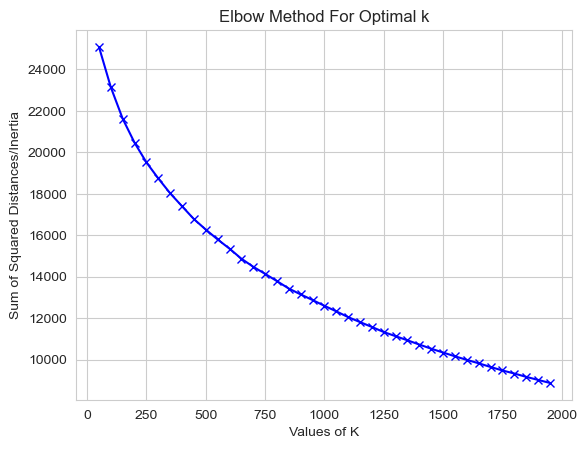

In [ ]:
elbow_plot(male_question_vectors_1std)

100%|██████████| 39/39 [10:01<00:00, 15.42s/it]


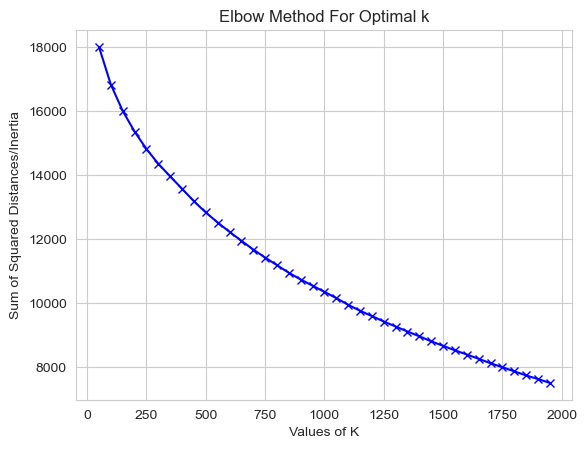

In [ ]:
elbow_plot(male_question_vectors_0std)

100%|██████████| 39/39 [02:21<00:00,  3.63s/it]


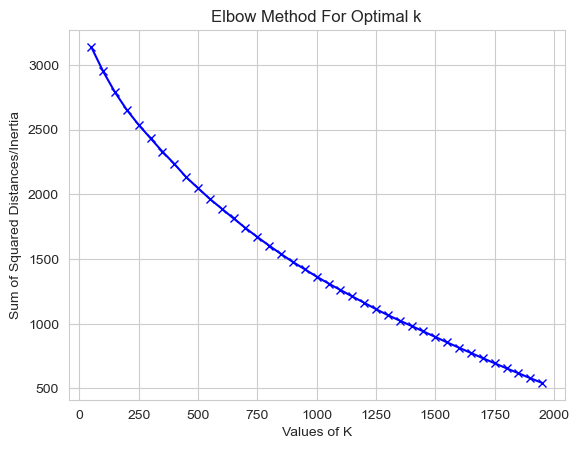

In [ ]:
elbow_plot(male_question_vectors_neg_3std)

100%|██████████| 39/39 [07:02<00:00, 10.82s/it]


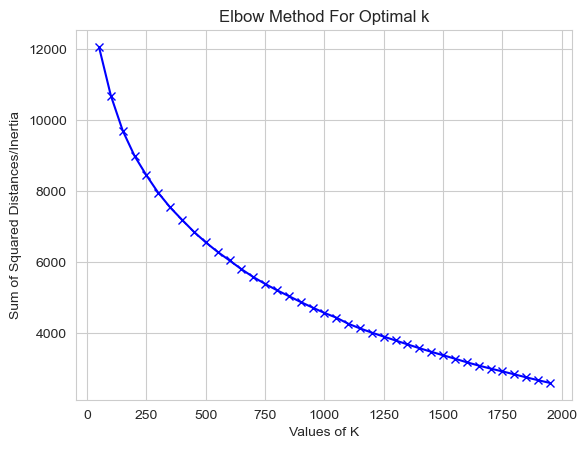

In [ ]:
elbow_plot(female_question_vectors_1std)

100%|██████████| 39/39 [05:06<00:00,  7.86s/it]


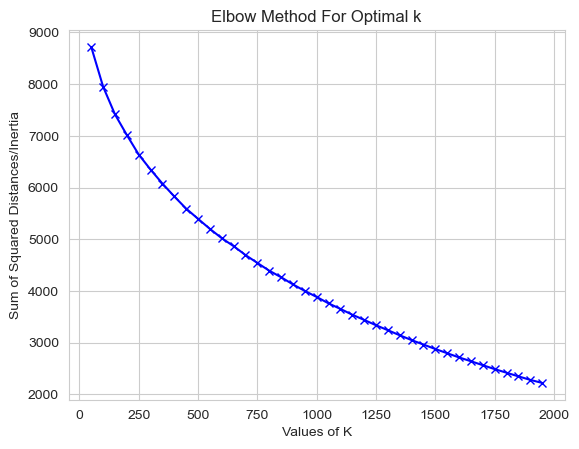

In [ ]:
elbow_plot(female_question_vectors_0std)

100%|██████████| 39/39 [01:10<00:00,  1.81s/it]


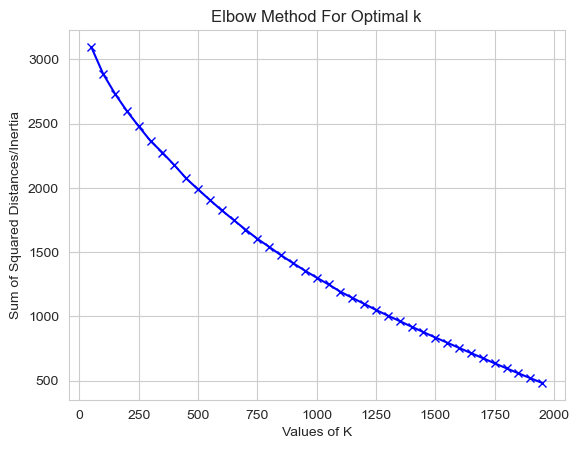

In [ ]:
elbow_plot(female_question_vectors_neg_3std)

Get most similar word to each cluster centroid

In [ ]:
def get_centroid_similar_word(vector_lst):
    kmeans = KMeans(init='k-means++', n_clusters=1250, random_state=0, n_init="auto")
    kmeans.fit(vector_lst)
    most_similar = []
    for centroid in kmeans.cluster_centers_:
        similar = vectors.most_similar_approx(centroid)[0]
        most_similar.append(similar)
    return most_similar

In [ ]:
c_sim_male_1std = get_centroid_similar_word(male_question_vectors_1std)
c_sim_male_0std = get_centroid_similar_word(male_question_vectors_0std)
c_sim_male_neg_3std = get_centroid_similar_word(male_question_vectors_neg_3std)

c_sim_female_1std = get_centroid_similar_word(female_question_vectors_1std)
c_sim_female_0std = get_centroid_similar_word(female_question_vectors_0std)
c_sim_female_neg_3std = get_centroid_similar_word(female_question_vectors_neg_3std)

This function looks for matches between male/female cluster centroids (the word with the most similar vector) and a given set (commentary or GPT generated tennis terms). There are two methods by which it can get matches:

1.) looking at the 10 most similar word vectors to the centroids and checking if any of those are in the comparison list (only one per centroid is can be counted)
2.) looking at each word in the comparison list, calculating the cosine similarity score between it and the centroid's most similar word, and checking if this is beyond some passed threshold

In [ ]:
def get_per_words_in_lst(male_words, female_words, check_words, type, method='sim_match', threshold=0.5):

    if method == 'sim_match':
        male_included = 0
        male_excluded = 0
        for word, count in tqdm(male_words):
            if word.lower() in check_words:
                male_included += 1
            else:
                similar_words = [word[0].lower() for word in vectors.most_similar_approx(word)]
                for similar_word in similar_words:
                    if similar_word.lower() in check_words:
                        male_included += 1
                        break
                male_excluded += 1

        female_included = 0
        female_excluded = 0
        for word, count in tqdm(female_words):
            if word.lower() in check_words:
                female_included += 1
            else:
                similar_words = [word[0].lower() for word in vectors.most_similar_approx(word)]
                for similar_word in similar_words:
                    if similar_word.lower() in check_words:
                        female_included += 1
                        break
                female_excluded += 1

    elif method == 'cosine':
        male_included = 0
        male_excluded = 0
        for word, count in tqdm(male_words):
            for check_word in check_words:
                if vectors.similarity(word.lower(), check_word.lower()) > threshold:
                    male_included += 1
                    break
            male_excluded += 1


        female_included = 0
        female_excluded = 0
        for word, count in tqdm(female_words):
            for check_word in check_words:
                if vectors.similarity(word.lower(), check_word.lower()) > threshold:
                    female_included += 1
                    break
            female_excluded += 1

    male_total = male_included + male_excluded
    female_total = female_included + female_excluded

    male_p = male_included / male_total
    female_p = female_included / female_total

    p_star = (male_included + female_included) / (male_total + female_total)
    z_stat = (male_p - female_p) / math.sqrt( p_star * (1 - p_star) * ( (1/male_total) + (1/female_total) ) )

    print("Z-stat:", z_stat)
    p_value = stats.norm.sf(abs(z_stat))
    print("p-value:", p_value)

    print("Male Included Percentage:", male_p)
    print("Female Included Percentage:", female_p)

    print("Percentage of Male Words Included:", male_p)
    print("Percentage of Female Words Included:", female_p)
    return np.array([[round(male_p, 4), 'M', type, round(p_value, 4)],
                     [round(female_p, 4), 'F', type, round(p_value, 4)]])

Compare men's/women's words with the tennis commentary using method 1

In [ ]:
print("After Removing Words with Frequency > 1 std:")
c_1std_array = get_per_words_in_lst(c_sim_male_1std, c_sim_female_1std, commentary_words,
                                    'Centroid 10 Most Similar Words in Commentary\n(word freq < 1 STDs, 1250 clusters, 0.0001 p-val)', method='sim_match')
print()
print('--------------------------------------------------')
print()
print("After Removing Words with Frequency > the Mean:")
c_0std_array = get_per_words_in_lst(c_sim_male_0std, c_sim_female_0std, commentary_words,
                                    'Centroid 10 Most Similar Words in Commentary\n(word freq < 0 STDs, 1250 clusters, 0.0086 p-val)', method='sim_match')
print()
print('--------------------------------------------------')
print()
print("After Removing Words with Frequency > -3 std:")
c_neg_3std_array = get_per_words_in_lst(c_sim_male_neg_3std, c_sim_female_neg_3std, commentary_words,
                                        'Centroid 10 Most Similar Words in Commentary\n(word freq < -3 STDs, 1250 clusters, 0.1904 p-val)', method='sim_match')

After Removing Words with Frequency > 1 std:


100%|██████████| 1250/1250 [00:00<00:00, 4710.69it/s]


Z-stat: 3.796306758265276
p-value: 7.34338736539533e-05
Male Included Percentage: 0.6290887850467289
Female Included Percentage: 0.565668202764977
Percentage of Male Words Included: 0.6290887850467289
Percentage of Female Words Included: 0.565668202764977

--------------------------------------------------

After Removing Words with Frequency > the Mean:


100%|██████████| 1250/1250 [00:00<00:00, 4132.31it/s]


Z-stat: 2.38064907830117
p-value: 0.008641083308863538
Male Included Percentage: 0.5552486187845304
Female Included Percentage: 0.5156599552572707
Percentage of Male Words Included: 0.5552486187845304
Percentage of Female Words Included: 0.5156599552572707

--------------------------------------------------

After Removing Words with Frequency > -3 std:


100%|██████████| 1250/1250 [00:00<00:00, 1962.94it/s]

Z-stat: 0.8765677561018167
p-value: 0.1903607295539736
Male Included Percentage: 0.3651523864289822
Female Included Percentage: 0.3508464681844717
Percentage of Male Words Included: 0.3651523864289822
Percentage of Female Words Included: 0.3508464681844717


Compare men's/women's words with the GPT generated tennis terms using method 2

In [ ]:
print("After Removing Words with Frequency > 1 std:")
tw_1std_array = get_per_words_in_lst(c_sim_male_1std, c_sim_female_1std, tennis_related_words,
                                     'Centroid Cosine-Sim w/ GPT Tennis Words\n(word freq < 1 STDs, 0.3 threshold, 1250 clusters, 0.0065 p-val)', method='cosine', threshold=0.3)
print()
print('--------------------------------------------------')
print()
print("After Removing Words with Frequency > the Mean:")
tw_0std_array = get_per_words_in_lst(c_sim_male_0std, c_sim_female_0std, tennis_related_words,
                                     'Centroid Cosine-Sim w/ GPT Tennis Words\n(word freq < 0 STDs, 0.3 threshold, 1250 clusters, 0.0271 p-val)', method='cosine', threshold=0.3)
print()
print('--------------------------------------------------')
print()
print("After Removing Words with Frequency > -3 std:")
tw_neg_3std_array = get_per_words_in_lst(c_sim_male_neg_3std, c_sim_female_neg_3std, tennis_related_words,
                                         'Centroid Cosine-Sim w/ GPT Tennis Words\n(word freq < -3 STDs, 0.3 threshold, 1250 clusters, 0.1981 p-val)', method='cosine', threshold=0.3)

After Removing Words with Frequency > 1 std:


100%|██████████| 1250/1250 [00:02<00:00, 437.64it/s]


Z-stat: 2.481207862260146
p-value: 0.006546899615199854
Male Included Percentage: 0.44641275465013286
Female Included Percentage: 0.40926275992438566
Percentage of Male Words Included: 0.44641275465013286
Percentage of Female Words Included: 0.40926275992438566

--------------------------------------------------

After Removing Words with Frequency > the Mean:


100%|██████████| 1250/1250 [00:03<00:00, 368.39it/s]


Z-stat: 1.9247234360237306
p-value: 0.027131983461557933
Male Included Percentage: 0.4128698919680601
Female Included Percentage: 0.38362919132149903
Percentage of Male Words Included: 0.4128698919680601
Percentage of Female Words Included: 0.38362919132149903

--------------------------------------------------

After Removing Words with Frequency > -3 std:


100%|██████████| 1250/1250 [00:04<00:00, 266.90it/s]

Z-stat: 0.8485306093700852
p-value: 0.1980712665535762
Male Included Percentage: 0.2532855436081243
Female Included Percentage: 0.24058323207776428
Percentage of Male Words Included: 0.2532855436081243
Percentage of Female Words Included: 0.24058323207776428


Visualize the results

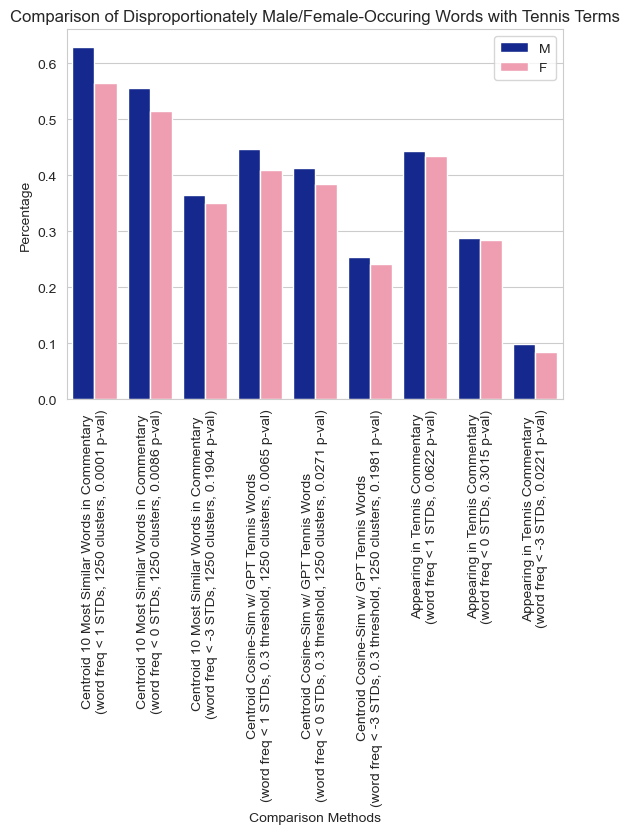

In [ ]:
combined_array = np.concatenate((c_1std_array, c_0std_array, c_neg_3std_array,
                                 tw_1std_array, tw_0std_array, tw_neg_3std_array,
                                 bl_tc_1std_array, bl_tc_0std_array, bl_tc_neg_3std_array), axis=0)

vector_results_df = pd.DataFrame(combined_array, columns=['Percentage', 'Gender', 'Comparison Set', 'P-Value'])
vector_results_df['Percentage'] = vector_results_df['Percentage'].astype(float)

sns.barplot(vector_results_df, x="Comparison Set", y="Percentage", hue="Gender")
plt.tick_params(axis='x', rotation=90)

# create custom colors array
colors = ["#001ba1", "#fc90ab"]
# set custom color palette
sns.set_palette(sns.color_palette(colors))

#Adding labels and title
plt.xlabel('Comparison Methods')
plt.xticks(rotation=90)
plt.title('Comparison of Disproportionately Male/Female-Occuring Words with Tennis Terms')

# Adding a legend
plt.legend()

# Display the plot
plt.show()

Table used to produce the above graph

In [ ]:
vector_results_df

Percentage Gender                                     Comparison Set  \
0       0.6291      M  Centroid 10 Most Similar Words in Commentary\n...   
1       0.5657      F  Centroid 10 Most Similar Words in Commentary\n...   
2       0.5552      M  Centroid 10 Most Similar Words in Commentary\n...   
3       0.5157      F  Centroid 10 Most Similar Words in Commentary\n...   
4       0.3652      M  Centroid 10 Most Similar Words in Commentary\n...   
5       0.3508      F  Centroid 10 Most Similar Words in Commentary\n...   
6       0.4464      M  Centroid Cosine-Sim w/ GPT Tennis Words\n(word...   
7       0.4093      F  Centroid Cosine-Sim w/ GPT Tennis Words\n(word...   
8       0.4129      M  Centroid Cosine-Sim w/ GPT Tennis Words\n(word...   
9       0.3836      F  Centroid Cosine-Sim w/ GPT Tennis Words\n(word...   
10      0.2533      M  Centroid Cosine-Sim w/ GPT Tennis Words\n(word...   
11      0.2406      F  Centroid Cosine-Sim w/ GPT Tennis Words\n(word...   
12      0.4434      M  Appearing in Tennis Commentary\n(word freq < 1...   
13      0.4353      F  Appearing in Tennis Commentary\n(word freq < 1...   
14      0.2871      M  Appearing in Tennis Commentary\n(word freq < 0...   
15      0.2840      F  Appearing in Tennis Commentary\n(word freq < 0...   
16      0.0979      M  Appearing in Tennis Commentary\n(word freq < -...   
17      0.0847      F  Appearing in Tennis Commentary\n(word freq < -...   

   P-Value  
0   0.0001  
1   0.0001  
2   0.0086  
3   0.0086  
4   0.1904  
5   0.1904  
6   0.0065  
7   0.0065  
8   0.0271  
9   0.0271  
10  0.1981  
11  0.1981  
12  0.0622  
13  0.0622  
14  0.3015  
15  0.3015  
16  0.0221  
17  0.0221

In [ ]:
# questions_df_cleaned.to_csv('/Users/kylesullivan/Documents/Educational/School/Graduate/UPenn/Courses/CIS 530/Project/questions_perplexities.csv')